# Simplified File Checker for Drone Metashape Exports

This simplified checker focuses on:
1. Listing export files with their sizes
2. Providing direct links to date folders
3. Identifying potential failed processing

In [26]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime
import re
from tqdm.notebook import tqdm
import humanize  # For converting bytes to human-readable format

In [27]:
# Setup the base directory where all the data is stored
# Update this to match your actual base directory
BASE_DIR = Path(r"E:/Share")  # Replace with your actual path

# Check if the directory exists
if not BASE_DIR.exists():
    print(f"Base directory {BASE_DIR} does not exist!")
    # Try to find a suitable directory
    drive_letters = ['E:', 'D:', 'F:', 'G:', 'C:']
    for drive in drive_letters:
        test_path = Path(f"{drive}/Share")
        if test_path.exists():
            BASE_DIR = test_path
            print(f"Found alternative base directory: {BASE_DIR}")
            break
    else:
        # Ask user to provide the directory
        user_dir = input("Please enter the full path to your data directory: ")
        BASE_DIR = Path(user_dir)
        if not BASE_DIR.exists():
            print(f"Entered directory {BASE_DIR} does not exist!")

print(f"Using base directory: {BASE_DIR}")

Base directory E:\Share does not exist!
Using base directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects


In [28]:
# Function to find site and date folders
def get_site_and_date_folders(base_dir):
    """
    Get available sites and dates from the directory structure
    
    Args:
        base_dir (Path): Base directory
        
    Returns:
        tuple: (List of sites, Dictionary of dates per site)
    """
    sites = []
    site_dates = {}
    
    try:
        # Get all site directories
        for item in base_dir.iterdir():
            if item.is_dir() and not item.name.startswith('.'):
                site_name = item.name
                sites.append(site_name)
                
                # Get all date directories for each site
                dates = []
                site_dir = base_dir / site_name
                for date_item in site_dir.iterdir():
                    if date_item.is_dir() and not date_item.name.startswith('.'):
                        # Check if it looks like a date folder
                        if re.match(r'\d{4}[-_]?\d{2}[-_]?\d{2}', date_item.name):
                            dates.append(date_item.name)
                
                site_dates[site_name] = sorted(dates)
        
        sites.sort()
        
    except Exception as e:
        print(f"Error finding site and date folders: {e}")
        
    return sites, site_dates

# Function to check export files for a site and date
def check_export_files(base_dir, site, date):
    """
    Check export files for a specific site and date
    
    Args:
        base_dir (Path): Base directory
        site (str): Site name
        date (str): Date string
        
    Returns:
        tuple: (DataFrame with file details, export directory Path)
    """
    # Construct the project directory path
    project_dir = base_dir / site / date
    
    # Try to find the exports directory
    exports_dir = None
    exports_pattern = ['exports', 'Exports', 'export', 'Export']
    
    for pattern in exports_pattern:
        test_dir = project_dir / pattern
        if test_dir.exists() and test_dir.is_dir():
            exports_dir = test_dir
            break
    
    # If exports directory not found directly, search for it
    if exports_dir is None:
        for item in project_dir.glob('*'):
            if item.is_dir() and any(pat.lower() in item.name.lower() for pat in exports_pattern):
                exports_dir = item
                break
    
    # If still not found, return empty DataFrame
    if exports_dir is None:
        print(f"No exports directory found for {site}/{date}")
        return pd.DataFrame(), None
    
    # Get all files in exports directory and subdirectories
    file_list = []
    
    try:
        for file_path in exports_dir.glob('**/*'):
            if file_path.is_file():
                relative_path = file_path.relative_to(exports_dir)
                file_size = file_path.stat().st_size
                file_modified = datetime.fromtimestamp(file_path.stat().st_mtime)
                
                file_list.append({
                    'filename': file_path.name,
                    'path': str(file_path),
                    'relative_path': str(relative_path),
                    'size_bytes': file_size,
                    'size_human': humanize.naturalsize(file_size),
                    'modified': file_modified,
                    'extension': file_path.suffix.lower()
                })
    except Exception as e:
        print(f"Error listing files in {exports_dir}: {e}")
    
    # Convert to DataFrame
    if file_list:
        df = pd.DataFrame(file_list)
        # Sort by size (largest first)
        df = df.sort_values('size_bytes', ascending=False)
    else:
        df = pd.DataFrame(columns=['filename', 'path', 'relative_path', 'size_bytes', 
                                  'size_human', 'modified', 'extension'])
    
    return df, exports_dir

# Function to create HTML link
def create_html_link(path):
    """Create clickable HTML link to a file or directory"""
    if not path:
        return "N/A"
    path_obj = Path(path)
    if not path_obj.exists():
        return f"<span style='color: red'>{path} (Not found)</span>"
    
    # Create a file:// URL
    url = f"file:///{str(path_obj).replace(os.sep, '/')}"
    return f"<a href='{url}' target='_blank'>{path}</a>"

# Function to generate a simple report for export files
def generate_file_report(file_df, exports_dir, site, date):
    """
    Generate a report for export files
    
    Args:
        file_df (DataFrame): DataFrame with file information
        exports_dir (Path): Exports directory path
        site (str): Site name
        date (str): Date string
        
    Returns:
        None (displays report)
    """
    if file_df.empty:
        print(f"No export files found for {site}/{date}")
        return
    
    # Summary information
    total_files = len(file_df)
    total_size = file_df['size_bytes'].sum()
    total_size_human = humanize.naturalsize(total_size)
    
    # Group by extension
    ext_summary = file_df.groupby('extension').agg(
        file_count=('filename', 'count'),
        total_size=('size_bytes', 'sum')
    ).reset_index()
    ext_summary['avg_size'] = ext_summary['total_size'] / ext_summary['file_count']
    ext_summary['total_size_human'] = ext_summary['total_size'].apply(humanize.naturalsize)
    ext_summary['avg_size_human'] = ext_summary['avg_size'].apply(humanize.naturalsize)
    ext_summary = ext_summary.sort_values('total_size', ascending=False)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"EXPORT FILES REPORT: {site}/{date}")
    print(f"{'='*80}")
    print(f"Exports Directory: {exports_dir}")
    print(f"Directory Link: {create_html_link(exports_dir)}")
    print(f"Total Files: {total_files}")
    print(f"Total Size: {total_size_human}")
    
    # Display extension summary
    print("\nFile Types Summary:")
    display(ext_summary[['extension', 'file_count', 'total_size_human', 'avg_size_human']])
    
    # Display the largest files
    print("\nLargest Files:")
    largest_files = file_df.head(10)
    display(largest_files[['filename', 'relative_path', 'size_human', 'modified']])
    
    # Display HTML links to largest files
    html_links = "<h3>Links to Largest Files:</h3><ul>"
    for _, row in largest_files.iterrows():
        html_links += f"<li><a href='file:///{row['path'].replace(os.sep, '/')}' target='_blank'>{row['filename']} ({row['size_human']})</a></li>"
    html_links += "</ul>"
    
    display(HTML(html_links))
    
    # Create HTML link to exports directory
    dir_link = f"<h3>Direct link to exports directory:</h3>"
    dir_link += f"<a href='file:///{str(exports_dir).replace(os.sep, '/')}' target='_blank'>{exports_dir}</a>"
    display(HTML(dir_link))
    
    # Check for potential processing issues
    check_for_issues(file_df, site, date)

In [29]:
# Function to check for potential processing issues
def check_for_issues(file_df, site, date):
    """
    Check for potential processing issues based on file patterns
    
    Args:
        file_df (DataFrame): DataFrame with file information
        site (str): Site name
        date (str): Date string
    """
    issues = []
    
    # Check if any files exist at all
    if file_df.empty:
        issues.append("No files found in exports directory")
        
    else:
        # Check for common export types that should exist
        expected_extensions = ['.tif', '.jpg', '.png', '.shp', '.xml', '.txt']
        missing_extensions = [ext for ext in expected_extensions if ext not in file_df['extension'].values]
        if missing_extensions:
            issues.append(f"Missing expected file types: {', '.join(missing_extensions)}")
        
        # Check for very small files (potential truncated/failed exports)
        small_files = file_df[(file_df['extension'].isin(['.tif', '.jpg', '.png'])) & 
                             (file_df['size_bytes'] < 10000)]
        if not small_files.empty:
            issues.append(f"Found {len(small_files)} unusually small image files (possibly corrupted)")
            
        # Check for empty directories (files with very small total size)
        total_size = file_df['size_bytes'].sum()
        if total_size < 100000:  # Less than 100KB total
            issues.append(f"Total export size is very small ({humanize.naturalsize(total_size)})")
            
        # Check for recent modifications (potential ongoing processing)
        recent_files = file_df[file_df['modified'] > datetime.now().replace(hour=0, minute=0, second=0)]
        if not recent_files.empty:
            issues.append(f"Found {len(recent_files)} files modified today (processing may be ongoing)")
    
    # Print issues if any found
    if issues:
        print("\n⚠️ Potential Processing Issues Detected:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\n✅ No obvious processing issues detected")

In [30]:
# Get available sites and dates
sites, site_dates = get_site_and_date_folders(BASE_DIR)

# Display available sites
print(f"Found {len(sites)} sites: {', '.join(sites)}\n")

# Let user select a site
print("Select a site:")
for i, site in enumerate(sites):
    print(f"{i+1}. {site}")
print(f"{len(sites)+1}. All sites")

site_idx = int(input(f"Enter site number (1-{len(sites)+1}): ")) - 1

if site_idx == len(sites):  # All sites selected
    selected_sites = sites
    print("Selected all sites")
else:
    selected_sites = [sites[site_idx]]
    print(f"Selected site: {selected_sites[0]}")

# Ask if user wants to check all dates regardless of site selection
if len(selected_sites) == 1:
    print("\nSelect a date:")
    dates = site_dates.get(selected_sites[0], [])
    for i, date in enumerate(dates):
        print(f"{i+1}. {date}")
    print(f"{len(dates)+1}. All dates")
    
    date_idx = int(input(f"Enter date number (1-{len(dates)+1}): ")) - 1
    
    if date_idx == len(dates):  # All dates selected for this site
        check_all_dates = True
        print("Selected all dates for this site")
    else:
        check_all_dates = False
        selected_date = dates[date_idx]
        print(f"Selected date: {selected_date}")
else:
    # If all sites selected, ask if all dates should be checked
    check_all_dates = input("\nCheck all dates for all sites? (y/n): ").lower() == 'y'
    if check_all_dates:
        print("Will check ALL dates for ALL sites")
    else:
        print("Will check only the most recent date for each site")

# Keep track of all file DataFrames for potential export
all_file_dfs = {}

# Process each selected site
for site in tqdm(selected_sites, desc="Processing sites"):
    dates = site_dates.get(site, [])
    
    if not dates:
        print(f"\nNo date folders found for site {site}")
        continue
    
    # Determine which dates to process
    if len(selected_sites) == 1 and not check_all_dates:
        # Single site, single date
        dates_to_check = [selected_date]
    elif check_all_dates:
        # All dates
        dates_to_check = dates
    else:
        # Most recent date only
        dates_to_check = [dates[-1]]
    
    # Process each selected date
    for date in tqdm(dates_to_check, desc=f"Checking dates for {site}"):
        print(f"\nChecking export files for {site}/{date}")
        file_df, exports_dir = check_export_files(BASE_DIR, site, date)
        
        # Store this DataFrame for potential export
        all_file_dfs[(site, date)] = file_df
        
        generate_file_report(file_df, exports_dir, site, date)

# Print summary of all checked sites and dates
print("\n" + "="*80)
print(f"SUMMARY OF ALL CHECKED SITES AND DATES")
print("="*80)
print(f"Total sites checked: {len(selected_sites)}")

# Count dates and files
total_dates = sum(len(site_dates.get(site, [])) if check_all_dates else 1 for site in selected_sites if site_dates.get(site, []))
print(f"Total dates checked: {total_dates}")

# Count files
total_files = sum(len(df) for df in all_file_dfs.values())
print(f"Total files found: {total_files}")

# Calculate total size
total_size = sum(df['size_bytes'].sum() if not df.empty else 0 for df in all_file_dfs.values())
print(f"Total size of all files: {humanize.naturalsize(total_size)}")

Found 17 sites: 0001_project_lists, Brüttelen_sanasilva50845, Davos_LWF, Illgraben, Isone_LWF, Lens_LWF, Marteloskop, Neunkirch_LWF, Pfynwald, Sagno_treenet, Salgesch_treenet, Schänis_LWF, Schüpfen_sanasilva50877, Sempach_treenet, Stillberg, Visp_LWF, WangenBrüttisellen_treenet

Select a site:
1. 0001_project_lists
2. Brüttelen_sanasilva50845
3. Davos_LWF
4. Illgraben
5. Isone_LWF
6. Lens_LWF
7. Marteloskop
8. Neunkirch_LWF
9. Pfynwald
10. Sagno_treenet
11. Salgesch_treenet
12. Schänis_LWF
13. Schüpfen_sanasilva50877
14. Sempach_treenet
15. Stillberg
16. Visp_LWF
17. WangenBrüttisellen_treenet
18. All sites
Selected all sites
Will check ALL dates for ALL sites


Processing sites:   0%|          | 0/17 [00:00<?, ?it/s]


No date folders found for site 0001_project_lists


Checking dates for Brüttelen_sanasilva50845:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Brüttelen_sanasilva50845/20240813

EXPORT FILES REPORT: Brüttelen_sanasilva50845/20240813
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20240813\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Brüttelen_sanasilva50845/20240813/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20240813\exports</a>
Total Files: 7
Total Size: 9.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
1,.obj,1,5.0 GB,5.0 GB
3,.tif,2,4.9 GB,2.5 GB
2,.pdf,2,13.1 MB,6.6 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
4,20240813_Brüttelen_sanasilva50845_rgb_smooth_1...,20240813_Brüttelen_sanasilva50845_rgb_smooth_1...,5.0 GB,2025-04-06 21:18:49.653291
0,20240813_Brüttelen_sanasilva50845_rgb_model_or...,20240813_Brüttelen_sanasilva50845_rgb_model_or...,3.2 GB,2025-04-06 23:16:45.322952
6,20240813_Brüttelen_sanasilva50845_multispec_or...,20240813_Brüttelen_sanasilva50845_multispec_or...,1.8 GB,2025-04-09 16:07:58.643924
3,20240813_Brüttelen_sanasilva50845_rgb_report.pdf,20240813_Brüttelen_sanasilva50845_rgb_report.pdf,11.0 MB,2025-04-06 23:26:55.865482
5,20240813_Brüttelen_sanasilva50845_multispec_re...,20240813_Brüttelen_sanasilva50845_multispec_re...,2.2 MB,2025-04-09 16:11:04.374465
2,20240813_Brüttelen_sanasilva50845_multispec_or...,20240813_Brüttelen_sanasilva50845_multispec_or...,1.5 MB,2025-04-16 08:49:03.239069
1,20240813_Brüttelen_sanasilva50845_rgb_smooth_1...,20240813_Brüttelen_sanasilva50845_rgb_smooth_1...,88 Bytes,2025-04-06 21:18:49.660220



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Brüttelen_sanasilva50845/20240906

EXPORT FILES REPORT: Brüttelen_sanasilva50845/20240906
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20240906\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Brüttelen_sanasilva50845/20240906/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20240906\exports</a>
Total Files: 7
Total Size: 9.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.7 GB,2.4 GB
1,.obj,1,4.3 GB,4.3 GB
2,.pdf,2,11.2 MB,5.6 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
6,20240906_Brüttelen_sanasilva50845_rgb_smooth_1...,20240906_Brüttelen_sanasilva50845_rgb_smooth_1...,4.3 GB,2025-04-16 13:54:02.591444
3,20240906_Brüttelen_sanasilva50845_rgb_model_or...,20240906_Brüttelen_sanasilva50845_rgb_model_or...,3.1 GB,2025-04-16 15:04:07.736491
0,20240906_Brüttelen_sanasilva50845_multispec_or...,20240906_Brüttelen_sanasilva50845_multispec_or...,1.7 GB,2025-04-16 20:09:23.379380
4,20240906_Brüttelen_sanasilva50845_rgb_report.pdf,20240906_Brüttelen_sanasilva50845_rgb_report.pdf,10.0 MB,2025-04-16 15:11:10.208682
1,20240906_Brüttelen_sanasilva50845_multispec_or...,20240906_Brüttelen_sanasilva50845_multispec_or...,1.5 MB,2025-04-17 09:17:38.051176
2,20240906_Brüttelen_sanasilva50845_multispec_re...,20240906_Brüttelen_sanasilva50845_multispec_re...,1.2 MB,2025-04-16 20:10:00.752672
5,20240906_Brüttelen_sanasilva50845_rgb_smooth_1...,20240906_Brüttelen_sanasilva50845_rgb_smooth_1...,88 Bytes,2025-04-16 13:54:02.596833



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Brüttelen_sanasilva50845/20250409

EXPORT FILES REPORT: Brüttelen_sanasilva50845/20250409
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250409\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Brüttelen_sanasilva50845/20250409/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250409\exports</a>
Total Files: 7
Total Size: 6.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.4 GB,2.7 GB
1,.obj,1,1.2 GB,1.2 GB
2,.pdf,3,23.3 MB,7.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250409_sanasilva_50845_rgb_model_ortho_smoot...,20250409_sanasilva_50845_rgb_model_ortho_smoot...,3.6 GB,2025-06-24 06:52:33.794296
1,20250409_sanasilva_50845_multispec_ortho_100cm...,20250409_sanasilva_50845_multispec_ortho_100cm...,1.8 GB,2025-06-24 11:03:46.059041
6,20250409_sanasilva_50845_rgb_smooth_100.obj,20250409_sanasilva_50845_rgb_smooth_100.obj,1.2 GB,2025-06-24 06:03:19.218207
4,20250409_sanasilva_50845_rgb_report.pdf,20250409_sanasilva_50845_rgb_report.pdf,10.9 MB,2025-06-24 06:55:54.429348
0,20250409_Sanasilva-50845_rgb_report.pdf,20250409_Sanasilva-50845_rgb_report.pdf,10.9 MB,2025-07-22 08:01:05.864492
2,20250409_sanasilva_50845_multispec_report.pdf,20250409_sanasilva_50845_multispec_report.pdf,1.4 MB,2025-06-24 11:04:59.453850
5,20250409_sanasilva_50845_rgb_smooth_100.mtl,20250409_sanasilva_50845_rgb_smooth_100.mtl,88 Bytes,2025-06-24 06:03:19.227871



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Brüttelen_sanasilva50845/20250515

EXPORT FILES REPORT: Brüttelen_sanasilva50845/20250515
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250515\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Brüttelen_sanasilva50845/20250515/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250515\exports</a>
Total Files: 6
Total Size: 7.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.0 GB
1,.obj,1,3.1 GB,3.1 GB
2,.pdf,2,11.7 MB,5.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20250515_Sanasilva-50845_rgb_smooth_100.obj,20250515_Sanasilva-50845_rgb_smooth_100.obj,3.1 GB,2025-07-22 14:26:44.230562
2,20250515_Sanasilva-50845_rgb_model_ortho_smoot...,20250515_Sanasilva-50845_rgb_model_ortho_smoot...,2.7 GB,2025-07-22 15:33:36.253561
0,20250515_Sanasilva-50845_multispec_ortho_100cm...,20250515_Sanasilva-50845_multispec_ortho_100cm...,1.4 GB,2025-07-22 19:53:52.397709
3,20250515_Sanasilva-50845_rgb_report.pdf,20250515_Sanasilva-50845_rgb_report.pdf,10.6 MB,2025-07-22 15:39:32.737664
1,20250515_Sanasilva-50845_multispec_report.pdf,20250515_Sanasilva-50845_multispec_report.pdf,1.1 MB,2025-07-22 19:54:21.837251
4,20250515_Sanasilva-50845_rgb_smooth_100.mtl,20250515_Sanasilva-50845_rgb_smooth_100.mtl,88 Bytes,2025-07-22 14:26:44.240259



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Brüttelen_sanasilva50845/20250610

EXPORT FILES REPORT: Brüttelen_sanasilva50845/20250610
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250610\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Brüttelen_sanasilva50845/20250610/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Brüttelen_sanasilva50845\20250610\exports</a>
Total Files: 6
Total Size: 6.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.0 GB
1,.obj,1,2.8 GB,2.8 GB
2,.pdf,2,12.8 MB,6.4 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20250610_Sanasilva-50845_rgb_smooth_100.obj,20250610_Sanasilva-50845_rgb_smooth_100.obj,2.8 GB,2025-08-22 15:10:36.920876
2,20250610_Sanasilva-50845_rgb_model_ortho_smoot...,20250610_Sanasilva-50845_rgb_model_ortho_smoot...,2.7 GB,2025-08-22 15:56:29.319365
0,20250610_Sanasilva-50845_multispec_ortho_100cm...,20250610_Sanasilva-50845_multispec_ortho_100cm...,1.4 GB,2025-08-22 19:39:02.879162
3,20250610_Sanasilva-50845_rgb_report.pdf,20250610_Sanasilva-50845_rgb_report.pdf,11.7 MB,2025-08-22 16:00:53.797817
1,20250610_Sanasilva-50845_multispec_report.pdf,20250610_Sanasilva-50845_multispec_report.pdf,1.1 MB,2025-08-22 19:39:28.805603
4,20250610_Sanasilva-50845_rgb_smooth_100.mtl,20250610_Sanasilva-50845_rgb_smooth_100.mtl,88 Bytes,2025-08-22 15:10:36.932804



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Davos_LWF:   0%|          | 0/4 [00:00<?, ?it/s]


Checking export files for Davos_LWF/20240815

EXPORT FILES REPORT: Davos_LWF/20240815
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20240815\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Davos_LWF/20240815/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20240815\exports</a>
Total Files: 8
Total Size: 6.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.1 GB
1,.obj,1,1.8 GB,1.8 GB
2,.pdf,2,7.4 MB,3.7 MB
4,.xml,2,1.5 MB,750.6 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20240815_Davos_LWF_rgb_model_ortho_smooth_100.tif,20240815_Davos_LWF_rgb_model_ortho_smooth_100.tif,2.5 GB,2025-04-07 10:03:53.457778
7,20240815_Davos_LWF_rgb_smooth_100.obj,20240815_Davos_LWF_rgb_smooth_100.obj,1.8 GB,2025-04-07 09:25:40.900493
0,20240815_Davos_LWF_multispec_ortho_100cm.tif,20240815_Davos_LWF_multispec_ortho_100cm.tif,1.6 GB,2025-04-07 13:05:29.932877
5,20240815_Davos_LWF_rgb_report.pdf,20240815_Davos_LWF_rgb_report.pdf,6.2 MB,2025-04-07 10:07:24.505845
1,20240815_Davos_LWF_multispec_ortho_100cm.tif.a...,20240815_Davos_LWF_multispec_ortho_100cm.tif.a...,1.5 MB,2025-04-08 07:20:23.464982
2,20240815_Davos_LWF_multispec_report.pdf,20240815_Davos_LWF_multispec_report.pdf,1.2 MB,2025-04-07 13:06:09.671131
4,20240815_Davos_LWF_rgb_model_ortho_smooth_100....,20240815_Davos_LWF_rgb_model_ortho_smooth_100....,1.3 kB,2025-04-08 07:09:41.810865
6,20240815_Davos_LWF_rgb_smooth_100.mtl,20240815_Davos_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-07 09:25:40.906974



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Davos_LWF/20240918

EXPORT FILES REPORT: Davos_LWF/20240918
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20240918\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Davos_LWF/20240918/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20240918\exports</a>
Total Files: 6
Total Size: 5.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.7 GB,1.9 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,2,8.4 MB,4.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240918_Davos_LWF_rgb_model_ortho_smooth_100.tif,20240918_Davos_LWF_rgb_model_ortho_smooth_100.tif,2.3 GB,2025-04-14 06:19:19.455623
5,20240918_Davos_LWF_rgb_smooth_100.obj,20240918_Davos_LWF_rgb_smooth_100.obj,1.5 GB,2025-04-14 05:44:08.210840
0,20240918_Davos_LWF_multispec_ortho_100cm.tif,20240918_Davos_LWF_multispec_ortho_100cm.tif,1.5 GB,2025-04-14 09:00:06.356573
3,20240918_Davos_LWF_rgb_report.pdf,20240918_Davos_LWF_rgb_report.pdf,7.5 MB,2025-04-14 06:22:35.539433
1,20240918_Davos_LWF_multispec_report.pdf,20240918_Davos_LWF_multispec_report.pdf,976.9 kB,2025-04-14 09:00:25.090685
4,20240918_Davos_LWF_rgb_smooth_100.mtl,20240918_Davos_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-14 05:44:08.217659



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Davos_LWF/20250527

EXPORT FILES REPORT: Davos_LWF/20250527
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20250527\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Davos_LWF/20250527/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20250527\exports</a>
Total Files: 6
Total Size: 6.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.2 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,2,9.1 MB,4.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250527_LWF-Davos_rgb_model_ortho_smooth_100.tif,20250527_LWF-Davos_rgb_model_ortho_smooth_100.tif,2.9 GB,2025-07-24 00:27:13.634105
0,20250527_LWF-Davos_multispec_ortho_100cm.tif,20250527_LWF-Davos_multispec_ortho_100cm.tif,1.6 GB,2025-07-24 03:19:38.751224
5,20250527_LWF-Davos_rgb_smooth_100.obj,20250527_LWF-Davos_rgb_smooth_100.obj,1.5 GB,2025-07-23 23:44:01.250521
3,20250527_LWF-Davos_rgb_report.pdf,20250527_LWF-Davos_rgb_report.pdf,8.0 MB,2025-07-24 00:30:25.378663
1,20250527_LWF-Davos_multispec_report.pdf,20250527_LWF-Davos_multispec_report.pdf,1.1 MB,2025-07-24 03:20:05.643278
4,20250527_LWF-Davos_rgb_smooth_100.mtl,20250527_LWF-Davos_rgb_smooth_100.mtl,88 Bytes,2025-07-23 23:44:01.260164



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Davos_LWF/20250710

EXPORT FILES REPORT: Davos_LWF/20250710
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20250710\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Davos_LWF/20250710/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Davos_LWF\20250710\exports</a>
Total Files: 4
Total Size: 4.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,1,2.8 GB,2.8 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,1,8.1 MB,8.1 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
0,20250710_LWF-Davos_rgb_model_ortho_smooth_100.tif,20250710_LWF-Davos_rgb_model_ortho_smooth_100.tif,2.8 GB,2025-08-27 11:05:10.730242
3,20250710_LWF-Davos_rgb_smooth_100.obj,20250710_LWF-Davos_rgb_smooth_100.obj,1.5 GB,2025-08-27 10:17:33.078372
1,20250710_LWF-Davos_rgb_report.pdf,20250710_LWF-Davos_rgb_report.pdf,8.1 MB,2025-08-27 11:08:32.430261
2,20250710_LWF-Davos_rgb_smooth_100.mtl,20250710_LWF-Davos_rgb_smooth_100.mtl,88 Bytes,2025-08-27 10:17:33.086109



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Illgraben:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Illgraben/20240823

EXPORT FILES REPORT: Illgraben/20240823
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20240823\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Illgraben/20240823/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20240823\exports</a>
Total Files: 6
Total Size: 6.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.4 GB,2.2 GB
1,.obj,1,1.9 GB,1.9 GB
2,.pdf,2,9.2 MB,4.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240823_Illgraben_rgb_model_ortho_smooth_100.tif,20240823_Illgraben_rgb_model_ortho_smooth_100.tif,2.7 GB,2025-04-12 21:51:03.749344
5,20240823_Illgraben_rgb_smooth_100.obj,20240823_Illgraben_rgb_smooth_100.obj,1.9 GB,2025-04-12 21:05:54.298037
0,20240823_Illgraben_multispec_ortho_100cm.tif,20240823_Illgraben_multispec_ortho_100cm.tif,1.7 GB,2025-04-13 01:21:03.407410
3,20240823_Illgraben_rgb_report.pdf,20240823_Illgraben_rgb_report.pdf,7.9 MB,2025-04-12 21:54:52.558803
1,20240823_Illgraben_multispec_report.pdf,20240823_Illgraben_multispec_report.pdf,1.3 MB,2025-04-13 01:22:30.280311
4,20240823_Illgraben_rgb_smooth_100.mtl,20240823_Illgraben_rgb_smooth_100.mtl,88 Bytes,2025-04-12 21:05:54.303019



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Illgraben/20240925

EXPORT FILES REPORT: Illgraben/20240925
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20240925\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Illgraben/20240925/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20240925\exports</a>
Total Files: 6
Total Size: 6.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.3 GB,2.1 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,2,9.0 MB,4.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240925_Illgraben_rgb_model_ortho_smooth_100.tif,20240925_Illgraben_rgb_model_ortho_smooth_100.tif,2.5 GB,2025-04-24 16:20:09.059985
5,20240925_Illgraben_rgb_smooth_100.obj,20240925_Illgraben_rgb_smooth_100.obj,2.0 GB,2025-04-24 15:24:01.296940
0,20240925_Illgraben_multispec_ortho_100cm.tif,20240925_Illgraben_multispec_ortho_100cm.tif,1.7 GB,2025-04-24 19:36:57.297193
3,20240925_Illgraben_rgb_report.pdf,20240925_Illgraben_rgb_report.pdf,7.3 MB,2025-04-24 16:26:12.347597
1,20240925_Illgraben_multispec_report.pdf,20240925_Illgraben_multispec_report.pdf,1.7 MB,2025-04-24 19:40:22.669932
4,20240925_Illgraben_rgb_smooth_100.mtl,20240925_Illgraben_rgb_smooth_100.mtl,88 Bytes,2025-04-24 15:24:01.301924



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Illgraben/20250411

EXPORT FILES REPORT: Illgraben/20250411
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250411\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Illgraben/20250411/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250411\exports</a>
Total Files: 7
Total Size: 6.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,9.6 MB,4.8 MB
4,.xml,1,1.3 kB,1.3 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250411_illgraben_rgb_model_ortho_smooth_100.tif,20250411_illgraben_rgb_model_ortho_smooth_100.tif,2.9 GB,2025-06-25 18:55:19.443902
0,20250411_illgraben_multispec_ortho_100cm.tif,20250411_illgraben_multispec_ortho_100cm.tif,1.8 GB,2025-06-25 22:39:17.920131
6,20250411_illgraben_rgb_smooth_100.obj,20250411_illgraben_rgb_smooth_100.obj,1.6 GB,2025-06-25 18:02:40.462747
4,20250411_illgraben_rgb_report.pdf,20250411_illgraben_rgb_report.pdf,8.2 MB,2025-06-25 18:58:52.684189
1,20250411_illgraben_multispec_report.pdf,20250411_illgraben_multispec_report.pdf,1.4 MB,2025-06-25 22:41:06.714612
3,20250411_illgraben_rgb_model_ortho_smooth_100....,20250411_illgraben_rgb_model_ortho_smooth_100....,1.3 kB,2025-07-17 08:45:07.026477
5,20250411_illgraben_rgb_smooth_100.mtl,20250411_illgraben_rgb_smooth_100.mtl,88 Bytes,2025-06-25 18:02:40.470829



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Illgraben/20250528

EXPORT FILES REPORT: Illgraben/20250528
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250528\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Illgraben/20250528/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250528\exports</a>
Total Files: 6
Total Size: 6.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.0 GB,2.5 GB
1,.obj,1,1.8 GB,1.8 GB
2,.pdf,2,11.6 MB,5.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250528_Illgraben_rgb_model_ortho_smooth_100.tif,20250528_Illgraben_rgb_model_ortho_smooth_100.tif,3.3 GB,2025-07-24 08:44:46.771118
5,20250528_Illgraben_rgb_smooth_100.obj,20250528_Illgraben_rgb_smooth_100.obj,1.8 GB,2025-07-24 07:51:31.866884
0,20250528_Illgraben_multispec_ortho_100cm.tif,20250528_Illgraben_multispec_ortho_100cm.tif,1.7 GB,2025-08-21 02:03:23.970477
3,20250528_Illgraben_rgb_report.pdf,20250528_Illgraben_rgb_report.pdf,7.9 MB,2025-07-24 08:48:13.963805
1,20250528_Illgraben_multispec_report.pdf,20250528_Illgraben_multispec_report.pdf,3.7 MB,2025-08-21 02:08:16.018392
4,20250528_Illgraben_rgb_smooth_100.mtl,20250528_Illgraben_rgb_smooth_100.mtl,88 Bytes,2025-07-24 07:51:31.877479



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Illgraben/20250704

EXPORT FILES REPORT: Illgraben/20250704
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250704\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Illgraben/20250704/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Illgraben\20250704\exports</a>
Total Files: 4
Total Size: 5.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,1,3.2 GB,3.2 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,1,8.3 MB,8.3 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
0,20250704_Illgraben_rgb_model_ortho_smooth_100.tif,20250704_Illgraben_rgb_model_ortho_smooth_100.tif,3.2 GB,2025-08-25 20:48:10.748322
3,20250704_Illgraben_rgb_smooth_100.obj,20250704_Illgraben_rgb_smooth_100.obj,2.0 GB,2025-08-25 19:51:17.624790
1,20250704_Illgraben_rgb_report.pdf,20250704_Illgraben_rgb_report.pdf,8.3 MB,2025-08-25 20:51:54.054265
2,20250704_Illgraben_rgb_smooth_100.mtl,20250704_Illgraben_rgb_smooth_100.mtl,88 Bytes,2025-08-25 19:51:17.634208



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Isone_LWF:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Isone_LWF/20240821

EXPORT FILES REPORT: Isone_LWF/20240821
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20240821\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Isone_LWF/20240821/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20240821\exports</a>
Total Files: 6
Total Size: 5.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.0 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,2,7.6 MB,3.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240821_Isone_LWF_rgb_model_ortho_smooth_100.tif,20240821_Isone_LWF_rgb_model_ortho_smooth_100.tif,2.6 GB,2025-04-11 11:08:36.249159
5,20240821_Isone_LWF_rgb_smooth_100.obj,20240821_Isone_LWF_rgb_smooth_100.obj,1.5 GB,2025-04-11 10:37:51.474843
0,20240821_Isone_LWF_multispec_ortho_100cm.tif,20240821_Isone_LWF_multispec_ortho_100cm.tif,1.5 GB,2025-04-11 13:53:27.845653
3,20240821_Isone_LWF_rgb_report.pdf,20240821_Isone_LWF_rgb_report.pdf,6.4 MB,2025-04-11 11:11:45.367689
1,20240821_Isone_LWF_multispec_report.pdf,20240821_Isone_LWF_multispec_report.pdf,1.2 MB,2025-04-11 13:53:56.181690
4,20240821_Isone_LWF_rgb_smooth_100.mtl,20240821_Isone_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-11 10:37:51.479072



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Isone_LWF/20241003

EXPORT FILES REPORT: Isone_LWF/20241003
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20241003\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Isone_LWF/20241003/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20241003\exports</a>
Total Files: 6
Total Size: 5.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.0 GB,2.0 GB
1,.obj,1,1.8 GB,1.8 GB
2,.pdf,2,6.5 MB,3.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20241003_Isone_LWF_rgb_model_ortho_smooth_100.tif,20241003_Isone_LWF_rgb_model_ortho_smooth_100.tif,2.5 GB,2025-04-25 10:47:18.170343
5,20241003_Isone_LWF_rgb_smooth_100.obj,20241003_Isone_LWF_rgb_smooth_100.obj,1.8 GB,2025-04-25 10:14:14.329042
0,20241003_Isone_LWF_multispec_ortho_100cm.tif,20241003_Isone_LWF_multispec_ortho_100cm.tif,1.5 GB,2025-04-25 13:48:00.528314
3,20241003_Isone_LWF_rgb_report.pdf,20241003_Isone_LWF_rgb_report.pdf,5.3 MB,2025-04-25 10:50:51.485860
1,20241003_Isone_LWF_multispec_report.pdf,20241003_Isone_LWF_multispec_report.pdf,1.2 MB,2025-04-25 13:48:31.361652
4,20241003_Isone_LWF_rgb_smooth_100.mtl,20241003_Isone_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-25 10:14:14.334378



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Isone_LWF/20250502

EXPORT FILES REPORT: Isone_LWF/20250502
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250502\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Isone_LWF/20250502/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250502\exports</a>
Total Files: 6
Total Size: 5.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.0 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,10.5 MB,5.3 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250502_lwf_isone_rgb_model_ortho_smooth_100.tif,20250502_lwf_isone_rgb_model_ortho_smooth_100.tif,2.8 GB,2025-06-27 03:45:55.528966
5,20250502_lwf_isone_rgb_smooth_100.obj,20250502_lwf_isone_rgb_smooth_100.obj,1.6 GB,2025-06-27 03:02:10.907185
0,20250502_lwf_isone_multispec_ortho_100cm.tif,20250502_lwf_isone_multispec_ortho_100cm.tif,1.3 GB,2025-06-27 09:09:20.111360
3,20250502_lwf_isone_rgb_report.pdf,20250502_lwf_isone_rgb_report.pdf,9.3 MB,2025-06-27 03:50:03.877293
1,20250502_lwf_isone_multispec_report.pdf,20250502_lwf_isone_multispec_report.pdf,1.2 MB,2025-06-27 09:09:48.895695
4,20250502_lwf_isone_rgb_smooth_100.mtl,20250502_lwf_isone_rgb_smooth_100.mtl,88 Bytes,2025-06-27 03:02:10.917774



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Isone_LWF/20250616

EXPORT FILES REPORT: Isone_LWF/20250616
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250616\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Isone_LWF/20250616/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250616\exports</a>
Total Files: 6
Total Size: 5.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.3 GB
1,.obj,1,1.1 GB,1.1 GB
2,.pdf,2,7.4 MB,3.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250616_lwf_isone_rgb_model_ortho_smooth_100.tif,20250616_lwf_isone_rgb_model_ortho_smooth_100.tif,3.0 GB,2025-08-23 16:41:07.371534
0,20250616_lwf_isone_multispec_ortho_100cm.tif,20250616_lwf_isone_multispec_ortho_100cm.tif,1.6 GB,2025-08-23 19:49:06.874825
5,20250616_lwf_isone_rgb_smooth_100.obj,20250616_lwf_isone_rgb_smooth_100.obj,1.1 GB,2025-08-23 16:05:03.357194
3,20250616_lwf_isone_rgb_report.pdf,20250616_lwf_isone_rgb_report.pdf,6.4 MB,2025-08-23 16:43:51.008046
1,20250616_lwf_isone_multispec_report.pdf,20250616_lwf_isone_multispec_report.pdf,1.1 MB,2025-08-23 19:49:24.552362
4,20250616_lwf_isone_rgb_smooth_100.mtl,20250616_lwf_isone_rgb_smooth_100.mtl,88 Bytes,2025-08-23 16:05:03.367074



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Isone_LWF/20250711

EXPORT FILES REPORT: Isone_LWF/20250711
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250711\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Isone_LWF/20250711/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Isone_LWF\20250711\exports</a>
Total Files: 6
Total Size: 6.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.4 GB,2.2 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,8.0 MB,4.0 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250711_lwf_isone_rgb_model_ortho_smooth_100.tif,20250711_lwf_isone_rgb_model_ortho_smooth_100.tif,2.9 GB,2025-08-27 16:08:15.982148
5,20250711_lwf_isone_rgb_smooth_100.obj,20250711_lwf_isone_rgb_smooth_100.obj,1.6 GB,2025-08-27 15:27:26.231829
0,20250711_lwf_isone_multispec_ortho_100cm.tif,20250711_lwf_isone_multispec_ortho_100cm.tif,1.6 GB,2025-08-27 19:15:34.683148
3,20250711_lwf_isone_rgb_report.pdf,20250711_lwf_isone_rgb_report.pdf,6.9 MB,2025-08-27 16:11:49.530869
1,20250711_lwf_isone_multispec_report.pdf,20250711_lwf_isone_multispec_report.pdf,1.1 MB,2025-08-27 19:15:54.874504
4,20250711_lwf_isone_rgb_smooth_100.mtl,20250711_lwf_isone_rgb_smooth_100.mtl,88 Bytes,2025-08-27 15:27:26.240588



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Lens_LWF:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Lens_LWF/20240822

EXPORT FILES REPORT: Lens_LWF/20240822
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20240822\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Lens_LWF/20240822/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20240822\exports</a>
Total Files: 6
Total Size: 5.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.5 GB,1.8 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,2,7.2 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240822_Lens_LWF_rgb_model_ortho_smooth_100.tif,20240822_Lens_LWF_rgb_model_ortho_smooth_100.tif,2.3 GB,2025-04-12 01:14:27.412623
5,20240822_Lens_LWF_rgb_smooth_100.obj,20240822_Lens_LWF_rgb_smooth_100.obj,2.0 GB,2025-04-12 00:34:07.841551
0,20240822_Lens_LWF_multispec_ortho_100cm.tif,20240822_Lens_LWF_multispec_ortho_100cm.tif,1.2 GB,2025-04-12 03:04:46.716876
3,20240822_Lens_LWF_rgb_report.pdf,20240822_Lens_LWF_rgb_report.pdf,6.3 MB,2025-04-12 01:18:39.453417
1,20240822_Lens_LWF_multispec_report.pdf,20240822_Lens_LWF_multispec_report.pdf,927.8 kB,2025-04-12 03:05:28.381466
4,20240822_Lens_LWF_rgb_smooth_100.mtl,20240822_Lens_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-12 00:34:07.846415



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Lens_LWF/20240924

EXPORT FILES REPORT: Lens_LWF/20240924
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20240924\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Lens_LWF/20240924/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20240924\exports</a>
Total Files: 6
Total Size: 5.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.4 GB,1.7 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,2,7.2 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240924_Lens_LWF_rgb_model_ortho_smooth_100.tif,20240924_Lens_LWF_rgb_model_ortho_smooth_100.tif,2.3 GB,2025-04-19 06:30:41.676405
5,20240924_Lens_LWF_rgb_smooth_100.obj,20240924_Lens_LWF_rgb_smooth_100.obj,2.0 GB,2025-04-19 05:52:16.333946
0,20240924_Lens_LWF_multispec_ortho_100cm.tif,20240924_Lens_LWF_multispec_ortho_100cm.tif,1.2 GB,2025-04-19 08:18:06.189699
3,20240924_Lens_LWF_rgb_report.pdf,20240924_Lens_LWF_rgb_report.pdf,6.4 MB,2025-04-19 06:34:34.819790
1,20240924_Lens_LWF_multispec_report.pdf,20240924_Lens_LWF_multispec_report.pdf,834.4 kB,2025-04-19 08:18:22.656295
4,20240924_Lens_LWF_rgb_smooth_100.mtl,20240924_Lens_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-19 05:52:16.341067



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Lens_LWF/20250410

EXPORT FILES REPORT: Lens_LWF/20250410
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250410\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Lens_LWF/20250410/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250410\exports</a>
Total Files: 6
Total Size: 5.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.7 GB,1.8 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,7.4 MB,3.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250410_lwf_lens_rgb_model_ortho_smooth_100.tif,20250410_lwf_lens_rgb_model_ortho_smooth_100.tif,2.4 GB,2025-06-25 11:05:07.571270
5,20250410_lwf_lens_rgb_smooth_100.obj,20250410_lwf_lens_rgb_smooth_100.obj,1.6 GB,2025-06-25 10:19:33.942636
0,20250410_lwf_lens_multispec_ortho_100cm.tif,20250410_lwf_lens_multispec_ortho_100cm.tif,1.2 GB,2025-06-25 13:19:46.592220
3,20250410_lwf_lens_rgb_report.pdf,20250410_lwf_lens_rgb_report.pdf,6.4 MB,2025-06-25 11:08:27.521558
1,20250410_lwf_lens_multispec_report.pdf,20250410_lwf_lens_multispec_report.pdf,1.0 MB,2025-06-25 13:20:27.057023
4,20250410_lwf_lens_rgb_smooth_100.mtl,20250410_lwf_lens_rgb_smooth_100.mtl,88 Bytes,2025-06-25 10:19:33.950655



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Lens_LWF/20250526

EXPORT FILES REPORT: Lens_LWF/20250526
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250526\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Lens_LWF/20250526/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250526\exports</a>
Total Files: 6
Total Size: 5.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.6 GB,1.8 GB
1,.obj,1,1.7 GB,1.7 GB
2,.pdf,2,7.3 MB,3.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250526_lwf_lens_rgb_model_ortho_smooth_100.tif,20250526_lwf_lens_rgb_model_ortho_smooth_100.tif,2.6 GB,2025-07-23 19:29:23.288422
5,20250526_lwf_lens_rgb_smooth_100.obj,20250526_lwf_lens_rgb_smooth_100.obj,1.7 GB,2025-07-23 18:43:58.754957
0,20250526_lwf_lens_multispec_ortho_100cm.tif,20250526_lwf_lens_multispec_ortho_100cm.tif,990.3 MB,2025-07-23 20:35:06.797264
3,20250526_lwf_lens_rgb_report.pdf,20250526_lwf_lens_rgb_report.pdf,6.4 MB,2025-07-23 19:32:43.697430
1,20250526_lwf_lens_multispec_report.pdf,20250526_lwf_lens_multispec_report.pdf,895.9 kB,2025-07-23 20:35:40.845895
4,20250526_lwf_lens_rgb_smooth_100.mtl,20250526_lwf_lens_rgb_smooth_100.mtl,88 Bytes,2025-07-23 18:43:58.765751



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Lens_LWF/20250703

EXPORT FILES REPORT: Lens_LWF/20250703
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250703\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Lens_LWF/20250703/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Lens_LWF\20250703\exports</a>
Total Files: 6
Total Size: 5.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.3 GB,1.7 GB
1,.obj,1,2.3 GB,2.3 GB
2,.pdf,2,7.1 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250703_lwf_lens_rgb_model_ortho_smooth_100.tif,20250703_lwf_lens_rgb_model_ortho_smooth_100.tif,2.4 GB,2025-08-25 13:16:04.792238
5,20250703_lwf_lens_rgb_smooth_100.obj,20250703_lwf_lens_rgb_smooth_100.obj,2.3 GB,2025-08-25 12:26:30.842411
0,20250703_lwf_lens_multispec_ortho_100cm.tif,20250703_lwf_lens_multispec_ortho_100cm.tif,927.4 MB,2025-08-25 14:28:30.755572
3,20250703_lwf_lens_rgb_report.pdf,20250703_lwf_lens_rgb_report.pdf,6.2 MB,2025-08-25 13:19:56.992017
1,20250703_lwf_lens_multispec_report.pdf,20250703_lwf_lens_multispec_report.pdf,912.5 kB,2025-08-25 14:29:29.451766
4,20250703_lwf_lens_rgb_smooth_100.mtl,20250703_lwf_lens_rgb_smooth_100.mtl,88 Bytes,2025-08-25 12:26:30.855936



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Marteloskop:   0%|          | 0/4 [00:00<?, ?it/s]


Checking export files for Marteloskop/20240815

EXPORT FILES REPORT: Marteloskop/20240815
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20240815\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Marteloskop/20240815/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20240815\exports</a>
Total Files: 6
Total Size: 4.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.3 GB,1.6 GB
1,.obj,1,882.3 MB,882.3 MB
2,.pdf,2,7.2 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240815_Marteloskop_rgb_model_ortho_smooth_10...,20240815_Marteloskop_rgb_model_ortho_smooth_10...,2.0 GB,2025-04-09 18:58:01.297352
0,20240815_Marteloskop_multispec_ortho_100cm.tif,20240815_Marteloskop_multispec_ortho_100cm.tif,1.2 GB,2025-04-09 20:43:41.379832
5,20240815_Marteloskop_rgb_smooth_100.obj,20240815_Marteloskop_rgb_smooth_100.obj,882.3 MB,2025-04-09 18:30:22.746129
3,20240815_Marteloskop_rgb_report.pdf,20240815_Marteloskop_rgb_report.pdf,6.2 MB,2025-04-09 19:00:01.986038
1,20240815_Marteloskop_multispec_report.pdf,20240815_Marteloskop_multispec_report.pdf,915.2 kB,2025-04-09 20:44:03.085576
4,20240815_Marteloskop_rgb_smooth_100.mtl,20240815_Marteloskop_rgb_smooth_100.mtl,88 Bytes,2025-04-09 18:30:22.751263



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Marteloskop/20240918

EXPORT FILES REPORT: Marteloskop/20240918
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20240918\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Marteloskop/20240918/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20240918\exports</a>
Total Files: 6
Total Size: 3.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.1 GB,1.6 GB
1,.obj,1,710.7 MB,710.7 MB
2,.pdf,2,7.5 MB,3.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240918_Marteloskop_rgb_model_ortho_smooth_10...,20240918_Marteloskop_rgb_model_ortho_smooth_10...,1.9 GB,2025-04-14 11:29:24.322761
0,20240918_Marteloskop_multispec_ortho_100cm.tif,20240918_Marteloskop_multispec_ortho_100cm.tif,1.2 GB,2025-04-14 12:56:43.335987
5,20240918_Marteloskop_rgb_smooth_100.obj,20240918_Marteloskop_rgb_smooth_100.obj,710.7 MB,2025-04-14 11:06:08.226227
3,20240918_Marteloskop_rgb_report.pdf,20240918_Marteloskop_rgb_report.pdf,6.7 MB,2025-04-14 11:31:04.125432
1,20240918_Marteloskop_multispec_report.pdf,20240918_Marteloskop_multispec_report.pdf,809.3 kB,2025-04-14 12:56:55.060135
4,20240918_Marteloskop_rgb_smooth_100.mtl,20240918_Marteloskop_rgb_smooth_100.mtl,88 Bytes,2025-04-14 11:06:08.230421



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Marteloskop/20250606

EXPORT FILES REPORT: Marteloskop/20250606
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20250606\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Marteloskop/20250606/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20250606\exports</a>
Total Files: 6
Total Size: 4.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.0 GB,2.0 GB
1,.obj,1,888.7 MB,888.7 MB
2,.pdf,2,7.3 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250606_Martelloskop_rgb_model_ortho_smooth_1...,20250606_Martelloskop_rgb_model_ortho_smooth_1...,2.6 GB,2025-08-22 09:11:46.205227
0,20250606_Martelloskop_multispec_ortho_100cm.tif,20250606_Martelloskop_multispec_ortho_100cm.tif,1.4 GB,2025-08-22 10:53:57.423480
5,20250606_Martelloskop_rgb_smooth_100.obj,20250606_Martelloskop_rgb_smooth_100.obj,888.7 MB,2025-08-22 08:40:57.127011
3,20250606_Martelloskop_rgb_report.pdf,20250606_Martelloskop_rgb_report.pdf,6.4 MB,2025-08-22 09:13:58.138941
1,20250606_Martelloskop_multispec_report.pdf,20250606_Martelloskop_multispec_report.pdf,872.4 kB,2025-08-22 10:54:18.257547
4,20250606_Martelloskop_rgb_smooth_100.mtl,20250606_Martelloskop_rgb_smooth_100.mtl,88 Bytes,2025-08-22 08:40:57.135273



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Marteloskop/20250710

EXPORT FILES REPORT: Marteloskop/20250710
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20250710\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Marteloskop/20250710/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Marteloskop\20250710\exports</a>
Total Files: 6
Total Size: 4.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.0 GB,2.0 GB
1,.obj,1,785.2 MB,785.2 MB
2,.pdf,2,7.2 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250710_Martelloskop_rgb_model_ortho_smooth_1...,20250710_Martelloskop_rgb_model_ortho_smooth_1...,2.6 GB,2025-08-27 05:13:04.716481
0,20250710_Martelloskop_multispec_ortho_100cm.tif,20250710_Martelloskop_multispec_ortho_100cm.tif,1.4 GB,2025-08-27 06:58:14.014971
5,20250710_Martelloskop_rgb_smooth_100.obj,20250710_Martelloskop_rgb_smooth_100.obj,785.2 MB,2025-08-27 04:43:37.785272
3,20250710_Martelloskop_rgb_report.pdf,20250710_Martelloskop_rgb_report.pdf,6.3 MB,2025-08-27 05:14:58.050080
1,20250710_Martelloskop_multispec_report.pdf,20250710_Martelloskop_multispec_report.pdf,834.4 kB,2025-08-27 06:58:26.878580
4,20250710_Martelloskop_rgb_smooth_100.mtl,20250710_Martelloskop_rgb_smooth_100.mtl,88 Bytes,2025-08-27 04:43:37.793420



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Neunkirch_LWF:   0%|          | 0/6 [00:00<?, ?it/s]


Checking export files for Neunkirch_LWF/20240809

EXPORT FILES REPORT: Neunkirch_LWF/20240809
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240809\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20240809/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240809\exports</a>
Total Files: 8
Total Size: 8.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,3,6.8 GB,2.3 GB
1,.obj,1,1.3 GB,1.3 GB
2,.pdf,2,6.9 MB,3.4 MB
4,.xml,1,1.3 kB,1.3 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20240809_Neunkirch_LWF_rgb_model_ortho_smooth_...,20240809_Neunkirch_LWF_rgb_model_ortho_smooth_...,3.1 GB,2025-04-05 05:41:38.332475
1,20240809_Neunkirch_LWF_multispec_ortho_100cm.tif,20240809_Neunkirch_LWF_multispec_ortho_100cm.tif,1.9 GB,2025-04-08 14:18:29.339440
0,20240809_Neunkirch_LWF_mulltispec_ortho_100cm.tif,20240809_Neunkirch_LWF_mulltispec_ortho_100cm.tif,1.8 GB,2025-04-08 12:52:01.170188
7,20240809_Neunkirch_LWF_rgb_smooth_100.obj,20240809_Neunkirch_LWF_rgb_smooth_100.obj,1.3 GB,2025-04-05 05:11:46.940524
5,20240809_Neunkirch_LWF_rgb_report.pdf,20240809_Neunkirch_LWF_rgb_report.pdf,5.4 MB,2025-04-05 10:44:22.869722
2,20240809_Neunkirch_LWF_multispec_report.pdf,20240809_Neunkirch_LWF_multispec_report.pdf,1.5 MB,2025-04-08 14:19:12.173280
4,20240809_Neunkirch_LWF_rgb_model_ortho_smooth_...,20240809_Neunkirch_LWF_rgb_model_ortho_smooth_...,1.3 kB,2025-04-08 13:24:02.459193
6,20240809_Neunkirch_LWF_rgb_smooth_100.mtl,20240809_Neunkirch_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-05 05:11:46.947522



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Neunkirch_LWF/20240829

EXPORT FILES REPORT: Neunkirch_LWF/20240829
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240829\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20240829/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240829\exports</a>
Total Files: 6
Total Size: 6.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.2 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,2,5.9 MB,3.0 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240829_Neunkirch_LWF_rgb_model_ortho_smooth_...,20240829_Neunkirch_LWF_rgb_model_ortho_smooth_...,2.8 GB,2025-04-13 05:37:18.036502
0,20240829_Neunkirch_LWF_multispec_ortho_100cm.tif,20240829_Neunkirch_LWF_multispec_ortho_100cm.tif,1.7 GB,2025-04-13 08:34:10.045398
5,20240829_Neunkirch_LWF_rgb_smooth_100.obj,20240829_Neunkirch_LWF_rgb_smooth_100.obj,1.5 GB,2025-04-13 04:57:01.250836
3,20240829_Neunkirch_LWF_rgb_report.pdf,20240829_Neunkirch_LWF_rgb_report.pdf,4.9 MB,2025-04-13 05:40:51.927117
1,20240829_Neunkirch_LWF_multispec_report.pdf,20240829_Neunkirch_LWF_multispec_report.pdf,985.8 kB,2025-04-13 08:34:29.425038
4,20240829_Neunkirch_LWF_rgb_smooth_100.mtl,20240829_Neunkirch_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-13 04:57:01.256226



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Neunkirch_LWF/20240927

EXPORT FILES REPORT: Neunkirch_LWF/20240927
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240927\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20240927/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20240927\exports</a>
Total Files: 6
Total Size: 6.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,1.5 GB,1.5 GB
2,.pdf,2,5.7 MB,2.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240927_Neunkirch_LWF_rgb_model_ortho_smooth_...,20240927_Neunkirch_LWF_rgb_model_ortho_smooth_...,2.9 GB,2025-04-24 23:00:45.161126
0,20240927_Neunkirch_LWF_multispec_ortho_100cm.tif,20240927_Neunkirch_LWF_multispec_ortho_100cm.tif,1.7 GB,2025-04-25 01:50:16.788576
5,20240927_Neunkirch_LWF_rgb_smooth_100.obj,20240927_Neunkirch_LWF_rgb_smooth_100.obj,1.5 GB,2025-04-24 22:24:24.666913
3,20240927_Neunkirch_LWF_rgb_report.pdf,20240927_Neunkirch_LWF_rgb_report.pdf,4.7 MB,2025-04-24 23:04:11.433550
1,20240927_Neunkirch_LWF_multispec_report.pdf,20240927_Neunkirch_LWF_multispec_report.pdf,976.9 kB,2025-04-25 01:50:35.618188
4,20240927_Neunkirch_LWF_rgb_smooth_100.mtl,20240927_Neunkirch_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-24 22:24:24.671911



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Neunkirch_LWF/20250424

EXPORT FILES REPORT: Neunkirch_LWF/20250424
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250424\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20250424/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250424\exports</a>
Total Files: 6
Total Size: 6.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.3 GB,2.6 GB
1,.obj,1,1.3 GB,1.3 GB
2,.pdf,2,7.8 MB,3.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250424_lwf_neunkirch_rgb_model_ortho_smooth_...,20250424_lwf_neunkirch_rgb_model_ortho_smooth_...,3.5 GB,2025-06-26 02:21:36.608548
0,20250424_lwf_neunkirch_multispec_ortho_100cm.tif,20250424_lwf_neunkirch_multispec_ortho_100cm.tif,1.8 GB,2025-06-26 05:32:27.979233
5,20250424_lwf_neunkirch_rgb_smooth_100.obj,20250424_lwf_neunkirch_rgb_smooth_100.obj,1.3 GB,2025-06-26 01:39:02.916316
3,20250424_lwf_neunkirch_rgb_report.pdf,20250424_lwf_neunkirch_rgb_report.pdf,6.7 MB,2025-06-26 02:24:11.208265
1,20250424_lwf_neunkirch_multispec_report.pdf,20250424_lwf_neunkirch_multispec_report.pdf,1.2 MB,2025-06-26 05:32:56.793621
4,20250424_lwf_neunkirch_rgb_smooth_100.mtl,20250424_lwf_neunkirch_rgb_smooth_100.mtl,88 Bytes,2025-06-26 01:39:02.925303



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Neunkirch_LWF/20250514

EXPORT FILES REPORT: Neunkirch_LWF/20250514
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250514\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20250514/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250514\exports</a>
Total Files: 6
Total Size: 6.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.1 GB,2.5 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,6.0 MB,3.0 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250514_lwf_neunkirch_rgb_model_ortho_smooth_...,20250514_lwf_neunkirch_rgb_model_ortho_smooth_...,3.1 GB,2025-07-21 17:56:45.108374
0,20250514_lwf_neunkirch_multispec_ortho_100cm.tif,20250514_lwf_neunkirch_multispec_ortho_100cm.tif,2.0 GB,2025-08-28 21:24:42.142156
5,20250514_lwf_neunkirch_rgb_smooth_100.obj,20250514_lwf_neunkirch_rgb_smooth_100.obj,1.6 GB,2025-07-21 16:58:35.395870
3,20250514_lwf_neunkirch_rgb_report.pdf,20250514_lwf_neunkirch_rgb_report.pdf,5.2 MB,2025-07-21 18:00:34.177192
1,20250514_lwf_neunkirch_multispec_report.pdf,20250514_lwf_neunkirch_multispec_report.pdf,736.1 kB,2025-08-28 21:25:01.626290
4,20250514_lwf_neunkirch_rgb_smooth_100.mtl,20250514_lwf_neunkirch_rgb_smooth_100.mtl,88 Bytes,2025-07-21 16:58:35.404057



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Neunkirch_LWF/20250619

EXPORT FILES REPORT: Neunkirch_LWF/20250619
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250619\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Neunkirch_LWF/20250619/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Neunkirch_LWF\20250619\exports</a>
Total Files: 6
Total Size: 6.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.2 GB,2.6 GB
1,.obj,1,971.1 MB,971.1 MB
2,.pdf,2,6.6 MB,3.3 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250619_lwf_neunkirch_rgb_model_ortho_smooth_...,20250619_lwf_neunkirch_rgb_model_ortho_smooth_...,3.3 GB,2025-08-24 07:54:59.412885
0,20250619_lwf_neunkirch_multispec_ortho_100cm.tif,20250619_lwf_neunkirch_multispec_ortho_100cm.tif,1.9 GB,2025-08-24 11:19:52.695932
5,20250619_lwf_neunkirch_rgb_smooth_100.obj,20250619_lwf_neunkirch_rgb_smooth_100.obj,971.1 MB,2025-08-24 07:13:15.558705
3,20250619_lwf_neunkirch_rgb_report.pdf,20250619_lwf_neunkirch_rgb_report.pdf,5.5 MB,2025-08-24 07:57:34.933921
1,20250619_lwf_neunkirch_multispec_report.pdf,20250619_lwf_neunkirch_multispec_report.pdf,1.1 MB,2025-08-24 11:20:12.376603
4,20250619_lwf_neunkirch_rgb_smooth_100.mtl,20250619_lwf_neunkirch_rgb_smooth_100.mtl,88 Bytes,2025-08-24 07:13:15.567640



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Pfynwald:   0%|          | 0/10 [00:00<?, ?it/s]


Checking export files for Pfynwald/20240823

EXPORT FILES REPORT: Pfynwald/20240823
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20240823\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20240823/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20240823\exports</a>
Total Files: 11
Total Size: 12.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,5,9.7 GB,1.9 GB
1,.obj,1,2.3 GB,2.3 GB
2,.pdf,2,10.4 MB,5.2 MB
4,.xml,2,793.8 kB,396.9 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
6,20240823_Pfynwald_rgb_model_ortho_smooth_100.tif,20240823_Pfynwald_rgb_model_ortho_smooth_100.tif,3.8 GB,2025-03-27 22:33:22.451077
7,20240823_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20240823_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.7 GB,2025-03-27 23:18:42.431988
10,20240823_Pfynwald_rgb_smooth_100.obj,20240823_Pfynwald_rgb_smooth_100.obj,2.3 GB,2025-03-27 21:49:45.116821
0,20240823_Pfynwald_multispec_ortho_100cm.tif,20240823_Pfynwald_multispec_ortho_100cm.tif,1.0 GB,2025-03-28 03:29:03.186378
2,20240823_Pfynwald_multispec_ortho_5cm_dem5cm.tif,20240823_Pfynwald_multispec_ortho_5cm_dem5cm.tif,1.0 GB,2025-03-28 04:15:59.779377
5,20240823_Pfynwald_rgb_dem_5cm.tif,20240823_Pfynwald_rgb_dem_5cm.tif,149.9 MB,2025-03-27 22:38:01.757917
8,20240823_Pfynwald_rgb_report.pdf,20240823_Pfynwald_rgb_report.pdf,7.1 MB,2025-03-27 23:18:51.552870
4,20240823_Pfynwald_multispec_report.pdf,20240823_Pfynwald_multispec_report.pdf,3.3 MB,2025-03-28 04:17:28.651466
3,20240823_Pfynwald_multispec_ortho_5cm_dem5cm.t...,20240823_Pfynwald_multispec_ortho_5cm_dem5cm.t...,398.2 kB,2025-04-01 17:53:38.234764
1,20240823_Pfynwald_multispec_ortho_100cm.tif.au...,20240823_Pfynwald_multispec_ortho_100cm.tif.au...,395.7 kB,2025-04-01 11:01:07.934206



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Pfynwald/20240925

EXPORT FILES REPORT: Pfynwald/20240925
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20240925\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20240925/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20240925\exports</a>
Total Files: 10
Total Size: 16.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,5,9.1 GB,1.8 GB
4,.zip,1,4.3 GB,4.3 GB
1,.obj,1,2.8 GB,2.8 GB
2,.pdf,2,10.4 MB,5.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
9,PfynwaldCompressed.zip,PfynwaldCompressed.zip,4.3 GB,2025-04-16 10:00:13.068602
4,20240925_Pfynwald_rgb_model_ortho_smooth_100.tif,20240925_Pfynwald_rgb_model_ortho_smooth_100.tif,3.5 GB,2025-03-28 10:04:37.288327
5,20240925_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20240925_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.4 GB,2025-03-28 10:54:31.998967
8,20240925_Pfynwald_rgb_smooth_100.obj,20240925_Pfynwald_rgb_smooth_100.obj,2.8 GB,2025-03-28 09:12:01.657157
0,20240925_Pfynwald_multispec_ortho_100cm.tif,20240925_Pfynwald_multispec_ortho_100cm.tif,1.1 GB,2025-03-28 15:34:00.451451
1,20240925_Pfynwald_multispec_ortho_5cm_dem5cm.tif,20240925_Pfynwald_multispec_ortho_5cm_dem5cm.tif,1.0 GB,2025-03-28 16:28:42.676498
3,20240925_Pfynwald_rgb_dem_5cm.tif,20240925_Pfynwald_rgb_dem_5cm.tif,143.1 MB,2025-03-28 10:09:50.421395
6,20240925_Pfynwald_rgb_report.pdf,20240925_Pfynwald_rgb_report.pdf,7.0 MB,2025-03-28 10:54:41.901612
2,20240925_Pfynwald_multispec_report.pdf,20240925_Pfynwald_multispec_report.pdf,3.4 MB,2025-03-28 16:30:20.112072
7,20240925_Pfynwald_rgb_smooth_100.mtl,20240925_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-03-28 09:12:01.663460



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Pfynwald/20241024

EXPORT FILES REPORT: Pfynwald/20241024
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241024\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20241024/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241024\exports</a>
Total Files: 9
Total Size: 11.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,5,9.2 GB,1.8 GB
1,.obj,1,2.8 GB,2.8 GB
2,.pdf,2,10.1 MB,5.1 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
4,20241024_Pfynwald_rgb_model_ortho_smooth_100.tif,20241024_Pfynwald_rgb_model_ortho_smooth_100.tif,3.5 GB,2025-03-28 22:22:44.175327
5,20241024_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20241024_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.4 GB,2025-03-28 23:14:09.853297
8,20241024_Pfynwald_rgb_smooth_100.obj,20241024_Pfynwald_rgb_smooth_100.obj,2.8 GB,2025-03-28 21:29:21.776362
0,20241024_Pfynwald_multispec_ortho_100cm.tif,20241024_Pfynwald_multispec_ortho_100cm.tif,1.1 GB,2025-03-29 17:32:42.263528
1,20241024_Pfynwald_multispec_ortho_5cm_dem5cm.tif,20241024_Pfynwald_multispec_ortho_5cm_dem5cm.tif,1.0 GB,2025-03-29 18:05:17.300216
3,20241024_Pfynwald_rgb_dem_5cm.tif,20241024_Pfynwald_rgb_dem_5cm.tif,143.6 MB,2025-03-28 22:27:56.180073
6,20241024_Pfynwald_rgb_report.pdf,20241024_Pfynwald_rgb_report.pdf,7.0 MB,2025-03-28 23:14:19.871686
2,20241024_Pfynwald_multispec_report.pdf,20241024_Pfynwald_multispec_report.pdf,3.1 MB,2025-03-29 18:06:16.467067
7,20241024_Pfynwald_rgb_smooth_100.mtl,20241024_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-03-28 21:29:21.782237



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Pfynwald/20241127

EXPORT FILES REPORT: Pfynwald/20241127
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241127\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20241127/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241127\exports</a>
Total Files: 9
Total Size: 11.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,5,9.4 GB,1.9 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,11.1 MB,5.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
4,20241127_Pfynwald_rgb_model_ortho_smooth_100.tif,20241127_Pfynwald_rgb_model_ortho_smooth_100.tif,3.6 GB,2025-03-29 04:52:41.952934
5,20241127_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20241127_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.5 GB,2025-03-29 05:53:58.653339
8,20241127_Pfynwald_rgb_smooth_100.obj,20241127_Pfynwald_rgb_smooth_100.obj,2.1 GB,2025-03-29 04:01:34.964627
0,20241127_Pfynwald_multispec_ortho_100cm.tif,20241127_Pfynwald_multispec_ortho_100cm.tif,1.1 GB,2025-03-29 22:13:49.017420
1,20241127_Pfynwald_multispec_ortho_5cm_dem5cm.tif,20241127_Pfynwald_multispec_ortho_5cm_dem5cm.tif,1.1 GB,2025-03-29 23:28:27.737820
3,20241127_Pfynwald_rgb_dem_5cm.tif,20241127_Pfynwald_rgb_dem_5cm.tif,142.3 MB,2025-03-29 04:57:27.544388
6,20241127_Pfynwald_rgb_report.pdf,20241127_Pfynwald_rgb_report.pdf,7.3 MB,2025-03-29 05:54:09.261047
2,20241127_Pfynwald_multispec_report.pdf,20241127_Pfynwald_multispec_report.pdf,3.9 MB,2025-03-29 23:30:01.728734
7,20241127_Pfynwald_rgb_smooth_100.mtl,20241127_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-03-29 04:01:34.971709



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Pfynwald/20241216

EXPORT FILES REPORT: Pfynwald/20241216
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241216\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20241216/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20241216\exports</a>
Total Files: 11
Total Size: 12.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,5,10.1 GB,2.0 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,9.1 MB,4.6 MB
4,.xml,2,1.9 MB,947.1 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
6,20241216_Pfynwald_rgb_model_ortho_smooth_100.tif,20241216_Pfynwald_rgb_model_ortho_smooth_100.tif,3.5 GB,2025-03-30 05:56:36.374407
7,20241216_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20241216_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.3 GB,2025-03-30 06:43:13.786617
10,20241216_Pfynwald_rgb_smooth_100.obj,20241216_Pfynwald_rgb_smooth_100.obj,2.1 GB,2025-03-30 05:08:05.374763
0,20241216_Pfynwald_multispec_ortho_100.tif,20241216_Pfynwald_multispec_ortho_100.tif,2.0 GB,2025-04-04 08:47:46.050994
2,20241216_Pfynwald_multispec_ortho_100cm.tif,20241216_Pfynwald_multispec_ortho_100cm.tif,1.1 GB,2025-04-04 05:42:43.521785
5,20241216_Pfynwald_rgb_dem_5cm.tif,20241216_Pfynwald_rgb_dem_5cm.tif,141.8 MB,2025-03-30 06:01:11.071470
8,20241216_Pfynwald_rgb_report.pdf,20241216_Pfynwald_rgb_report.pdf,7.0 MB,2025-03-30 06:43:23.717071
4,20241216_Pfynwald_multispec_report.pdf,20241216_Pfynwald_multispec_report.pdf,2.2 MB,2025-04-04 09:01:02.993815
1,20241216_Pfynwald_multispec_ortho_100.tif.aux.xml,20241216_Pfynwald_multispec_ortho_100.tif.aux.xml,1.5 MB,2025-04-04 08:58:57.070138
3,20241216_Pfynwald_multispec_ortho_100cm.tif.au...,20241216_Pfynwald_multispec_ortho_100cm.tif.au...,394.3 kB,2025-04-04 08:58:43.705674



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Pfynwald/20250210

EXPORT FILES REPORT: Pfynwald/20250210
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250210\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20250210/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250210\exports</a>
Total Files: 9
Total Size: 10.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,4,8.0 GB,2.0 GB
1,.obj,1,2.3 GB,2.3 GB
2,.pdf,2,10.3 MB,5.1 MB
4,.xml,1,394.2 kB,394.2 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
4,20250210_Pfynwald_rgb_model_ortho_smooth_100.tif,20250210_Pfynwald_rgb_model_ortho_smooth_100.tif,3.5 GB,2025-04-01 19:02:20.799184
5,20250210_Pfynwald_rgb_ortho_1cm_dem5cm.tif,20250210_Pfynwald_rgb_ortho_1cm_dem5cm.tif,3.3 GB,2025-04-01 20:49:10.227619
8,20250210_Pfynwald_rgb_smooth_100.obj,20250210_Pfynwald_rgb_smooth_100.obj,2.3 GB,2025-04-01 17:33:55.002559
0,20250210_Pfynwald_multispec_ortho_100cm.tif,20250210_Pfynwald_multispec_ortho_100cm.tif,1.0 GB,2025-04-01 23:56:38.940716
3,20250210_Pfynwald_rgb_dem_5cm.tif,20250210_Pfynwald_rgb_dem_5cm.tif,142.9 MB,2025-04-01 19:12:07.300217
6,20250210_Pfynwald_rgb_report.pdf,20250210_Pfynwald_rgb_report.pdf,7.0 MB,2025-04-01 20:49:25.677348
2,20250210_Pfynwald_multispec_report.pdf,20250210_Pfynwald_multispec_report.pdf,3.3 MB,2025-04-03 13:50:54.852954
1,20250210_Pfynwald_multispec_ortho_100cm.tif.au...,20250210_Pfynwald_multispec_ortho_100cm.tif.au...,394.2 kB,2025-04-03 09:56:54.987612
7,20250210_Pfynwald_rgb_smooth_100.mtl,20250210_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-04-01 17:33:55.009265



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Pfynwald/20250311

EXPORT FILES REPORT: Pfynwald/20250311
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250311\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20250311/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250311\exports</a>
Total Files: 8
Total Size: 8.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.7 GB,2.8 GB
1,.obj,1,2.9 GB,2.9 GB
2,.pdf,2,9.5 MB,4.8 MB
4,.xml,2,1.5 MB,749.7 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250311_Pfynwald_rgb_model_ortho_smooth_100.tif,20250311_Pfynwald_rgb_model_ortho_smooth_100.tif,3.7 GB,2025-04-03 21:38:06.920785
7,20250311_Pfynwald_rgb_smooth_100.obj,20250311_Pfynwald_rgb_smooth_100.obj,2.9 GB,2025-04-03 20:30:01.057003
0,20250311_Pfynwald_multispec_ortho_100cm.tif,20250311_Pfynwald_multispec_ortho_100cm.tif,2.0 GB,2025-04-05 02:36:59.309285
5,20250311_Pfynwald_rgb_report.pdf,20250311_Pfynwald_rgb_report.pdf,7.1 MB,2025-04-05 10:37:41.870688
2,20250311_Pfynwald_multispec_report.pdf,20250311_Pfynwald_multispec_report.pdf,2.5 MB,2025-04-05 02:39:35.036217
1,20250311_Pfynwald_multispec_ortho_100cm.tif.au...,20250311_Pfynwald_multispec_ortho_100cm.tif.au...,1.5 MB,2025-04-08 10:20:22.335246
4,20250311_Pfynwald_rgb_model_ortho_smooth_100.t...,20250311_Pfynwald_rgb_model_ortho_smooth_100.t...,1.3 kB,2025-04-04 10:37:42.242401
6,20250311_Pfynwald_rgb_smooth_100.mtl,20250311_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-04-03 20:30:01.064218



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Pfynwald/20250411

EXPORT FILES REPORT: Pfynwald/20250411
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250411\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20250411/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250411\exports</a>
Total Files: 7
Total Size: 8.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,6.1 GB,3.0 GB
1,.obj,1,2.5 GB,2.5 GB
2,.pdf,2,8.5 MB,4.2 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250411_pfynwald_rgb_model_ortho_smooth_100.tif,20250411_pfynwald_rgb_model_ortho_smooth_100.tif,4.0 GB,2025-06-23 23:08:40.734145
6,20250411_pfynwald_rgb_smooth_100.obj,20250411_pfynwald_rgb_smooth_100.obj,2.5 GB,2025-06-23 22:03:03.023118
0,20250411_pfynwald_multispec_ortho_100cm.tif,20250411_pfynwald_multispec_ortho_100cm.tif,2.1 GB,2025-06-24 02:37:58.132384
4,20250411_pfynwald_rgb_report.pdf,20250411_pfynwald_rgb_report.pdf,7.3 MB,2025-06-23 23:13:14.930307
1,20250411_pfynwald_multispec_ortho_100cm.tif.au...,20250411_pfynwald_multispec_ortho_100cm.tif.au...,1.5 MB,2025-07-17 16:14:54.591141
2,20250411_pfynwald_multispec_report.pdf,20250411_pfynwald_multispec_report.pdf,1.2 MB,2025-06-24 02:38:30.520237
5,20250411_pfynwald_rgb_smooth_100.mtl,20250411_pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-06-23 22:03:03.033628



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Pfynwald/20250528

EXPORT FILES REPORT: Pfynwald/20250528
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250528\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20250528/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250528\exports</a>
Total Files: 6
Total Size: 8.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,6.1 GB,3.0 GB
1,.obj,1,2.7 GB,2.7 GB
2,.pdf,2,8.6 MB,4.3 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250528_Pfynwald_rgb_model_ortho_smooth_100.tif,20250528_Pfynwald_rgb_model_ortho_smooth_100.tif,4.1 GB,2025-08-21 09:09:58.042624
5,20250528_Pfynwald_rgb_smooth_100.obj,20250528_Pfynwald_rgb_smooth_100.obj,2.7 GB,2025-08-21 08:03:10.251605
0,20250528_Pfynwald_multispec_ortho_100cm.tif,20250528_Pfynwald_multispec_ortho_100cm.tif,2.0 GB,2025-08-21 14:18:33.959118
3,20250528_Pfynwald_rgb_report.pdf,20250528_Pfynwald_rgb_report.pdf,7.2 MB,2025-08-21 09:14:42.031933
1,20250528_Pfynwald_multispec_report.pdf,20250528_Pfynwald_multispec_report.pdf,1.4 MB,2025-08-21 14:19:10.705146
4,20250528_Pfynwald_rgb_smooth_100.mtl,20250528_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-08-21 08:03:10.261100



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Pfynwald/20250704

EXPORT FILES REPORT: Pfynwald/20250704
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250704\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Pfynwald/20250704/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20250704\exports</a>
Total Files: 6
Total Size: 8.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,6.2 GB,3.1 GB
1,.obj,1,2.7 GB,2.7 GB
2,.pdf,2,8.8 MB,4.4 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250704_Pfynwald_rgb_model_ortho_smooth_100.tif,20250704_Pfynwald_rgb_model_ortho_smooth_100.tif,4.2 GB,2025-08-26 03:52:18.803399
5,20250704_Pfynwald_rgb_smooth_100.obj,20250704_Pfynwald_rgb_smooth_100.obj,2.7 GB,2025-08-26 02:42:58.699211
0,20250704_Pfynwald_multispec_ortho_100cm.tif,20250704_Pfynwald_multispec_ortho_100cm.tif,2.1 GB,2025-08-26 09:17:31.577665
3,20250704_Pfynwald_rgb_report.pdf,20250704_Pfynwald_rgb_report.pdf,7.2 MB,2025-08-26 03:56:59.043103
1,20250704_Pfynwald_multispec_report.pdf,20250704_Pfynwald_multispec_report.pdf,1.6 MB,2025-08-26 09:18:35.607587
4,20250704_Pfynwald_rgb_smooth_100.mtl,20250704_Pfynwald_rgb_smooth_100.mtl,88 Bytes,2025-08-26 02:42:58.709281



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Sagno_treenet:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Sagno_treenet/20240821

EXPORT FILES REPORT: Sagno_treenet/20240821
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20240821\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sagno_treenet/20240821/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20240821\exports</a>
Total Files: 6
Total Size: 7.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,2.3 GB,2.3 GB
2,.pdf,2,10.4 MB,5.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240821_Sagno_treenet_rgb_model_ortho_smooth_...,20240821_Sagno_treenet_rgb_model_ortho_smooth_...,3.0 GB,2025-04-11 18:29:04.461918
5,20240821_Sagno_treenet_rgb_smooth_100.obj,20240821_Sagno_treenet_rgb_smooth_100.obj,2.3 GB,2025-04-11 17:41:24.428414
0,20240821_Sagno_treenet_multispec_ortho_100cm.tif,20240821_Sagno_treenet_multispec_ortho_100cm.tif,1.7 GB,2025-04-11 21:31:00.918984
3,20240821_Sagno_treenet_rgb_report.pdf,20240821_Sagno_treenet_rgb_report.pdf,9.1 MB,2025-04-11 18:35:36.966875
1,20240821_Sagno_treenet_multispec_report.pdf,20240821_Sagno_treenet_multispec_report.pdf,1.4 MB,2025-04-11 21:32:35.277642
4,20240821_Sagno_treenet_rgb_smooth_100.mtl,20240821_Sagno_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-11 17:41:24.433693



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Sagno_treenet/20241015

EXPORT FILES REPORT: Sagno_treenet/20241015
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20241015\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sagno_treenet/20241015/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20241015\exports</a>
Total Files: 7
Total Size: 7.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.4 GB,2.2 GB
1,.obj,1,3.4 GB,3.4 GB
2,.pdf,2,9.6 MB,4.8 MB
4,.xml,1,1.3 kB,1.3 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
6,20241015_Sagno_treenet_rgb_smooth_100.obj,20241015_Sagno_treenet_rgb_smooth_100.obj,3.4 GB,2025-04-17 20:31:51.670829
2,20241015_Sagno_treenet_rgb_model_ortho_smooth_...,20241015_Sagno_treenet_rgb_model_ortho_smooth_...,3.3 GB,2025-04-17 21:37:38.616101
0,20241015_Sagno_treenet_multispec_ortho_100cm.tif,20241015_Sagno_treenet_multispec_ortho_100cm.tif,1.2 GB,2025-04-25 15:52:34.297239
4,20241015_Sagno_treenet_rgb_report.pdf,20241015_Sagno_treenet_rgb_report.pdf,8.8 MB,2025-04-17 21:44:53.652958
1,20241015_Sagno_treenet_multispec_report.pdf,20241015_Sagno_treenet_multispec_report.pdf,837.3 kB,2025-04-25 15:52:56.140141
3,20241015_Sagno_treenet_rgb_model_ortho_smooth_...,20241015_Sagno_treenet_rgb_model_ortho_smooth_...,1.3 kB,2025-04-23 09:38:32.778387
5,20241015_Sagno_treenet_rgb_smooth_100.mtl,20241015_Sagno_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-17 20:31:51.677445



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Sagno_treenet/20250502

EXPORT FILES REPORT: Sagno_treenet/20250502
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250502\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sagno_treenet/20250502/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250502\exports</a>
Total Files: 7
Total Size: 8.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.4 GB,2.7 GB
1,.obj,1,3.1 GB,3.1 GB
2,.pdf,2,10.4 MB,5.2 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250502_sagno_rgb_model_ortho_smooth_100.tif,20250502_sagno_rgb_model_ortho_smooth_100.tif,3.8 GB,2025-06-27 19:40:57.188358
6,20250502_sagno_rgb_smooth_100.obj,20250502_sagno_rgb_smooth_100.obj,3.1 GB,2025-06-27 17:45:16.160672
0,20250502_sagno_multispec_ortho_100cm.tif,20250502_sagno_multispec_ortho_100cm.tif,1.6 GB,2025-07-14 19:00:14.791370
4,20250502_sagno_rgb_report.pdf,20250502_sagno_rgb_report.pdf,9.4 MB,2025-06-27 19:46:57.775256
1,20250502_sagno_multispec_ortho_100cm.tif.aux.xml,20250502_sagno_multispec_ortho_100cm.tif.aux.xml,1.5 MB,2025-07-16 08:48:47.291632
2,20250502_sagno_multispec_report.pdf,20250502_sagno_multispec_report.pdf,917.0 kB,2025-07-14 19:00:37.897297
5,20250502_sagno_rgb_smooth_100.mtl,20250502_sagno_rgb_smooth_100.mtl,88 Bytes,2025-06-27 17:45:16.169903



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Sagno_treenet/20250616

EXPORT FILES REPORT: Sagno_treenet/20250616
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250616\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sagno_treenet/20250616/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250616\exports</a>
Total Files: 6
Total Size: 7.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.3 GB
1,.obj,1,2.7 GB,2.7 GB
2,.pdf,2,9.5 MB,4.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250616_sagno_rgb_model_ortho_smooth_100.tif,20250616_sagno_rgb_model_ortho_smooth_100.tif,3.0 GB,2025-08-24 01:29:34.919358
5,20250616_sagno_rgb_smooth_100.obj,20250616_sagno_rgb_smooth_100.obj,2.7 GB,2025-08-24 00:32:14.362393
0,20250616_sagno_multispec_ortho_100cm.tif,20250616_sagno_multispec_ortho_100cm.tif,1.5 GB,2025-08-24 04:55:15.780653
3,20250616_sagno_rgb_report.pdf,20250616_sagno_rgb_report.pdf,8.4 MB,2025-08-24 01:34:56.774926
1,20250616_sagno_multispec_report.pdf,20250616_sagno_multispec_report.pdf,1.1 MB,2025-08-24 04:55:43.135186
4,20250616_sagno_rgb_smooth_100.mtl,20250616_sagno_rgb_smooth_100.mtl,88 Bytes,2025-08-24 00:32:14.372267



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Sagno_treenet/20250711

EXPORT FILES REPORT: Sagno_treenet/20250711
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250711\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sagno_treenet/20250711/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sagno_treenet\20250711\exports</a>
Total Files: 6
Total Size: 7.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.3 GB
1,.obj,1,2.8 GB,2.8 GB
2,.pdf,2,9.5 MB,4.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250711_sagno_rgb_model_ortho_smooth_100.tif,20250711_sagno_rgb_model_ortho_smooth_100.tif,3.0 GB,2025-08-28 00:45:00.524788
5,20250711_sagno_rgb_smooth_100.obj,20250711_sagno_rgb_smooth_100.obj,2.8 GB,2025-08-27 23:47:55.682733
0,20250711_sagno_multispec_ortho_100cm.tif,20250711_sagno_multispec_ortho_100cm.tif,1.5 GB,2025-08-28 04:06:19.989438
3,20250711_sagno_rgb_report.pdf,20250711_sagno_rgb_report.pdf,8.5 MB,2025-08-28 00:50:03.474306
1,20250711_sagno_multispec_report.pdf,20250711_sagno_multispec_report.pdf,1.0 MB,2025-08-28 04:06:43.962379
4,20250711_sagno_rgb_smooth_100.mtl,20250711_sagno_rgb_smooth_100.mtl,88 Bytes,2025-08-27 23:47:55.692353



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Salgesch_treenet:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Salgesch_treenet/20240822

EXPORT FILES REPORT: Salgesch_treenet/20240822
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20240822\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Salgesch_treenet/20240822/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20240822\exports</a>
Total Files: 7
Total Size: 5.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.6 GB,1.8 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,13.0 MB,6.5 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20240822_Salgesch_treenet_rgb_model_ortho_smoo...,20240822_Salgesch_treenet_rgb_model_ortho_smoo...,2.3 GB,2025-04-12 07:11:04.507872
6,20240822_Salgesch_treenet_rgb_smooth_100.obj,20240822_Salgesch_treenet_rgb_smooth_100.obj,2.1 GB,2025-04-12 06:34:14.338610
0,20240822_Salgesch_treenet_multispec_ortho_100c...,20240822_Salgesch_treenet_multispec_ortho_100c...,1.3 GB,2025-04-12 09:10:50.048753
4,20240822_Salgesch_treenet_rgb_report.pdf,20240822_Salgesch_treenet_rgb_report.pdf,12.0 MB,2025-04-12 07:15:16.327226
1,20240822_Salgesch_treenet_multispec_ortho_100c...,20240822_Salgesch_treenet_multispec_ortho_100c...,1.5 MB,2025-04-16 10:32:14.944591
2,20240822_Salgesch_treenet_multispec_report.pdf,20240822_Salgesch_treenet_multispec_report.pdf,1.0 MB,2025-04-12 09:11:20.713716
5,20240822_Salgesch_treenet_rgb_smooth_100.mtl,20240822_Salgesch_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-12 06:34:14.343657



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Salgesch_treenet/20240924

EXPORT FILES REPORT: Salgesch_treenet/20240924
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20240924\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Salgesch_treenet/20240924/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20240924\exports</a>
Total Files: 6
Total Size: 5.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.4 GB,1.7 GB
1,.obj,1,2.2 GB,2.2 GB
2,.pdf,2,12.5 MB,6.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20240924_Salgesch_treenet_rgb_smooth_100.obj,20240924_Salgesch_treenet_rgb_smooth_100.obj,2.2 GB,2025-04-19 11:26:50.653757
2,20240924_Salgesch_treenet_rgb_model_ortho_smoo...,20240924_Salgesch_treenet_rgb_model_ortho_smoo...,2.2 GB,2025-04-19 12:02:31.204720
0,20240924_Salgesch_treenet_multispec_ortho_100c...,20240924_Salgesch_treenet_multispec_ortho_100c...,1.3 GB,2025-04-19 14:01:46.266324
3,20240924_Salgesch_treenet_rgb_report.pdf,20240924_Salgesch_treenet_rgb_report.pdf,11.6 MB,2025-04-19 12:06:51.671091
1,20240924_Salgesch_treenet_multispec_report.pdf,20240924_Salgesch_treenet_multispec_report.pdf,899.4 kB,2025-04-19 14:02:09.391321
4,20240924_Salgesch_treenet_rgb_smooth_100.mtl,20240924_Salgesch_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-19 11:26:50.660627



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Salgesch_treenet/20250410

EXPORT FILES REPORT: Salgesch_treenet/20250410
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250410\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Salgesch_treenet/20250410/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250410\exports</a>
Total Files: 7
Total Size: 5.1 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.8 GB,1.9 GB
1,.obj,1,1.3 GB,1.3 GB
2,.pdf,2,12.5 MB,6.2 MB
4,.xml,1,1.3 kB,1.3 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250410_treenet_salgesch_rgb_model_ortho_smoo...,20250410_treenet_salgesch_rgb_model_ortho_smoo...,2.5 GB,2025-06-25 05:09:21.177925
6,20250410_treenet_salgesch_rgb_smooth_100.obj,20250410_treenet_salgesch_rgb_smooth_100.obj,1.3 GB,2025-06-25 04:30:48.619586
0,20250410_treenet_salgesch_multispec_ortho_100c...,20250410_treenet_salgesch_multispec_ortho_100c...,1.3 GB,2025-06-25 07:11:06.267742
4,20250410_treenet_salgesch_rgb_report.pdf,20250410_treenet_salgesch_rgb_report.pdf,11.4 MB,2025-06-25 05:12:28.446137
1,20250410_treenet_salgesch_multispec_report.pdf,20250410_treenet_salgesch_multispec_report.pdf,1.0 MB,2025-06-25 07:12:42.216619
3,20250410_treenet_salgesch_rgb_model_ortho_smoo...,20250410_treenet_salgesch_rgb_model_ortho_smoo...,1.3 kB,2025-07-17 11:43:02.305850
5,20250410_treenet_salgesch_rgb_smooth_100.mtl,20250410_treenet_salgesch_rgb_smooth_100.mtl,88 Bytes,2025-06-25 04:30:48.629775



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Salgesch_treenet/20250526

EXPORT FILES REPORT: Salgesch_treenet/20250526
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250526\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Salgesch_treenet/20250526/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250526\exports</a>
Total Files: 6
Total Size: 5.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.6 GB,1.8 GB
1,.obj,1,1.8 GB,1.8 GB
2,.pdf,2,12.7 MB,6.4 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250526_treenet_salgesch_rgb_model_ortho_smoo...,20250526_treenet_salgesch_rgb_model_ortho_smoo...,2.5 GB,2025-07-23 13:44:47.306881
5,20250526_treenet_salgesch_rgb_smooth_100.obj,20250526_treenet_salgesch_rgb_smooth_100.obj,1.8 GB,2025-07-23 13:02:38.887275
0,20250526_treenet_salgesch_multispec_ortho_100c...,20250526_treenet_salgesch_multispec_ortho_100c...,1.1 GB,2025-07-23 15:37:01.174402
3,20250526_treenet_salgesch_rgb_report.pdf,20250526_treenet_salgesch_rgb_report.pdf,11.5 MB,2025-07-23 13:48:30.799564
1,20250526_treenet_salgesch_multispec_report.pdf,20250526_treenet_salgesch_multispec_report.pdf,1.3 MB,2025-07-23 15:44:15.428185
4,20250526_treenet_salgesch_rgb_smooth_100.mtl,20250526_treenet_salgesch_rgb_smooth_100.mtl,88 Bytes,2025-07-23 13:02:38.897569



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Salgesch_treenet/20250703

EXPORT FILES REPORT: Salgesch_treenet/20250703
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250703\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Salgesch_treenet/20250703/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Salgesch_treenet\20250703\exports</a>
Total Files: 6
Total Size: 6.0 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.8 GB,1.9 GB
1,.obj,1,2.2 GB,2.2 GB
2,.pdf,2,13.0 MB,6.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250703_treenet_salgesch_rgb_model_ortho_smoo...,20250703_treenet_salgesch_rgb_model_ortho_smoo...,2.5 GB,2025-08-25 05:54:46.360650
5,20250703_treenet_salgesch_rgb_smooth_100.obj,20250703_treenet_salgesch_rgb_smooth_100.obj,2.2 GB,2025-08-25 05:10:58.566257
0,20250703_treenet_salgesch_multispec_ortho_100c...,20250703_treenet_salgesch_multispec_ortho_100c...,1.3 GB,2025-08-25 08:18:46.333138
3,20250703_treenet_salgesch_rgb_report.pdf,20250703_treenet_salgesch_rgb_report.pdf,11.6 MB,2025-08-25 05:58:40.884887
1,20250703_treenet_salgesch_multispec_report.pdf,20250703_treenet_salgesch_multispec_report.pdf,1.4 MB,2025-08-25 08:22:23.067456
4,20250703_treenet_salgesch_rgb_smooth_100.mtl,20250703_treenet_salgesch_rgb_smooth_100.mtl,88 Bytes,2025-08-25 05:10:58.576218



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Schänis_LWF:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Schänis_LWF/20240812

EXPORT FILES REPORT: Schänis_LWF/20240812
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20240812\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schänis_LWF/20240812/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20240812\exports</a>
Total Files: 4
Total Size: 5.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,1,3.1 GB,3.1 GB
1,.obj,1,2.6 GB,2.6 GB
2,.pdf,1,6.5 MB,6.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
0,20240812_Schänis_LWF_rgb_model_ortho_smooth_10...,20240812_Schänis_LWF_rgb_model_ortho_smooth_10...,3.1 GB,2025-04-05 20:09:52.983873
3,20240812_Schänis_LWF_rgb_smooth_100.obj,20240812_Schänis_LWF_rgb_smooth_100.obj,2.6 GB,2025-04-05 18:43:17.314203
1,20240812_Schänis_LWF_rgb_report.pdf,20240812_Schänis_LWF_rgb_report.pdf,6.5 MB,2025-04-05 20:15:28.705492
2,20240812_Schänis_LWF_rgb_smooth_100.mtl,20240812_Schänis_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-05 18:43:17.318587



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schänis_LWF/20240920

EXPORT FILES REPORT: Schänis_LWF/20240920
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20240920\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schänis_LWF/20240920/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20240920\exports</a>
Total Files: 4
Total Size: 4.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,1,2.9 GB,2.9 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,1,6.8 MB,6.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
0,20240920_Schänis_LWF_rgb_model_ortho_smooth_10...,20240920_Schänis_LWF_rgb_model_ortho_smooth_10...,2.9 GB,2025-04-18 14:04:50.734903
3,20240920_Schänis_LWF_rgb_smooth_100.obj,20240920_Schänis_LWF_rgb_smooth_100.obj,2.0 GB,2025-04-18 13:15:35.132731
1,20240920_Schänis_LWF_rgb_report.pdf,20240920_Schänis_LWF_rgb_report.pdf,6.8 MB,2025-04-18 14:09:23.631446
2,20240920_Schänis_LWF_rgb_smooth_100.mtl,20240920_Schänis_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-18 13:15:35.140226



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schänis_LWF/20250430

EXPORT FILES REPORT: Schänis_LWF/20250430
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250430\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schänis_LWF/20250430/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250430\exports</a>
Total Files: 8
Total Size: 5.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.8 GB,1.9 GB
1,.obj,1,1.6 GB,1.6 GB
2,.pdf,2,8.2 MB,4.1 MB
4,.xml,2,1.5 MB,749.4 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250430_lwf_schänis_rgb_model_ortho_smooth_10...,20250430_lwf_schänis_rgb_model_ortho_smooth_10...,2.9 GB,2025-06-26 18:54:53.794319
7,20250430_lwf_schänis_rgb_smooth_100.obj,20250430_lwf_schänis_rgb_smooth_100.obj,1.6 GB,2025-06-26 18:07:23.572477
0,20250430_lwf_schänis_multispec_ortho_100cm.tif,20250430_lwf_schänis_multispec_ortho_100cm.tif,873.0 MB,2025-07-14 15:09:59.744978
5,20250430_lwf_schänis_rgb_report.pdf,20250430_lwf_schänis_rgb_report.pdf,7.0 MB,2025-06-26 18:58:08.477355
1,20250430_lwf_schänis_multispec_ortho_100cm.tif...,20250430_lwf_schänis_multispec_ortho_100cm.tif...,1.5 MB,2025-07-16 08:44:37.481792
2,20250430_lwf_schänis_multispec_report.pdf,20250430_lwf_schänis_multispec_report.pdf,1.2 MB,2025-07-14 15:10:40.104664
4,20250430_lwf_schänis_rgb_model_ortho_smooth_10...,20250430_lwf_schänis_rgb_model_ortho_smooth_10...,1.3 kB,2025-07-17 08:45:02.966705
6,20250430_lwf_schänis_rgb_smooth_100.mtl,20250430_lwf_schänis_rgb_smooth_100.mtl,88 Bytes,2025-06-26 18:07:23.579337



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Schänis_LWF/20250514

EXPORT FILES REPORT: Schänis_LWF/20250514
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250514\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schänis_LWF/20250514/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250514\exports</a>
Total Files: 6
Total Size: 6.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.8 GB,2.4 GB
1,.obj,1,1.9 GB,1.9 GB
2,.pdf,2,7.8 MB,3.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250514_lwf_schänis_rgb_model_ortho_smooth_10...,20250514_lwf_schänis_rgb_model_ortho_smooth_10...,3.1 GB,2025-07-21 22:53:16.251789
5,20250514_lwf_schänis_rgb_smooth_100.obj,20250514_lwf_schänis_rgb_smooth_100.obj,1.9 GB,2025-07-21 21:49:02.935886
0,20250514_lwf_schänis_multispec_ortho_100cm.tif,20250514_lwf_schänis_multispec_ortho_100cm.tif,1.7 GB,2025-07-22 03:10:09.123900
3,20250514_lwf_schänis_rgb_report.pdf,20250514_lwf_schänis_rgb_report.pdf,6.4 MB,2025-07-21 22:57:45.837199
1,20250514_lwf_schänis_multispec_report.pdf,20250514_lwf_schänis_multispec_report.pdf,1.4 MB,2025-07-22 03:11:25.070775
4,20250514_lwf_schänis_rgb_smooth_100.mtl,20250514_lwf_schänis_rgb_smooth_100.mtl,88 Bytes,2025-07-21 21:49:02.946675



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schänis_LWF/20250611

EXPORT FILES REPORT: Schänis_LWF/20250611
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250611\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schänis_LWF/20250611/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schänis_LWF\20250611\exports</a>
Total Files: 6
Total Size: 6.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,2,7.4 MB,3.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250611_lwf_schänis_rgb_model_ortho_smooth_10...,20250611_lwf_schänis_rgb_model_ortho_smooth_10...,3.0 GB,2025-08-23 10:21:54.339557
5,20250611_lwf_schänis_rgb_smooth_100.obj,20250611_lwf_schänis_rgb_smooth_100.obj,2.0 GB,2025-08-23 09:25:07.837175
0,20250611_lwf_schänis_multispec_ortho_100cm.tif,20250611_lwf_schänis_multispec_ortho_100cm.tif,1.6 GB,2025-08-23 13:42:15.083062
3,20250611_lwf_schänis_rgb_report.pdf,20250611_lwf_schänis_rgb_report.pdf,6.4 MB,2025-08-23 10:25:49.792024
1,20250611_lwf_schänis_multispec_report.pdf,20250611_lwf_schänis_multispec_report.pdf,998.5 kB,2025-08-23 13:42:39.934535
4,20250611_lwf_schänis_rgb_smooth_100.mtl,20250611_lwf_schänis_rgb_smooth_100.mtl,88 Bytes,2025-08-23 09:25:07.846744



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Schüpfen_sanasilva50877:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Schüpfen_sanasilva50877/20240813

EXPORT FILES REPORT: Schüpfen_sanasilva50877/20240813
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20240813\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schüpfen_sanasilva50877/20240813/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20240813\exports</a>
Total Files: 8
Total Size: 4.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,2.9 GB,1.4 GB
1,.obj,1,2.0 GB,2.0 GB
2,.pdf,2,12.9 MB,6.5 MB
4,.xml,2,1.5 MB,749.7 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20240813_Schüpfen_sanasilva50877_rgb_model_ort...,20240813_Schüpfen_sanasilva50877_rgb_model_ort...,2.3 GB,2025-04-07 05:34:24.920905
7,20240813_Schüpfen_sanasilva50877_rgb_smooth_10...,20240813_Schüpfen_sanasilva50877_rgb_smooth_10...,2.0 GB,2025-04-07 05:01:20.684418
0,20240813_Schüpfen_sanasilva50877_multispec_ort...,20240813_Schüpfen_sanasilva50877_multispec_ort...,565.3 MB,2025-04-07 06:12:58.659712
5,20240813_Schüpfen_sanasilva50877_rgb_report.pdf,20240813_Schüpfen_sanasilva50877_rgb_report.pdf,12.3 MB,2025-04-07 05:38:06.348295
1,20240813_Schüpfen_sanasilva50877_multispec_ort...,20240813_Schüpfen_sanasilva50877_multispec_ort...,1.5 MB,2025-04-08 07:16:55.108096
2,20240813_Schüpfen_sanasilva50877_multispec_rep...,20240813_Schüpfen_sanasilva50877_multispec_rep...,656.7 kB,2025-04-07 06:13:03.624565
4,20240813_Schüpfen_sanasilva50877_rgb_model_ort...,20240813_Schüpfen_sanasilva50877_rgb_model_ort...,1.3 kB,2025-04-16 10:41:21.645458
6,20240813_Schüpfen_sanasilva50877_rgb_smooth_10...,20240813_Schüpfen_sanasilva50877_rgb_smooth_10...,88 Bytes,2025-04-07 05:01:20.690915



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Schüpfen_sanasilva50877/20240906

EXPORT FILES REPORT: Schüpfen_sanasilva50877/20240906
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20240906\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schüpfen_sanasilva50877/20240906/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20240906\exports</a>
Total Files: 6
Total Size: 5.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.5 GB,1.8 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,12.3 MB,6.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240906_Schüpfen_sanasilva50877_rgb_model_ort...,20240906_Schüpfen_sanasilva50877_rgb_model_ort...,2.3 GB,2025-04-13 23:53:11.252301
5,20240906_Schüpfen_sanasilva50877_rgb_smooth_10...,20240906_Schüpfen_sanasilva50877_rgb_smooth_10...,2.1 GB,2025-04-13 23:22:36.101480
0,20240906_Schüpfen_sanasilva50877_multispec_ort...,20240906_Schüpfen_sanasilva50877_multispec_ort...,1.3 GB,2025-04-14 03:11:41.332275
3,20240906_Schüpfen_sanasilva50877_rgb_report.pdf,20240906_Schüpfen_sanasilva50877_rgb_report.pdf,11.2 MB,2025-04-13 23:56:52.501973
1,20240906_Schüpfen_sanasilva50877_multispec_rep...,20240906_Schüpfen_sanasilva50877_multispec_rep...,1.2 MB,2025-04-14 03:12:12.356743
4,20240906_Schüpfen_sanasilva50877_rgb_smooth_10...,20240906_Schüpfen_sanasilva50877_rgb_smooth_10...,88 Bytes,2025-04-13 23:22:36.107574



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schüpfen_sanasilva50877/20250409

EXPORT FILES REPORT: Schüpfen_sanasilva50877/20250409
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250409\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schüpfen_sanasilva50877/20250409/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250409\exports</a>
Total Files: 7
Total Size: 5.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.0 GB
1,.obj,1,1.4 GB,1.4 GB
2,.pdf,3,25.4 MB,8.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250409_sanasilva_50877_rgb_model_ortho_smoot...,20250409_sanasilva_50877_rgb_model_ortho_smoot...,2.6 GB,2025-06-24 14:29:03.858128
6,20250409_sanasilva_50877_rgb_smooth_100.obj,20250409_sanasilva_50877_rgb_smooth_100.obj,1.4 GB,2025-06-24 13:56:07.119431
1,20250409_sanasilva_50877_multispec_ortho_100cm...,20250409_sanasilva_50877_multispec_ortho_100cm...,1.4 GB,2025-06-24 17:24:49.946599
4,20250409_sanasilva_50877_rgb_report.pdf,20250409_sanasilva_50877_rgb_report.pdf,12.1 MB,2025-06-24 14:31:55.444586
0,20250409_Sanasilva-50877_rgb_report.pdf,20250409_Sanasilva-50877_rgb_report.pdf,12.1 MB,2025-07-22 08:04:23.552997
2,20250409_sanasilva_50877_multispec_report.pdf,20250409_sanasilva_50877_multispec_report.pdf,1.2 MB,2025-06-24 17:26:39.395612
5,20250409_sanasilva_50877_rgb_smooth_100.mtl,20250409_sanasilva_50877_rgb_smooth_100.mtl,88 Bytes,2025-06-24 13:56:07.127646



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schüpfen_sanasilva50877/20250515

EXPORT FILES REPORT: Schüpfen_sanasilva50877/20250515
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250515\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schüpfen_sanasilva50877/20250515/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250515\exports</a>
Total Files: 6
Total Size: 6.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.1 GB,2.1 GB
1,.obj,1,2.4 GB,2.4 GB
2,.pdf,2,13.3 MB,6.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250515_Sanasilva-50877_rgb_model_ortho_smoot...,20250515_Sanasilva-50877_rgb_model_ortho_smoot...,2.7 GB,2025-07-23 00:49:01.698508
5,20250515_Sanasilva-50877_rgb_smooth_100.obj,20250515_Sanasilva-50877_rgb_smooth_100.obj,2.4 GB,2025-07-23 00:00:29.419681
0,20250515_Sanasilva-50877_multispec_ortho_100cm...,20250515_Sanasilva-50877_multispec_ortho_100cm...,1.4 GB,2025-07-23 04:46:23.606911
3,20250515_Sanasilva-50877_rgb_report.pdf,20250515_Sanasilva-50877_rgb_report.pdf,12.2 MB,2025-07-23 00:53:20.268119
1,20250515_Sanasilva-50877_multispec_report.pdf,20250515_Sanasilva-50877_multispec_report.pdf,1.1 MB,2025-07-23 04:46:58.182841
4,20250515_Sanasilva-50877_rgb_smooth_100.mtl,20250515_Sanasilva-50877_rgb_smooth_100.mtl,88 Bytes,2025-07-23 00:00:29.429495



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Schüpfen_sanasilva50877/20250610

EXPORT FILES REPORT: Schüpfen_sanasilva50877/20250610
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250610\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Schüpfen_sanasilva50877/20250610/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Schüpfen_sanasilva50877\20250610\exports</a>
Total Files: 7
Total Size: 4.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,2.7 GB,1.3 GB
1,.obj,1,1.7 GB,1.7 GB
2,.pdf,2,11.6 MB,5.8 MB
4,.xml,1,1.5 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
3,20250610_Sanasilva-50877_rgb_model_ortho_smoot...,20250610_Sanasilva-50877_rgb_model_ortho_smoot...,1.8 GB,2025-08-22 22:37:15.548716
6,20250610_Sanasilva-50877_rgb_smooth_100.obj,20250610_Sanasilva-50877_rgb_smooth_100.obj,1.7 GB,2025-08-22 22:09:17.757907
0,20250610_Sanasilva-50877_multispec_ortho_100cm...,20250610_Sanasilva-50877_multispec_ortho_100cm...,913.5 MB,2025-08-23 00:43:41.649367
4,20250610_Sanasilva-50877_rgb_report.pdf,20250610_Sanasilva-50877_rgb_report.pdf,10.7 MB,2025-08-22 22:39:54.462789
1,20250610_Sanasilva-50877_multispec_ortho_100cm...,20250610_Sanasilva-50877_multispec_ortho_100cm...,1.5 MB,2025-08-28 10:07:15.416040
2,20250610_Sanasilva-50877_multispec_report.pdf,20250610_Sanasilva-50877_multispec_report.pdf,857.4 kB,2025-08-23 00:44:02.331836
5,20250610_Sanasilva-50877_rgb_smooth_100.mtl,20250610_Sanasilva-50877_rgb_smooth_100.mtl,88 Bytes,2025-08-22 22:09:17.767492



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt


Checking dates for Sempach_treenet:   0%|          | 0/4 [00:00<?, ?it/s]


Checking export files for Sempach_treenet/20240812

EXPORT FILES REPORT: Sempach_treenet/20240812
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20240812\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sempach_treenet/20240812/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20240812\exports</a>
Total Files: 6
Total Size: 6.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,11.4 MB,5.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240812_Sempach_treenet_rgb_model_ortho_smoot...,20240812_Sempach_treenet_rgb_model_ortho_smoot...,2.8 GB,2025-04-06 04:17:17.177228
5,20240812_Sempach_treenet_rgb_smooth_100.obj,20240812_Sempach_treenet_rgb_smooth_100.obj,2.1 GB,2025-04-06 03:34:39.025609
0,20240812_Sempach_treenet_multispec_ortho_100cm...,20240812_Sempach_treenet_multispec_ortho_100cm...,1.7 GB,2025-04-09 01:48:07.518952
3,20240812_Sempach_treenet_rgb_report.pdf,20240812_Sempach_treenet_rgb_report.pdf,10.1 MB,2025-04-06 04:22:17.074234
1,20240812_Sempach_treenet_multispec_report.pdf,20240812_Sempach_treenet_multispec_report.pdf,1.3 MB,2025-04-09 01:48:33.112439
4,20240812_Sempach_treenet_rgb_smooth_100.mtl,20240812_Sempach_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-06 03:34:39.032119



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Sempach_treenet/20240920

EXPORT FILES REPORT: Sempach_treenet/20240920
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20240920\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sempach_treenet/20240920/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20240920\exports</a>
Total Files: 6
Total Size: 7.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.5 GB,2.2 GB
1,.obj,1,2.7 GB,2.7 GB
2,.pdf,2,11.4 MB,5.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240920_Sempach_treenet_rgb_model_ortho_smoot...,20240920_Sempach_treenet_rgb_model_ortho_smoot...,2.8 GB,2025-04-18 22:42:24.054453
5,20240920_Sempach_treenet_rgb_smooth_100.obj,20240920_Sempach_treenet_rgb_smooth_100.obj,2.7 GB,2025-04-18 21:49:21.509463
0,20240920_Sempach_treenet_multispec_ortho_100cm...,20240920_Sempach_treenet_multispec_ortho_100cm...,1.7 GB,2025-04-19 02:53:28.808406
3,20240920_Sempach_treenet_rgb_report.pdf,20240920_Sempach_treenet_rgb_report.pdf,10.2 MB,2025-04-18 22:47:56.970551
1,20240920_Sempach_treenet_multispec_report.pdf,20240920_Sempach_treenet_multispec_report.pdf,1.1 MB,2025-04-19 02:54:03.049373
4,20240920_Sempach_treenet_rgb_smooth_100.mtl,20240920_Sempach_treenet_rgb_smooth_100.mtl,88 Bytes,2025-04-18 21:49:21.515511



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Sempach_treenet/20250430

EXPORT FILES REPORT: Sempach_treenet/20250430
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20250430\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sempach_treenet/20250430/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20250430\exports</a>
Total Files: 6
Total Size: 6.7 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.3 GB,2.1 GB
1,.obj,1,2.4 GB,2.4 GB
2,.pdf,2,8.2 MB,4.1 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250430_treenet_sempach_rgb_model_ortho_smoot...,20250430_treenet_sempach_rgb_model_ortho_smoot...,2.7 GB,2025-06-26 10:42:57.544827
5,20250430_treenet_sempach_rgb_smooth_100.obj,20250430_treenet_sempach_rgb_smooth_100.obj,2.4 GB,2025-06-26 09:50:18.414583
0,20250430_treenet_sempach_multispec_ortho_100cm...,20250430_treenet_sempach_multispec_ortho_100cm...,1.6 GB,2025-06-26 15:12:47.494378
3,20250430_treenet_sempach_rgb_report.pdf,20250430_treenet_sempach_rgb_report.pdf,6.9 MB,2025-06-26 10:47:34.215540
1,20250430_treenet_sempach_multispec_report.pdf,20250430_treenet_sempach_multispec_report.pdf,1.3 MB,2025-06-26 15:13:54.404217
4,20250430_treenet_sempach_rgb_smooth_100.mtl,20250430_treenet_sempach_rgb_smooth_100.mtl,88 Bytes,2025-06-26 09:50:18.423819



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Sempach_treenet/20250611

EXPORT FILES REPORT: Sempach_treenet/20250611
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20250611\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Sempach_treenet/20250611/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Sempach_treenet\20250611\exports</a>
Total Files: 6
Total Size: 6.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.4 GB,2.2 GB
1,.obj,1,2.5 GB,2.5 GB
2,.pdf,2,6.8 MB,3.4 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250611_treenet_sempach_rgb_model_ortho_smoot...,20250611_treenet_sempach_rgb_model_ortho_smoot...,2.8 GB,2025-08-23 05:36:03.384412
5,20250611_treenet_sempach_rgb_smooth_100.obj,20250611_treenet_sempach_rgb_smooth_100.obj,2.5 GB,2025-08-23 04:44:50.323690
0,20250611_treenet_sempach_multispec_ortho_100cm...,20250611_treenet_sempach_multispec_ortho_100cm...,1.7 GB,2025-08-28 17:35:22.970551
3,20250611_treenet_sempach_rgb_report.pdf,20250611_treenet_sempach_rgb_report.pdf,6.8 MB,2025-08-23 05:40:37.652748
1,20250611_treenet_sempach_multispec_report.pdf,20250611_treenet_sempach_multispec_report.pdf,947 Bytes,2025-08-28 13:27:39.714589
4,20250611_treenet_sempach_rgb_smooth_100.mtl,20250611_treenet_sempach_rgb_smooth_100.mtl,88 Bytes,2025-08-23 04:44:50.333049



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Stillberg:   0%|          | 0/4 [00:00<?, ?it/s]


Checking export files for Stillberg/20240815

EXPORT FILES REPORT: Stillberg/20240815
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20240815\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Stillberg/20240815/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20240815\exports</a>
Total Files: 6
Total Size: 9.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,7.5 GB,3.8 GB
1,.obj,1,2.4 GB,2.4 GB
2,.pdf,2,10.4 MB,5.2 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240815_Stillberg_rgb_model_ortho_smooth_100.tif,20240815_Stillberg_rgb_model_ortho_smooth_100.tif,4.9 GB,2025-04-11 01:48:54.675306
0,20240815_Stillberg_multispec_ortho_100cm.tif,20240815_Stillberg_multispec_ortho_100cm.tif,2.6 GB,2025-04-11 07:26:10.386846
5,20240815_Stillberg_rgb_smooth_100.obj,20240815_Stillberg_rgb_smooth_100.obj,2.4 GB,2025-04-11 00:36:28.317785
3,20240815_Stillberg_rgb_report.pdf,20240815_Stillberg_rgb_report.pdf,8.1 MB,2025-04-11 01:53:14.875242
1,20240815_Stillberg_multispec_report.pdf,20240815_Stillberg_multispec_report.pdf,2.3 MB,2025-04-11 07:27:19.062749
4,20240815_Stillberg_rgb_smooth_100.mtl,20240815_Stillberg_rgb_smooth_100.mtl,88 Bytes,2025-04-11 00:36:28.324356



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Stillberg/20240918

EXPORT FILES REPORT: Stillberg/20240918
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20240918\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Stillberg/20240918/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20240918\exports</a>
Total Files: 7
Total Size: 9.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,7.3 GB,3.7 GB
1,.obj,1,2.4 GB,2.4 GB
2,.pdf,2,7.2 MB,3.6 MB
4,.xml,1,1.3 kB,1.3 kB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240918_Stillberg_rgb_model_ortho_smooth_100.tif,20240918_Stillberg_rgb_model_ortho_smooth_100.tif,4.7 GB,2025-04-14 22:02:43.058476
0,20240918_Stillberg_multispec_ortho_100cm.tif,20240918_Stillberg_multispec_ortho_100cm.tif,2.7 GB,2025-04-17 02:20:58.548303
6,20240918_Stillberg_rgb_smooth_100.obj,20240918_Stillberg_rgb_smooth_100.obj,2.4 GB,2025-04-14 20:40:14.424069
4,20240918_Stillberg_rgb_report.pdf,20240918_Stillberg_rgb_report.pdf,5.8 MB,2025-04-14 22:08:04.193665
1,20240918_Stillberg_multispec_report.pdf,20240918_Stillberg_multispec_report.pdf,1.5 MB,2025-04-17 02:21:36.208744
3,20240918_Stillberg_rgb_model_ortho_smooth_100....,20240918_Stillberg_rgb_model_ortho_smooth_100....,1.3 kB,2025-07-17 15:06:49.750925
5,20240918_Stillberg_rgb_smooth_100.mtl,20240918_Stillberg_rgb_smooth_100.mtl,88 Bytes,2025-04-14 20:40:14.429532



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Stillberg/20250606

EXPORT FILES REPORT: Stillberg/20250606
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20250606\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Stillberg/20250606/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20250606\exports</a>
Total Files: 6
Total Size: 10.4 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,8.1 GB,4.1 GB
1,.obj,1,2.2 GB,2.2 GB
2,.pdf,2,9.8 MB,4.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250606_Stillberg_rgb_model_ortho_smooth_100.tif,20250606_Stillberg_rgb_model_ortho_smooth_100.tif,5.4 GB,2025-08-21 23:55:54.186373
0,20250606_Stillberg_multispec_ortho_100cm.tif,20250606_Stillberg_multispec_ortho_100cm.tif,2.7 GB,2025-08-22 06:06:52.252563
5,20250606_Stillberg_rgb_smooth_100.obj,20250606_Stillberg_rgb_smooth_100.obj,2.2 GB,2025-08-21 22:25:17.391267
3,20250606_Stillberg_rgb_report.pdf,20250606_Stillberg_rgb_report.pdf,8.3 MB,2025-08-21 23:59:57.859649
1,20250606_Stillberg_multispec_report.pdf,20250606_Stillberg_multispec_report.pdf,1.5 MB,2025-08-22 06:07:45.937644
4,20250606_Stillberg_rgb_smooth_100.mtl,20250606_Stillberg_rgb_smooth_100.mtl,88 Bytes,2025-08-21 22:25:17.400728



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Stillberg/20250710

EXPORT FILES REPORT: Stillberg/20250710
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20250710\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Stillberg/20250710/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Stillberg\20250710\exports</a>
Total Files: 6
Total Size: 10.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,8.4 GB,4.2 GB
1,.obj,1,2.5 GB,2.5 GB
2,.pdf,2,7.2 MB,3.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250710_Stillberg_rgb_model_ortho_smooth_100.tif,20250710_Stillberg_rgb_model_ortho_smooth_100.tif,5.6 GB,2025-08-26 19:34:50.345804
0,20250710_Stillberg_multispec_ortho_100cm.tif,20250710_Stillberg_multispec_ortho_100cm.tif,2.8 GB,2025-08-27 02:14:40.490633
5,20250710_Stillberg_rgb_smooth_100.obj,20250710_Stillberg_rgb_smooth_100.obj,2.5 GB,2025-08-26 17:59:51.444268
3,20250710_Stillberg_rgb_report.pdf,20250710_Stillberg_rgb_report.pdf,5.7 MB,2025-08-26 19:39:42.953872
1,20250710_Stillberg_multispec_report.pdf,20250710_Stillberg_multispec_report.pdf,1.5 MB,2025-08-27 02:15:17.160022
4,20250710_Stillberg_rgb_smooth_100.mtl,20250710_Stillberg_rgb_smooth_100.mtl,88 Bytes,2025-08-26 17:59:51.453215



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for Visp_LWF:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for Visp_LWF/20240822

EXPORT FILES REPORT: Visp_LWF/20240822
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20240822\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Visp_LWF/20240822/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20240822\exports</a>
Total Files: 6
Total Size: 5.8 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.6 GB,2.3 GB
1,.obj,1,1.2 GB,1.2 GB
2,.pdf,2,5.7 MB,2.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240822_Visp_LWF_rgb_model_ortho_smooth_100.tif,20240822_Visp_LWF_rgb_model_ortho_smooth_100.tif,3.0 GB,2025-04-12 13:44:54.210208
0,20240822_Visp_LWF_multispec_ortho_100cm.tif,20240822_Visp_LWF_multispec_ortho_100cm.tif,1.6 GB,2025-04-12 16:29:49.926012
5,20240822_Visp_LWF_rgb_smooth_100.obj,20240822_Visp_LWF_rgb_smooth_100.obj,1.2 GB,2025-04-12 13:14:09.837999
3,20240822_Visp_LWF_rgb_report.pdf,20240822_Visp_LWF_rgb_report.pdf,4.6 MB,2025-04-12 13:47:27.929509
1,20240822_Visp_LWF_multispec_report.pdf,20240822_Visp_LWF_multispec_report.pdf,1.1 MB,2025-04-12 16:30:16.445220
4,20240822_Visp_LWF_rgb_smooth_100.mtl,20240822_Visp_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-12 13:14:09.843230



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Visp_LWF/20240924

EXPORT FILES REPORT: Visp_LWF/20240924
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20240924\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Visp_LWF/20240924/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20240924\exports</a>
Total Files: 9
Total Size: 7.2 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,3,5.9 GB,2.0 GB
1,.obj,1,1.2 GB,1.2 GB
2,.pdf,2,5.8 MB,2.9 MB
4,.xml,2,3.0 MB,1.5 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20240924_Visp_LWF_rgb_model_ortho_smooth_100.tif,20240924_Visp_LWF_rgb_model_ortho_smooth_100.tif,2.8 GB,2025-04-23 17:27:46.383433
0,20240924_Visp_LWF_multispec_100_2.tif,20240924_Visp_LWF_multispec_100_2.tif,1.6 GB,2025-04-24 16:36:25.447058
2,20240924_Visp_LWF_multispec_ortho_100cm.tif,20240924_Visp_LWF_multispec_ortho_100cm.tif,1.6 GB,2025-04-24 11:14:30.086524
8,20240924_Visp_LWF_rgb_smooth_100.obj,20240924_Visp_LWF_rgb_smooth_100.obj,1.2 GB,2025-04-23 16:59:39.076972
6,20240924_Visp_LWF_rgb_report.pdf,20240924_Visp_LWF_rgb_report.pdf,4.5 MB,2025-04-23 17:30:15.171530
1,20240924_Visp_LWF_multispec_100_2.tif.aux.xml,20240924_Visp_LWF_multispec_100_2.tif.aux.xml,1.5 MB,2025-05-06 09:27:11.512671
3,20240924_Visp_LWF_multispec_ortho_100cm.tif.au...,20240924_Visp_LWF_multispec_ortho_100cm.tif.au...,1.5 MB,2025-04-24 15:10:24.561401
4,20240924_Visp_LWF_multispec_report.pdf,20240924_Visp_LWF_multispec_report.pdf,1.2 MB,2025-04-24 11:14:50.914365
7,20240924_Visp_LWF_rgb_smooth_100.mtl,20240924_Visp_LWF_rgb_smooth_100.mtl,88 Bytes,2025-04-23 16:59:39.083673



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .txt

Checking export files for Visp_LWF/20250410

EXPORT FILES REPORT: Visp_LWF/20250410
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250410\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Visp_LWF/20250410/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250410\exports</a>
Total Files: 6
Total Size: 5.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,4.8 GB,2.4 GB
1,.obj,1,1.1 GB,1.1 GB
2,.pdf,2,5.8 MB,2.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250410_lwf_visp_rgb_model_ortho_smooth_100.tif,20250410_lwf_visp_rgb_model_ortho_smooth_100.tif,3.0 GB,2025-06-24 22:17:17.773625
0,20250410_lwf_visp_multispec_ortho_100cm.tif,20250410_lwf_visp_multispec_ortho_100cm.tif,1.7 GB,2025-06-25 01:06:45.618665
5,20250410_lwf_visp_rgb_smooth_100.obj,20250410_lwf_visp_rgb_smooth_100.obj,1.1 GB,2025-06-24 21:41:21.674430
3,20250410_lwf_visp_rgb_report.pdf,20250410_lwf_visp_rgb_report.pdf,4.7 MB,2025-06-24 22:19:29.290686
1,20250410_lwf_visp_multispec_report.pdf,20250410_lwf_visp_multispec_report.pdf,1.1 MB,2025-06-25 01:07:09.934510
4,20250410_lwf_visp_rgb_smooth_100.mtl,20250410_lwf_visp_rgb_smooth_100.mtl,88 Bytes,2025-06-24 21:41:21.683695



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Visp_LWF/20250526

EXPORT FILES REPORT: Visp_LWF/20250526
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250526\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Visp_LWF/20250526/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250526\exports</a>
Total Files: 6
Total Size: 6.3 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,5.1 GB,2.5 GB
1,.obj,1,1.2 GB,1.2 GB
2,.pdf,2,5.8 MB,2.9 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250526_lwf_visp_rgb_model_ortho_smooth_100.tif,20250526_lwf_visp_rgb_model_ortho_smooth_100.tif,3.3 GB,2025-07-23 05:50:17.263430
0,20250526_lwf_visp_multispec_ortho_100cm.tif,20250526_lwf_visp_multispec_ortho_100cm.tif,1.7 GB,2025-07-23 09:15:25.299072
5,20250526_lwf_visp_rgb_smooth_100.obj,20250526_lwf_visp_rgb_smooth_100.obj,1.2 GB,2025-07-23 05:08:30.345575
3,20250526_lwf_visp_rgb_report.pdf,20250526_lwf_visp_rgb_report.pdf,4.7 MB,2025-07-23 05:53:05.142726
1,20250526_lwf_visp_multispec_report.pdf,20250526_lwf_visp_multispec_report.pdf,1.1 MB,2025-07-23 09:15:48.057673
4,20250526_lwf_visp_rgb_smooth_100.mtl,20250526_lwf_visp_rgb_smooth_100.mtl,88 Bytes,2025-07-23 05:08:30.352690



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for Visp_LWF/20250703

EXPORT FILES REPORT: Visp_LWF/20250703
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250703\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/Visp_LWF/20250703/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Visp_LWF\20250703\exports</a>
Total Files: 4
Total Size: 4.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,1,3.2 GB,3.2 GB
1,.obj,1,1.3 GB,1.3 GB
2,.pdf,1,4.6 MB,4.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
0,20250703_lwf_visp_rgb_model_ortho_smooth_100.tif,20250703_lwf_visp_rgb_model_ortho_smooth_100.tif,3.2 GB,2025-08-25 00:55:22.864140
3,20250703_lwf_visp_rgb_smooth_100.obj,20250703_lwf_visp_rgb_smooth_100.obj,1.3 GB,2025-08-25 00:16:47.151159
1,20250703_lwf_visp_rgb_report.pdf,20250703_lwf_visp_rgb_report.pdf,4.6 MB,2025-08-25 00:57:47.287482
2,20250703_lwf_visp_rgb_smooth_100.mtl,20250703_lwf_visp_rgb_smooth_100.mtl,88 Bytes,2025-08-25 00:16:47.161242



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt


Checking dates for WangenBrüttisellen_treenet:   0%|          | 0/5 [00:00<?, ?it/s]


Checking export files for WangenBrüttisellen_treenet/20240812

EXPORT FILES REPORT: WangenBrüttisellen_treenet/20240812
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240812\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/WangenBrüttisellen_treenet/20240812/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240812\exports</a>
Total Files: 6
Total Size: 5.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.3 GB,1.7 GB
1,.obj,1,2.2 GB,2.2 GB
2,.pdf,2,9.7 MB,4.8 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20240812_WangenBrüttisellen_treenet_rgb_smooth...,20240812_WangenBrüttisellen_treenet_rgb_smooth...,2.2 GB,2025-04-06 09:12:57.733239
2,20240812_WangenBrüttisellen_treenet_rgb_model_...,20240812_WangenBrüttisellen_treenet_rgb_model_...,2.1 GB,2025-04-06 10:01:12.360889
0,20240812_WangenBrüttisellen_treenet_multispec_...,20240812_WangenBrüttisellen_treenet_multispec_...,1.2 GB,2025-04-09 05:32:21.648471
3,20240812_WangenBrüttisellen_treenet_rgb_report...,20240812_WangenBrüttisellen_treenet_rgb_report...,8.5 MB,2025-04-06 10:05:34.363008
1,20240812_WangenBrüttisellen_treenet_multispec_...,20240812_WangenBrüttisellen_treenet_multispec_...,1.2 MB,2025-04-09 05:32:48.552712
4,20240812_WangenBrüttisellen_treenet_rgb_smooth...,20240812_WangenBrüttisellen_treenet_rgb_smooth...,88 Bytes,2025-04-06 09:12:57.739237



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for WangenBrüttisellen_treenet/20240830

EXPORT FILES REPORT: WangenBrüttisellen_treenet/20240830
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240830\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/WangenBrüttisellen_treenet/20240830/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240830\exports</a>
Total Files: 6
Total Size: 5.5 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.3 GB,1.7 GB
1,.obj,1,2.1 GB,2.1 GB
2,.pdf,2,9.4 MB,4.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20240830_WangenBrüttisellen_treenet_rgb_smooth...,20240830_WangenBrüttisellen_treenet_rgb_smooth...,2.1 GB,2025-04-13 11:38:01.553814
2,20240830_WangenBrüttisellen_treenet_rgb_model_...,20240830_WangenBrüttisellen_treenet_rgb_model_...,2.1 GB,2025-04-13 12:16:15.493119
0,20240830_WangenBrüttisellen_treenet_multispec_...,20240830_WangenBrüttisellen_treenet_multispec_...,1.2 GB,2025-04-13 15:05:46.700003
3,20240830_WangenBrüttisellen_treenet_rgb_report...,20240830_WangenBrüttisellen_treenet_rgb_report...,8.4 MB,2025-04-13 12:20:34.454024
1,20240830_WangenBrüttisellen_treenet_multispec_...,20240830_WangenBrüttisellen_treenet_multispec_...,984.1 kB,2025-04-13 15:06:08.752466
4,20240830_WangenBrüttisellen_treenet_rgb_smooth...,20240830_WangenBrüttisellen_treenet_rgb_smooth...,88 Bytes,2025-04-13 11:38:01.560509



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for WangenBrüttisellen_treenet/20240927

EXPORT FILES REPORT: WangenBrüttisellen_treenet/20240927
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240927\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/WangenBrüttisellen_treenet/20240927/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20240927\exports</a>
Total Files: 6
Total Size: 4.6 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.5 GB,1.7 GB
1,.obj,1,1.1 GB,1.1 GB
2,.pdf,2,9.4 MB,4.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20240927_WangenBrüttisellen_treenet_rgb_model_...,20240927_WangenBrüttisellen_treenet_rgb_model_...,2.3 GB,2025-04-25 04:00:35.831794
0,20240927_WangenBrüttisellen_treenet_multispec_...,20240927_WangenBrüttisellen_treenet_multispec_...,1.2 GB,2025-04-25 06:59:49.091141
5,20240927_WangenBrüttisellen_treenet_rgb_smooth...,20240927_WangenBrüttisellen_treenet_rgb_smooth...,1.1 GB,2025-04-25 03:33:07.197485
3,20240927_WangenBrüttisellen_treenet_rgb_report...,20240927_WangenBrüttisellen_treenet_rgb_report...,8.2 MB,2025-04-25 04:03:36.143245
1,20240927_WangenBrüttisellen_treenet_multispec_...,20240927_WangenBrüttisellen_treenet_multispec_...,1.2 MB,2025-04-25 07:00:24.589572
4,20240927_WangenBrüttisellen_treenet_rgb_smooth...,20240927_WangenBrüttisellen_treenet_rgb_smooth...,88 Bytes,2025-04-25 03:33:07.202646



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for WangenBrüttisellen_treenet/20250514

EXPORT FILES REPORT: WangenBrüttisellen_treenet/20250514
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20250514\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/WangenBrüttisellen_treenet/20250514/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20250514\exports</a>
Total Files: 6
Total Size: 5.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.6 GB,1.8 GB
1,.obj,1,2.3 GB,2.3 GB
2,.pdf,2,9.4 MB,4.7 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
5,20250514_Wangen Brüttisellen_rgb_smooth_100.obj,20250514_Wangen Brüttisellen_rgb_smooth_100.obj,2.3 GB,2025-08-20 17:50:41.613183
2,20250514_Wangen Brüttisellen_rgb_model_ortho_s...,20250514_Wangen Brüttisellen_rgb_model_ortho_s...,2.3 GB,2025-08-20 18:41:28.691068
0,20250514_Wangen Brüttisellen_multispec_ortho_1...,20250514_Wangen Brüttisellen_multispec_ortho_1...,1.3 GB,2025-08-20 21:56:42.917324
3,20250514_Wangen Brüttisellen_rgb_report.pdf,20250514_Wangen Brüttisellen_rgb_report.pdf,8.3 MB,2025-08-20 18:45:51.240803
1,20250514_Wangen Brüttisellen_multispec_report.pdf,20250514_Wangen Brüttisellen_multispec_report.pdf,1.0 MB,2025-08-20 21:57:04.527276
4,20250514_Wangen Brüttisellen_rgb_smooth_100.mtl,20250514_Wangen Brüttisellen_rgb_smooth_100.mtl,88 Bytes,2025-08-20 17:50:41.622744



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

Checking export files for WangenBrüttisellen_treenet/20250619

EXPORT FILES REPORT: WangenBrüttisellen_treenet/20250619
Exports Directory: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20250619\exports
Directory Link: <a href='file:///M:/working_package_2/2024_dronecampaign/02_processing/metashape_projects/Upscale_Metashapeprojects/WangenBrüttisellen_treenet/20250619/exports' target='_blank'>M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\WangenBrüttisellen_treenet\20250619\exports</a>
Total Files: 6
Total Size: 5.9 GB

File Types Summary:


,extension,file_count,total_size_human,avg_size_human
3,.tif,2,3.7 GB,1.8 GB
1,.obj,1,2.2 GB,2.2 GB
2,.pdf,2,9.2 MB,4.6 MB
0,.mtl,1,88 Bytes,88 Bytes



Largest Files:


,filename,relative_path,size_human,modified
2,20250619_Wangen Brüttisellen_rgb_model_ortho_s...,20250619_Wangen Brüttisellen_rgb_model_ortho_s...,2.3 GB,2025-08-24 15:38:15.313315
5,20250619_Wangen Brüttisellen_rgb_smooth_100.obj,20250619_Wangen Brüttisellen_rgb_smooth_100.obj,2.2 GB,2025-08-24 14:38:54.094939
0,20250619_Wangen Brüttisellen_multispec_ortho_1...,20250619_Wangen Brüttisellen_multispec_ortho_1...,1.3 GB,2025-08-24 19:34:23.865963
3,20250619_Wangen Brüttisellen_rgb_report.pdf,20250619_Wangen Brüttisellen_rgb_report.pdf,8.1 MB,2025-08-24 15:43:53.291939
1,20250619_Wangen Brüttisellen_multispec_report.pdf,20250619_Wangen Brüttisellen_multispec_report.pdf,1.1 MB,2025-08-24 19:35:02.786429
4,20250619_Wangen Brüttisellen_rgb_smooth_100.mtl,20250619_Wangen Brüttisellen_rgb_smooth_100.mtl,88 Bytes,2025-08-24 14:38:54.107972



⚠️ Potential Processing Issues Detected:
  - Missing expected file types: .jpg, .png, .shp, .xml, .txt

SUMMARY OF ALL CHECKED SITES AND DATES
Total sites checked: 17
Total dates checked: 82
Total files found: 530
Total size of all files: 562.0 GB


In [31]:
# Function to export the file list to CSV
def export_file_list(file_df, site, date, output_dir=None, all_sites=False):
    """
    Export file list to CSV
    
    Args:
        file_df (DataFrame): DataFrame with file information
        site (str): Site name
        date (str): Date string
        output_dir (str): Output directory (defaults to current working directory)
        all_sites (bool): Whether this is an export of all sites/dates
        
    Returns:
        Path: Path to the created file
    """
    if file_df.empty:
        print(f"No files to export for {site}/{date}")
        return None
        
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if output_dir is None:
        output_dir = os.getcwd()
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Generate filename
    if all_sites:
        export_file = output_dir / f"file_list_all_sites_{timestamp}.csv"
    else:
        export_file = output_dir / f"file_list_{site}_{date}_{timestamp}.csv"
    
    # Export to CSV
    file_df.to_csv(export_file, index=False)
    
    print(f"Exported file list to: {export_file}")
    return export_file

# Function to export all file data for multiple sites and dates
def export_all_file_data(all_file_dfs, output_dir=None):
    """
    Export all file data for multiple sites and dates
    
    Args:
        all_file_dfs (dict): Dictionary mapping (site, date) tuples to DataFrames
        output_dir (str): Output directory (defaults to current working directory)
        
    Returns:
        tuple: (Path to combined CSV, Path to summary CSV)
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if output_dir is None:
        output_dir = os.getcwd()
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Create a combined DataFrame with site and date columns
    combined_dfs = []
    site_summaries = []
    
    for (site, date), df in all_file_dfs.items():
        if not df.empty:
            # Add site and date columns to the DataFrame
            df = df.copy()
            df['site'] = site
            df['date'] = date
            combined_dfs.append(df)
            
            # Create summary for this site/date
            total_files = len(df)
            total_size = df['size_bytes'].sum()
            file_types = df['extension'].value_counts().to_dict()
            
            site_summaries.append({
                'site': site,
                'date': date,
                'total_files': total_files,
                'total_size_bytes': total_size,
                'total_size_human': humanize.naturalsize(total_size),
                'file_types': str(file_types)
            })
    
    if not combined_dfs:
        print("No file data to export")
        return None, None
    
    # Combine all DataFrames
    combined_df = pd.concat(combined_dfs, ignore_index=True)
    summary_df = pd.DataFrame(site_summaries)
    
    # Export combined file
    combined_file = output_dir / f"all_files_{timestamp}.csv"
    combined_df.to_csv(combined_file, index=False)
    print(f"Exported combined file list to: {combined_file}")
    
    # Export summary file
    summary_file = output_dir / f"site_date_summary_{timestamp}.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"Exported site/date summary to: {summary_file}")
    
    return combined_file, summary_file

# Ask if the user wants to export the file list
export_choice = input("\nDo you want to export the file list(s) to CSV? (y/n): ").lower()

if export_choice == 'y':
    output_dir = input("Output directory (press Enter for current directory): ") or os.getcwd()
    
    # Check if we have multiple sites/dates or just one
    if 'all_file_dfs' in locals() and len(all_file_dfs) > 1:
        print(f"\nExporting data for {len(all_file_dfs)} site/date combinations...")
        combined_file, summary_file = export_all_file_data(all_file_dfs, output_dir)
        
        if combined_file and summary_file:
            # Create HTML links to the exported files
            html_links = f"<h3>Exported files:</h3><ul>"
            html_links += f"<li><a href='file:///{str(combined_file).replace(os.sep, '/')}' target='_blank'>Combined file list</a></li>"
            html_links += f"<li><a href='file:///{str(summary_file).replace(os.sep, '/')}' target='_blank'>Site/date summary</a></li>"
            html_links += "</ul>"
            display(HTML(html_links))
    
    # If we only have one site/date or no multiple exports
    elif 'file_df' in locals() and not file_df.empty:
        export_file = export_file_list(file_df, site, date, output_dir)
        
        if export_file:
            # Create HTML link to the exported file
            html_link = f"<h3>Exported file list:</h3>"
            html_link += f"<a href='file:///{str(export_file).replace(os.sep, '/')}' target='_blank'>{export_file}</a>"
            display(HTML(html_link))
    else:
        print("No file data available to export")


Exporting data for 82 site/date combinations...
Exported combined file list to: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\all_files_20250901_121920.csv
Exported site/date summary to: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\site_date_summary_20250901_121920.csv



CREATING VISUALIZATIONS FOR ALL SITES AND DATES


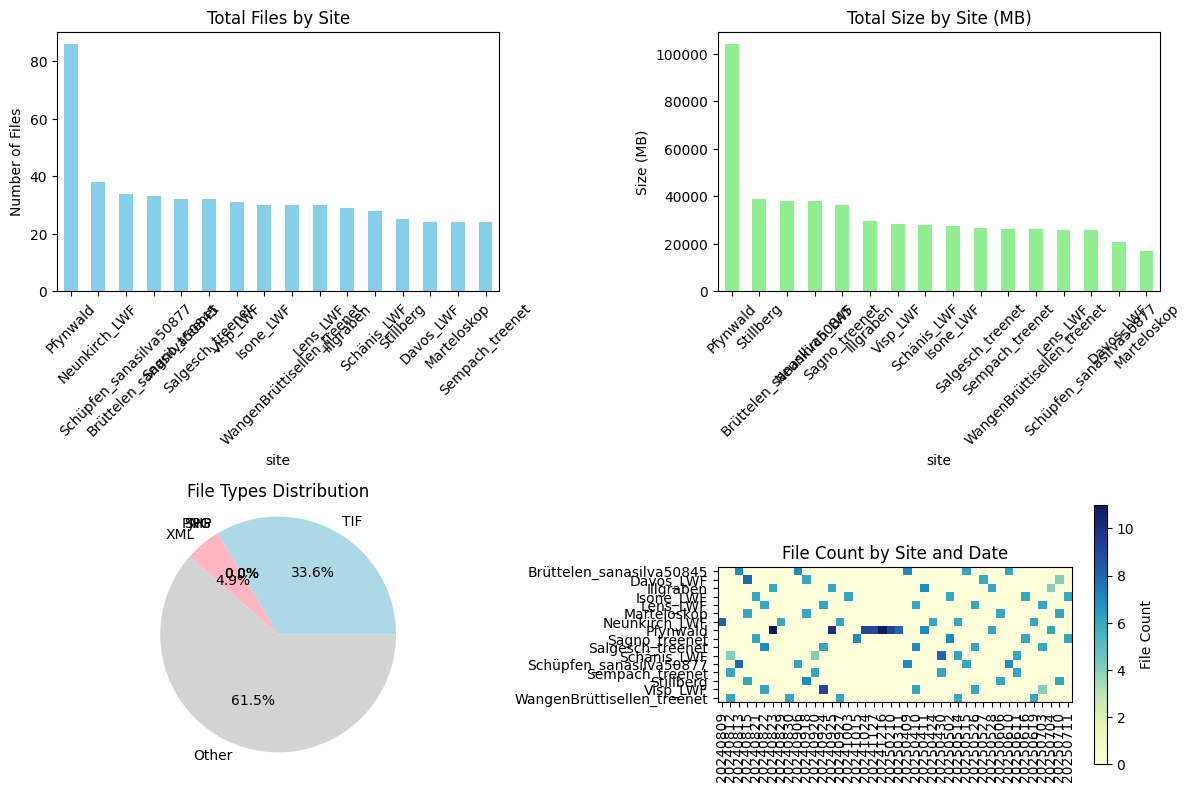


Site Statistics:


,site,date_count,total_files,total_size_human,avg_files_per_date
7,Pfynwald,10,86,109.0 GB,8.6
6,Neunkirch_LWF,6,38,39.7 GB,6.3
11,Schüpfen_sanasilva50877,5,34,27.0 GB,6.8
0,Brüttelen_sanasilva50845,5,33,39.7 GB,6.6
8,Sagno_treenet,5,32,38.0 GB,6.4
9,Salgesch_treenet,5,32,27.9 GB,6.4
14,Visp_LWF,5,31,29.6 GB,6.2
3,Isone_LWF,5,30,28.8 GB,6.0
15,WangenBrüttisellen_treenet,5,30,27.3 GB,6.0
4,Lens_LWF,5,30,27.2 GB,6.0


In [32]:
# Create visualizations for all sites/dates summary
if 'all_file_dfs' in locals() and len(all_file_dfs) > 1:
    print("\n" + "="*80)
    print("CREATING VISUALIZATIONS FOR ALL SITES AND DATES")
    print("="*80)
    
    # Create summary data for visualization
    viz_data = []
    
    for (site, date), df in all_file_dfs.items():
        if not df.empty:
            total_files = len(df)
            total_size = df['size_bytes'].sum()
            file_types_count = df['extension'].value_counts().to_dict()
            
            # Get counts of common export file types
            tif_count = file_types_count.get('.tif', 0)
            jpg_count = file_types_count.get('.jpg', 0)
            png_count = file_types_count.get('.png', 0)
            shp_count = file_types_count.get('.shp', 0)
            xml_count = file_types_count.get('.xml', 0)
            
            viz_data.append({
                'site': site,
                'date': date,
                'total_files': total_files,
                'total_size_bytes': total_size,
                'total_size_mb': total_size / 1024 / 1024,  # Convert to MB
                'tif_count': tif_count,
                'jpg_count': jpg_count,
                'png_count': png_count,
                'shp_count': shp_count,
                'xml_count': xml_count
            })
    
    if viz_data:
        # Convert to DataFrame for plotting
        viz_df = pd.DataFrame(viz_data)
        
        # Plot file counts by site and date
        plt.figure(figsize=(12, 8))
        
        # Group by site and sum total files
        site_totals = viz_df.groupby('site')['total_files'].sum().sort_values(ascending=False)
        
        # Bar chart of total files per site
        plt.subplot(2, 2, 1)
        site_totals.plot.bar(color='skyblue')
        plt.title('Total Files by Site')
        plt.ylabel('Number of Files')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Plot file sizes by site and date
        plt.subplot(2, 2, 2)
        site_sizes = viz_df.groupby('site')['total_size_mb'].sum().sort_values(ascending=False)
        site_sizes.plot.bar(color='lightgreen')
        plt.title('Total Size by Site (MB)')
        plt.ylabel('Size (MB)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Plot distribution of file types across all sites
        plt.subplot(2, 2, 3)
        file_type_data = {
            'TIF': viz_df['tif_count'].sum(),
            'JPG': viz_df['jpg_count'].sum(),
            'PNG': viz_df['png_count'].sum(),
            'SHP': viz_df['shp_count'].sum(),
            'XML': viz_df['xml_count'].sum(),
            'Other': viz_df['total_files'].sum() - (
                viz_df['tif_count'].sum() + viz_df['jpg_count'].sum() + 
                viz_df['png_count'].sum() + viz_df['shp_count'].sum() + 
                viz_df['xml_count'].sum()
            )
        }
        
        plt.pie(
            file_type_data.values(), 
            labels=file_type_data.keys(), 
            autopct='%1.1f%%',
            colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'lightgrey']
        )
        plt.title('File Types Distribution')
        plt.axis('equal')
        
        # Create a heatmap of file counts by site and date
        if len(viz_df) > 1:
            plt.subplot(2, 2, 4)
            
            # Prepare data for heatmap
            heatmap_data = viz_df.pivot_table(
                values='total_files', 
                index='site', 
                columns='date', 
                aggfunc='sum',
                fill_value=0
            )
            
            # Plot heatmap
            plt.imshow(heatmap_data, cmap='YlGnBu')
            plt.colorbar(label='File Count')
            plt.title('File Count by Site and Date')
            plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
            plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
            
        plt.tight_layout()
        plt.show()
        
        # Create a table with site statistics
        site_stats = viz_df.groupby('site').agg(
            total_files=('total_files', 'sum'),
            total_size_mb=('total_size_mb', 'sum'),
            date_count=('date', 'nunique'),
            avg_files_per_date=('total_files', 'mean')
        ).reset_index()
        
        site_stats['total_size_human'] = site_stats['total_size_mb'].apply(
            lambda x: humanize.naturalsize(x * 1024 * 1024)
        )
        site_stats['avg_files_per_date'] = site_stats['avg_files_per_date'].round(1)
        
        # Sort by total files descending
        site_stats = site_stats.sort_values('total_files', ascending=False)
        
        # Display the table
        print("\nSite Statistics:")
        display(site_stats[['site', 'date_count', 'total_files', 'total_size_human', 'avg_files_per_date']])

# File Checker for Drone Processing Outputs

This notebook helps you check folders to determine which expected files were created and which ones are missing. 

It's especially useful for:
- Verifying that all expected output files were created after running DEMtests.py
- Checking for missing files across multiple project folders
- Generating reports of file presence/absence for quality control purposes

## 1. Import Required Libraries

First, let's import all the necessary libraries for file operations, pattern matching, and visualization.

In [1]:
import os
import sys
import glob
import re
import fnmatch
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import argparse
from tqdm import tqdm
import json
from collections import defaultdict

# For displaying tables in the notebook
from IPython.display import display, HTML, Markdown

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define File Checking Functions

Now, let's define utility functions to:
- List files in directories
- Match file patterns
- Check file existence
- Compare expected vs. actual files

In [2]:
def list_files(directory, pattern=None, recursive=True):
    """
    List all files in directory matching a pattern
    
    Args:
        directory (str): Directory path to search
        pattern (str): Optional glob pattern to match
        recursive (bool): Whether to search recursively
        
    Returns:
        list: List of file paths
    """
    directory = Path(directory)
    if not directory.exists():
        print(f"Warning: Directory does not exist: {directory}")
        return []
    
    if pattern:
        if recursive:
            return list(directory.glob(f"**/{pattern}"))
        else:
            return list(directory.glob(pattern))
    else:
        if recursive:
            return [p for p in directory.glob("**/*") if p.is_file()]
        else:
            return [p for p in directory.glob("*") if p.is_file()]

def get_file_info(file_path):
    """
    Get metadata about a file
    
    Args:
        file_path (Path): Path to file
        
    Returns:
        dict: File information
    """
    file_path = Path(file_path)
    if not file_path.exists():
        return {
            'exists': False,
            'size': 0,
            'modified': None,
            'path': str(file_path)
        }
    
    stats = file_path.stat()
    return {
        'exists': True,
        'size': stats.st_size,
        'size_mb': stats.st_size / (1024 * 1024),
        'modified': datetime.fromtimestamp(stats.st_mtime),
        'path': str(file_path)
    }

def generate_expected_files(base_path, date_str, site_name, file_patterns):
    """
    Generate list of expected files based on patterns
    
    Args:
        base_path (str): Base directory path
        date_str (str): Date string (YYYYMMDD)
        site_name (str): Site name
        file_patterns (list): List of file patterns with placeholders
        
    Returns:
        list: List of expected file paths
    """
    base_path = Path(base_path)
    
    # Extract site name without suffix like _LWF, _treenet, etc.
    site_base = site_name.split('_')[0] if '_' in site_name else site_name
    
    # Create different variations of the prefix to handle different naming conventions
    prefixes = [
        f"{date_str}_{site_name}",  # Full site name with date
        f"{date_str}_{site_base}",   # Base site name with date
        f"{site_name}_{date_str}",   # Full site name after date
        f"{site_base}_{date_str}"    # Base site name after date
    ]
    
    expected_files = []
    for pattern in file_patterns:
        # Try each prefix variation
        for prefix in prefixes:
            # Replace placeholders with actual values
            expanded_pattern = pattern.replace("{date}", date_str)
            expanded_pattern = expanded_pattern.replace("{site}", site_base)
            expanded_pattern = expanded_pattern.replace("{site_full}", site_name)
            expanded_pattern = expanded_pattern.replace("{prefix}", prefix)
            
            # Handle glob patterns
            if "*" in expanded_pattern:
                matches = list(base_path.glob(expanded_pattern))
                expected_files.extend(matches)
            else:
                expected_files.append(base_path / expanded_pattern)
    
    # Remove duplicates while preserving order
    unique_expected_files = []
    seen = set()
    for f in expected_files:
        if str(f) not in seen:
            seen.add(str(f))
            unique_expected_files.append(f)
            
    return unique_expected_files

def check_files_existence(expected_files):
    """
    Check if expected files exist
    
    Args:
        expected_files (list): List of expected file paths
        
    Returns:
        dict: Dictionary with exists and missing file lists
    """
    exists = []
    missing = []
    
    for file_path in expected_files:
        file_path = Path(file_path)
        if file_path.exists():
            exists.append(file_path)
        else:
            missing.append(file_path)
            
    return {
        'exists': exists,
        'missing': missing
    }

def create_file_report_df(check_result):
    """
    Create a DataFrame report of file checking results
    
    Args:
        check_result (dict): Result from check_files_existence
        
    Returns:
        DataFrame: Report of file existence status
    """
    data = []
    
    # Add existing files
    for file_path in check_result['exists']:
        info = get_file_info(file_path)
        info['status'] = 'Exists'
        data.append(info)
    
    # Add missing files
    for file_path in check_result['missing']:
        info = get_file_info(file_path)
        info['status'] = 'Missing'
        data.append(info)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by path
    if not df.empty:
        df = df.sort_values('path')
    
    return df

def scan_project_folder(project_folder):
    """
    Scan a project folder to detect sites and dates
    
    Args:
        project_folder (str): Project folder path
        
    Returns:
        dict: Dictionary with detected sites and dates
    """
    project_folder = Path(project_folder)
    
    # First approach: detect sites from the actual subfolder names
    sites_dates = defaultdict(set)
    
    # Get direct subfolders of the project folder that might represent sites
    site_folders = [f for f in project_folder.glob("*") if f.is_dir()]
    
    # Look for site folders that match the pattern
    for folder in site_folders:
        folder_name = folder.name
        site_name = folder_name  # Use the full folder name as the site name
        
        # Look for exports folders under each site
        export_dirs = list(folder.glob("**/exports"))
        if not export_dirs:
            continue  # Skip folders with no exports directory
        
        # Look for date patterns in the filenames within exports directories
        for export_dir in export_dirs:
            files = list(export_dir.glob("*.tif")) + list(export_dir.glob("*.pdf"))
            for file in files:
                # Try to match the YYYYMMDD pattern anywhere in the filename
                date_matches = re.findall(r'(\d{8})(?:_|$)', file.name)
                for date_match in date_matches:
                    # Validate this looks like a real date (simple check for valid year)
                    if date_match.startswith(("202", "203")):  # Reasonable year range
                        sites_dates[site_name].add(date_match)
    
    # If no sites found, fall back to previous method
    if not sites_dates:
        # Look for export folders and reference files
        export_dirs = list(project_folder.glob("**/exports"))
        
        # Extract site and date info from export folders
        for export_dir in export_dirs:
            files = list(export_dir.glob("*.tif")) + list(export_dir.glob("*.pdf"))
            for file in files:
                # Try to match the YYYYMMDD_sitename pattern
                match = re.match(r'(\d{8})_([A-Za-z0-9]+)_', file.name)
                if match:
                    date = match.group(1)
                    site = match.group(2)
                    sites_dates[site].add(date)
    
    # Convert to regular dict with sorted dates
    result = {}
    for site, dates in sites_dates.items():
        result[site] = sorted(list(dates))
    
    return result

print("File checking functions defined successfully!")

File checking functions defined successfully!


## 3. Configuration Settings

Define configuration settings and expected file patterns based on the DEMtests.py script.

These patterns will help us check for expected output files, such as:
- DEM files at different resolutions
- Orthomosaic files 
- Processing reports
- Reference files and marker files

In [3]:
# Define configuration settings
CONFIG = {
    # Default paths
    "project_folder": r"M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects",
    
    # Expected file patterns based on DEMtests.py script
    "file_patterns": {
        # Exports directory patterns
        "exports": [
            # DEM files
            "{prefix}_rgb_dem_5cm.tif",          # DEM at 5cm resolution
            "{prefix}_dem_full_res.tif",         # Full resolution DEM
            
            # Orthomosaic files
            "{prefix}_rgb_ortho_1cm_dem5cm.tif",  # RGB orthomosaic at 1cm using 5cm DEM
            "{prefix}_multispec_ortho_100cm.tif", # Multispec orthomosaic
            "{prefix}_rgb_model_ortho_smooth_100.tif", # Smoothed RGB model orthomosaic (medium smoothing)
            "{prefix}_ortho_full_res.tif",        # Full resolution orthomosaic
            
            # 3D Models
            "{prefix}_rgb_smooth_100.obj",        # Smoothed RGB model (medium smoothing)
            
            # Reports
            "{prefix}_rgb_report.pdf",           # RGB processing report
            "{prefix}_multispec_report.pdf",     # Multispec processing report
        ],
        
        # References directory patterns
        "references": [
            # Reference files
            "RGBanalyzeImageDone.txt",           # RGB analysis completion marker
            "RGBAlignmentDone.txt",              # RGB alignment completion marker
            "MultiAnalyzeImageDone.txt",         # Multispec analysis completion marker
            "MultiAlignmenteDone.txt",           # Multispec alignment completion marker
            "MultiCalibrated.txt",               # Multispec calibration completion marker
            "interpolated_micasense_pos.csv",    # Interpolated Micasense positions
            "interpolated_micasense_pos_updated.csv", # Updated Micasense positions
            "p1_pos_CH1903.csv",                 # P1 camera positions in CH1903 CRS
        ]
    },
    
    # For visualization
    "status_colors": {
        "Exists": "#28a745",  # Green for existing files
        "Missing": "#dc3545", # Red for missing files
    }
}

# Verify if project folder exists
project_folder = Path(CONFIG["project_folder"])
if not project_folder.exists():
    print(f"Warning: Project folder does not exist: {project_folder}")
    # Default to current directory if configured path doesn't exist
    CONFIG["project_folder"] = os.getcwd()
    print(f"Using current directory instead: {CONFIG['project_folder']}")
else:
    print(f"Project folder exists: {project_folder}")

# Load config from file if it exists (override defaults)
config_path = Path("file_checker_config.json")
if config_path.exists():
    try:
        with open(config_path, 'r') as f:
            user_config = json.load(f)
            # Update CONFIG with user settings
            for key, value in user_config.items():
                CONFIG[key] = value
        print(f"Loaded configuration from {config_path}")
    except Exception as e:
        print(f"Error loading configuration from {config_path}: {e}")

Project folder exists: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects


## 4. Scan Project Folder and Select Parameters

Scan the project folder to detect available sites and dates, then provide interactive controls to select:
1. The base directory to scan
2. Which site and date to check
3. Additional file patterns to include or exclude

In [4]:
# Scan project folder
project_folder = Path(CONFIG["project_folder"])
print(f"Scanning project folder: {project_folder}")

# Custom folder input (if needed)
# To use a different folder, uncomment and modify this line:
# project_folder = Path(r"your_path_here")

# Detect sites and dates
print("Detecting sites and dates from folder structure...")
sites_dates = scan_project_folder(project_folder)

if not sites_dates:
    print("No sites or dates detected in the project folder.")
    # Display manual input fields
    print("\nPlease enter site and date manually:")
    site_name = input("Site name: ")
    date_str = input("Date (YYYYMMDD): ")
    sites_dates = {site_name: [date_str]}

print("\nDetected sites and dates:")
for site, dates in sites_dates.items():
    print(f"- Site: {site}, Dates: {', '.join(dates)}")

# Ask if user wants to check all sites and all dates at once
check_all_sites = input("\nDo you want to check ALL SITES and ALL DATES at once? (y/n): ").lower() == 'y'

if check_all_sites:
    selected_site = "all"
    selected_date = "all"
    check_all_dates = True
    print("Checking all sites and all dates.")
else:
    # Select site and date for checking
    # If there's only one site and date, select them automatically
    if len(sites_dates) == 1 and len(list(sites_dates.values())[0]) == 1:
        selected_site = list(sites_dates.keys())[0]
        selected_date = list(sites_dates.values())[0][0]
        check_all_dates = False
        print(f"\nAutomatically selected site: {selected_site}, date: {selected_date}")
    else:
        # Interactive selection
        print("\nAvailable Sites:")
        sites = list(sites_dates.keys())
        sites.sort()  # Sort sites alphabetically for easier navigation
        
        for i, site in enumerate(sites):
            # Display site information with date count
            date_count = len(sites_dates[site])
            print(f"{i+1}. {site} ({date_count} date{'s' if date_count != 1 else ''})")
        
        # Site selection with validation
        while True:
            try:
                site_choice = input("Enter site number: ")
                site_idx = int(site_choice) - 1
                if 0 <= site_idx < len(sites):
                    break
                else:
                    print(f"Invalid site number. Please enter a number between 1 and {len(sites)}.")
            except ValueError:
                print("Please enter a valid number.")
        
        selected_site = sites[site_idx]
        dates = sites_dates[selected_site]
        
        # Ask if user wants to check all dates at once for the selected site
        check_all_dates = input(f"\nDo you want to check all {len(dates)} dates for {selected_site} at once? (y/n): ").lower() == 'y'
        
        if check_all_dates:
            selected_date = "all"  # Special value to indicate all dates should be checked
            print(f"Checking all dates for site: {selected_site}")
        else:
            # Date selection with dates displayed in a readable format
            print(f"\nAvailable Dates for {selected_site}:")
            for i, date in enumerate(dates):
                # Format date for display (YYYYMMDD to YYYY-MM-DD)
                formatted_date = f"{date[:4]}-{date[4:6]}-{date[6:8]}"
                print(f"{i+1}. {date} ({formatted_date})")
            
            # Date selection with validation
            while True:
                try:
                    date_choice = input("Enter date number: ")
                    date_idx = int(date_choice) - 1
                    if 0 <= date_idx < len(dates):
                        break
                    else:
                        print(f"Invalid date number. Please enter a number between 1 and {len(dates)}.")
                except ValueError:
                    print("Please enter a valid number.")
            
            selected_date = dates[date_idx]
            print(f"Selected site: {selected_site}, date: {selected_date}")

# Generate file prefix (only if we're checking a single date)
if not check_all_dates:
    file_prefix = f"{selected_date}_{selected_site}"
    print(f"File prefix: {file_prefix}")
else:
    if selected_site == "all":
        print(f"Checking all sites and all dates")
    else:
        print(f"Checking all dates for site: {selected_site}")

Scanning project folder: M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects
Detecting sites and dates from folder structure...

Detected sites and dates:
- Site: Neunkirch_LWF, Dates: 20240809, 20240829, 20240927, 20250424, 20250514, 20250619
- Site: Visp_LWF, Dates: 20240822, 20240924, 20250410, 20250526, 20250703
- Site: Sagno_treenet, Dates: 20240821, 20241015, 20250502, 20250616, 20250711
- Site: Marteloskop, Dates: 20240815, 20240918, 20250606, 20250710
- Site: Pfynwald, Dates: 20240823, 20240925, 20241024, 20241127, 20241216, 20250210, 20250311, 20250411, 20250528, 20250704
- Site: Stillberg, Dates: 20240815, 20240918, 20250606, 20250710
- Site: Salgesch_treenet, Dates: 20240822, 20240924, 20250410, 20250526, 20250703
- Site: Illgraben, Dates: 20240823, 20240925, 20250411, 20250528, 20250704
- Site: WangenBrüttisellen_treenet, Dates: 20240812, 20240830, 20240927, 20250514, 20250619
- Site: Davos_LWF, Dates: 20240815, 20240918, 20250

## 5. Check File Existence

Now that we've selected a site and date, let's check for the existence of expected files based on our patterns.

In [7]:
# Function to check files for a specific site and date
def check_site_date_files(site, date, project_folder):
    """Check files for a specific site and date"""
    # Create result container
    site_result = {
        'site': site,
        'date': date,
        'exports': {'exists': [], 'missing': []},
        'references': {'exists': [], 'missing': []},
        'export_completion': 0,
        'reference_completion': 0,
        'overall_completion': 0,
        'status': '',
        'project_dir': None,
        'exports_dir': None,
        'references_dir': None
    }
    
    try:
        # Find the project directory for the site and date
        site_folders = [f for f in project_folder.glob("*") if f.is_dir() and site in f.name]
        
        if not site_folders:
            print(f"No project directory found for site {site}")
            return site_result
            
        # Use the first matching project directory
        project_dir = site_folders[0]
        site_result['project_dir'] = project_dir
        
        # Find exports directory
        exports_dir = project_dir / "exports"
        if not exports_dir.exists():
            exports_dir = project_dir / "level1_proc"
            if not exports_dir.exists():
                exports_dirs = list(project_dir.glob("**/exports"))
                if exports_dirs:
                    exports_dir = exports_dirs[0]
                else:
                    print(f"Warning: No exports directory found under {project_dir}")
                    exports_dir = project_dir  # Fallback to project directory
        
        site_result['exports_dir'] = exports_dir
        
        # Find references directory
        references_dir = project_dir / "references"
        if not references_dir.exists():
            reference_dirs = list(project_dir.glob("**/references"))
            if reference_dirs:
                references_dir = reference_dirs[0]
            else:
                print(f"Warning: No references directory found under {project_dir}")
                references_dir = project_dir  # Fallback to project directory
        
        site_result['references_dir'] = references_dir
        
        # Generate expected files
        expected_export_files = generate_expected_files(exports_dir, date, site, CONFIG["file_patterns"]["exports"])
        expected_reference_files = generate_expected_files(references_dir, date, site, CONFIG["file_patterns"]["references"])
        
        # Check file existence
        export_check = check_files_existence(expected_export_files)
        reference_check = check_files_existence(expected_reference_files)
        
        site_result['exports'] = export_check
        site_result['references'] = reference_check
        
        # Calculate completion percentage
        export_total = len(export_check['exists']) + len(export_check['missing'])
        reference_total = len(reference_check['exists']) + len(reference_check['missing'])
        
        export_completion = len(export_check['exists']) / export_total * 100 if export_total > 0 else 0
        reference_completion = len(reference_check['exists']) / reference_total * 100 if reference_total > 0 else 0
        overall_completion = (export_completion + reference_completion) / 2 if (export_total + reference_total) > 0 else 0
        
        site_result['export_completion'] = export_completion
        site_result['reference_completion'] = reference_completion
        site_result['overall_completion'] = overall_completion
        
        # Determine status
        if overall_completion >= 95:
            status = "COMPLETE ✓"
        elif overall_completion >= 75:
            status = "MOSTLY COMPLETE"
        elif overall_completion >= 50:
            status = "PARTIALLY COMPLETE"
        elif overall_completion >= 25:
            status = "INITIAL PROGRESS"
        else:
            status = "MINIMAL PROGRESS"
        
        site_result['status'] = status
    
    except Exception as e:
        print(f"Error processing {site}, {date}: {e}")
        
    return site_result

# Initialize results list and variables needed for each mode
all_results = []
file_prefix = ""

# Check if we're doing a multi-site check
if selected_site == "all" and selected_date == "all":
    print("\nChecking all sites and all dates...")
    total_sites = len(sites_dates)
    
    # Create a progress bar for sites
    with tqdm(total=total_sites, desc="Processing Sites") as pbar_sites:
        # Process all sites and all dates
        for site, dates in sites_dates.items():
            site_results = []
            
            # Create a progress bar for dates within this site
            with tqdm(total=len(dates), desc=f"Processing {site}", leave=False) as pbar_dates:
                for date in dates:
                    result = check_site_date_files(site, date, project_folder)
                    if result and result['project_dir'] is not None:  # Make sure we found a valid result
                        all_results.append(result)
                        site_results.append(result)
                        # Print brief summary
                        print(f"  {site}, {date}: {len(result['exports']['exists'])}/{len(result['exports']['exists'])+len(result['exports']['missing'])} exports, "
                              f"{len(result['references']['exists'])}/{len(result['references']['exists'])+len(result['references']['missing'])} references - "
                              f"{result['overall_completion']:.1f}% - {result['status']}")
                    pbar_dates.update(1)
            
            # Update the sites progress bar
            pbar_sites.update(1)
    
    # Create summary DataFrames
    print("\nCreating summary report...")
    summary_data = []
    for result in all_results:
        summary_data.append({
            'Site': result['site'],
            'Date': result['date'],
            'Export Files Found': len(result['exports']['exists']),
            'Export Files Missing': len(result['exports']['missing']),
            'Export Completion %': result['export_completion'],
            'Reference Files Found': len(result['references']['exists']),
            'Reference Files Missing': len(result['references']['missing']),
            'Reference Completion %': result['reference_completion'],
            'Overall Completion %': result['overall_completion'],
            'Status': result['status']
        })
    
    # Create DataFrame from the data
    summary_df = pd.DataFrame(summary_data)
    if not summary_df.empty:
        # Sort by site and date
        summary_df = summary_df.sort_values(['Site', 'Date'])
        
        # Display the summary
        print("\nOverall Summary:")
        display(summary_df)
        
        # Calculate site-level summaries
        site_summary = summary_df.groupby('Site').agg({
            'Export Files Found': 'sum',
            'Export Files Missing': 'sum',
            'Export Completion %': 'mean',
            'Reference Files Found': 'sum',
            'Reference Files Missing': 'sum',
            'Reference Completion %': 'mean',
            'Overall Completion %': 'mean'
        }).reset_index()
        
        # Add status column
        site_summary['Status'] = site_summary['Overall Completion %'].apply(lambda x: 
            "COMPLETE ✓" if x >= 95 else 
            "MOSTLY COMPLETE" if x >= 75 else 
            "PARTIALLY COMPLETE" if x >= 50 else 
            "INITIAL PROGRESS" if x >= 25 else 
            "MINIMAL PROGRESS")
        
        print("\nSite-Level Summary:")
        display(site_summary)
        
        # Create combined report DataFrames for visualization - use the first result as a sample
        if all_results:
            latest_result = all_results[0]
            export_report = create_file_report_df(latest_result['exports'])
            reference_report = create_file_report_df(latest_result['references'])
            
            # Set variables needed for visualization
            export_check = latest_result['exports']
            reference_check = latest_result['references']
            export_completion = latest_result['export_completion']
            reference_completion = latest_result['reference_completion']
            overall_completion = latest_result['overall_completion']

elif selected_date == "all":
    # Process all dates for selected site
    dates = sites_dates[selected_site]
    print(f"\nChecking all dates for site {selected_site}...")
    
    with tqdm(total=len(dates), desc=f"Processing {selected_site}") as pbar_dates:
        for date in dates:
            result = check_site_date_files(selected_site, date, project_folder)
            if result and result['project_dir'] is not None:
                all_results.append(result)
                # Print brief summary
                print(f"  Date {date}: {len(result['exports']['exists'])}/{len(result['exports']['exists'])+len(result['exports']['missing'])} exports, "
                      f"{len(result['references']['exists'])}/{len(result['references']['exists'])+len(result['references']['missing'])} references - "
                      f"{result['overall_completion']:.1f}% - {result['status']}")
            pbar_dates.update(1)
    
    # Create summary DataFrame
    summary_data = []
    for result in all_results:
        summary_data.append({
            'Date': result['date'],
            'Export Files Found': len(result['exports']['exists']),
            'Export Files Missing': len(result['exports']['missing']),
            'Export Completion %': result['export_completion'],
            'Reference Files Found': len(result['references']['exists']),
            'Reference Files Missing': len(result['references']['missing']),
            'Reference Completion %': result['reference_completion'],
            'Overall Completion %': result['overall_completion'],
            'Status': result['status']
        })
    
    # Create DataFrame from the data
    summary_df = pd.DataFrame(summary_data)
    if not summary_df.empty:
        # Sort by date
        summary_df = summary_df.sort_values('Date')
        
        # Display the summary
        print(f"\nSummary for site {selected_site}:")
        display(summary_df)
        
        # We'll use the first result for visualization purposes
        if all_results:
            latest_result = all_results[0]
            export_report = create_file_report_df(latest_result['exports'])
            reference_report = create_file_report_df(latest_result['references'])
            
            # Set variables needed for visualization
            export_check = latest_result['exports']
            reference_check = latest_result['references']
            export_completion = latest_result['export_completion']
            reference_completion = latest_result['reference_completion']
            overall_completion = latest_result['overall_completion']
            
            # Set file_prefix for export naming
            file_prefix = f"{selected_site}_all_dates"

else:
    # Process single site and date
    print(f"\nChecking files for site {selected_site}, date {selected_date}...")
    result = check_site_date_files(selected_site, selected_date, project_folder)
    
    if result and result['project_dir'] is not None:
        all_results.append(result)
        
        # Extract results for visualization and reporting
        export_check = result['exports']
        reference_check = result['references']
        project_dir = result['project_dir']
        exports_dir = result['exports_dir']
        references_dir = result['references_dir']
        export_completion = result['export_completion']
        reference_completion = result['reference_completion']
        overall_completion = result['overall_completion']
        
        # Create reports
        export_report = create_file_report_df(export_check)
        reference_report = create_file_report_df(reference_check)
        
        # Display summary
        print("\nFile Check Summary:")
        print(f"Project directory: {project_dir}")
        print(f"Exports directory: {exports_dir}")
        print(f"References directory: {references_dir}")
        print(f"Exports: {len(export_check['exists'])} exist, {len(export_check['missing'])} missing")
        print(f"References: {len(reference_check['exists'])} exist, {len(reference_check['missing'])} missing")
        print(f"Export files completion: {export_completion:.1f}%")
        print(f"Reference files completion: {reference_completion:.1f}%")
        print(f"Overall completion: {overall_completion:.1f}%")
        print(f"Status: {result['status']}")
    else:
        print(f"Error: Could not find project directory for site {selected_site}, date {selected_date}")


Checking all sites and all dates...


Processing Sites:   0%|          | 0/16 [00:00<?, ?it/s]

  Neunkirch_LWF, 20240809: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS


  Neunkirch_LWF, 20240829: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Neunkirch_LWF, 20240927: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Neunkirch_LWF, 20250424: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Neunkirch_LWF, 20250514: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:   6%|▋         | 1/16 [00:13<03:18, 13.20s/it]

  Neunkirch_LWF, 20250619: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Visp_LWF, 20240822: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Visp_LWF, 20240924: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Visp_LWF, 20250410: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Visp_LWF, 20250526: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  12%|█▎        | 2/16 [00:14<01:23,  5.97s/it]

  Visp_LWF, 20250703: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Sagno_treenet, 20240821: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Sagno_treenet, 20241015: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Sagno_treenet, 20250502: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Sagno_treenet, 20250616: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  19%|█▉        | 3/16 [00:15<00:48,  3.71s/it]

  Sagno_treenet, 20250711: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Marteloskop, 20240815: 5/18 exports, 6/8 references - 51.4% - PARTIALLY COMPLETE
  Marteloskop, 20240918: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  25%|██▌       | 4/16 [00:15<00:30,  2.51s/it]

  Marteloskop, 20250606: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Marteloskop, 20250710: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20240823: 7/18 exports, 6/8 references - 56.9% - PARTIALLY COMPLETE


  Pfynwald, 20240925: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20241024: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20241127: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20241216: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20250210: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20250311: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20250411: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Pfynwald, 20250528: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  31%|███▏      | 5/16 [01:40<05:54, 32.22s/it]

  Pfynwald, 20250704: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Stillberg, 20240815: 5/18 exports, 6/8 references - 51.4% - PARTIALLY COMPLETE
  Stillberg, 20240918: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Stillberg, 20250606: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  38%|███▊      | 6/16 [01:41<03:34, 21.46s/it]/s]

  Stillberg, 20250710: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Salgesch_treenet, 20240822: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Salgesch_treenet, 20240924: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Salgesch_treenet, 20250410: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Salgesch_treenet, 20250526: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  44%|████▍     | 7/16 [01:42<02:12, 14.74s/it]

  Salgesch_treenet, 20250703: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Illgraben, 20240823: 5/18 exports, 6/8 references - 51.4% - PARTIALLY COMPLETE
  Illgraben, 20240925: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Illgraben, 20250411: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Illgraben, 20250528: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  50%|█████     | 8/16 [01:43<01:23, 10.38s/it]

  Illgraben, 20250704: 0/18 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  WangenBrüttisellen_treenet, 20240812: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  WangenBrüttisellen_treenet, 20240830: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  WangenBrüttisellen_treenet, 20240927: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  WangenBrüttisellen_treenet, 20250514: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  56%|█████▋    | 9/16 [01:44<00:52,  7.44s/it]

  WangenBrüttisellen_treenet, 20250619: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Davos_LWF, 20240815: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Davos_LWF, 20240918: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  62%|██████▎   | 10/16 [01:44<00:32,  5.36s/it]

  Davos_LWF, 20250527: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Davos_LWF, 20250710: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Schänis_LWF, 20240812: 3/36 exports, 6/8 references - 41.7% - INITIAL PROGRESS
  Schänis_LWF, 20240920: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Schänis_LWF, 20250430: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Schänis_LWF, 20250514: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  69%|██████▉   | 11/16 [01:45<00:20,  4.03s/it]

  Schänis_LWF, 20250611: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Brüttelen_sanasilva50845, 20240813: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Brüttelen_sanasilva50845, 20240906: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Brüttelen_sanasilva50845, 20250409: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Brüttelen_sanasilva50845, 20250515: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  75%|███████▌  | 12/16 [01:46<00:12,  3.09s/it]

  Brüttelen_sanasilva50845, 20250610: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Sempach_treenet, 20240812: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Sempach_treenet, 20240920: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  81%|████████▏ | 13/16 [01:47<00:07,  2.38s/it]

  Sempach_treenet, 20250430: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Sempach_treenet, 20250611: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Schüpfen_sanasilva50877, 20240813: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Schüpfen_sanasilva50877, 20240906: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Schüpfen_sanasilva50877, 20250409: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Schüpfen_sanasilva50877, 20250515: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  88%|████████▊ | 14/16 [01:48<00:03,  1.95s/it]

  Schüpfen_sanasilva50877, 20250610: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Isone_LWF, 20240821: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Isone_LWF, 20241003: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Isone_LWF, 20250502: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Isone_LWF, 20250616: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites:  94%|█████████▍| 15/16 [01:49<00:01,  1.67s/it]

  Isone_LWF, 20250711: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Lens_LWF, 20240822: 5/36 exports, 6/8 references - 44.4% - INITIAL PROGRESS
  Lens_LWF, 20240924: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


  Lens_LWF, 20250410: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS
  Lens_LWF, 20250526: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS


Processing Sites: 100%|██████████| 16/16 [01:50<00:00,  6.91s/it]

  Lens_LWF, 20250703: 0/36 exports, 6/8 references - 37.5% - INITIAL PROGRESS

Creating summary report...

Overall Summary:


,Site,Date,Export Files Found,Export Files Missing,Export Completion %,Reference Files Found,Reference Files Missing,Reference Completion %,Overall Completion %,Status
58,Brüttelen_sanasilva50845,20240813,5,31,13.888889,6,2,75.0,44.444444,INITIAL PROGRESS
59,Brüttelen_sanasilva50845,20240906,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
60,Brüttelen_sanasilva50845,20250409,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
61,Brüttelen_sanasilva50845,20250515,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
62,Brüttelen_sanasilva50845,20250610,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
...,...,...,...,...,...,...,...,...,...,...
44,WangenBrüttisellen_treenet,20240812,5,31,13.888889,6,2,75.0,44.444444,INITIAL PROGRESS
45,WangenBrüttisellen_treenet,20240830,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
46,WangenBrüttisellen_treenet,20240927,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS
47,WangenBrüttisellen_treenet,20250514,0,36,0.000000,6,2,75.0,37.500000,INITIAL PROGRESS



Site-Level Summary:


,Site,Export Files Found,Export Files Missing,Export Completion %,Reference Files Found,Reference Files Missing,Reference Completion %,Overall Completion %,Status
0,Brüttelen_sanasilva50845,5,175,2.777778,30,10,75.0,38.888889,INITIAL PROGRESS
1,Davos_LWF,5,139,3.472222,24,8,75.0,39.236111,INITIAL PROGRESS
2,Illgraben,5,85,5.555556,30,10,75.0,40.277778,INITIAL PROGRESS
3,Isone_LWF,5,175,2.777778,30,10,75.0,38.888889,INITIAL PROGRESS
4,Lens_LWF,5,175,2.777778,30,10,75.0,38.888889,INITIAL PROGRESS
5,Marteloskop,5,67,6.944444,24,8,75.0,40.972222,INITIAL PROGRESS
6,Neunkirch_LWF,5,211,2.314815,36,12,75.0,38.657407,INITIAL PROGRESS
7,Pfynwald,7,173,3.888889,60,20,75.0,39.444444,INITIAL PROGRESS
8,Sagno_treenet,5,175,2.777778,30,10,75.0,38.888889,INITIAL PROGRESS
9,Salgesch_treenet,5,175,2.777778,30,10,75.0,38.888889,INITIAL PROGRESS


## 6. Visualize Results

Now let's visualize the results to get a clear picture of which files exist and which are missing.


Completion Status Heatmap:


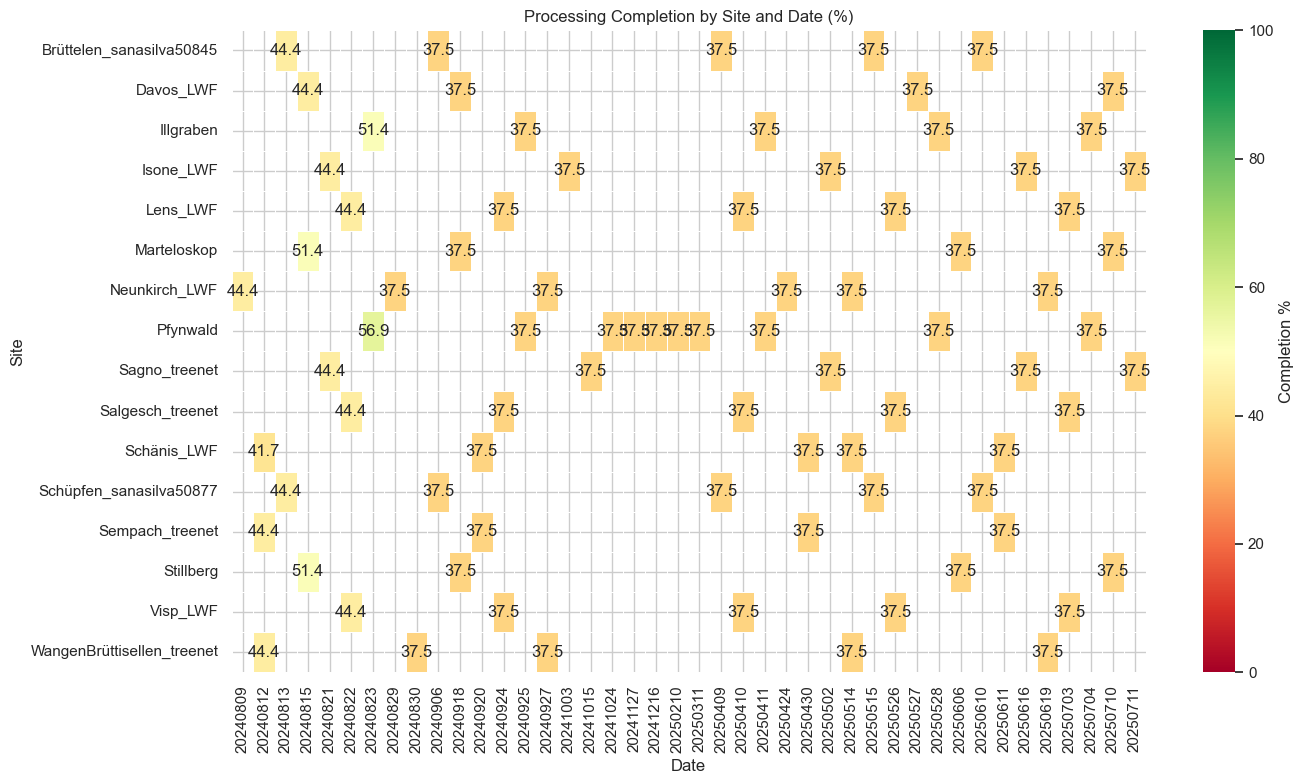

C:\Users\admin\AppData\Local\Temp\ipykernel_47384\3980819261.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Site', y='Overall Completion %', data=site_summary, palette="RdYlGn_r")


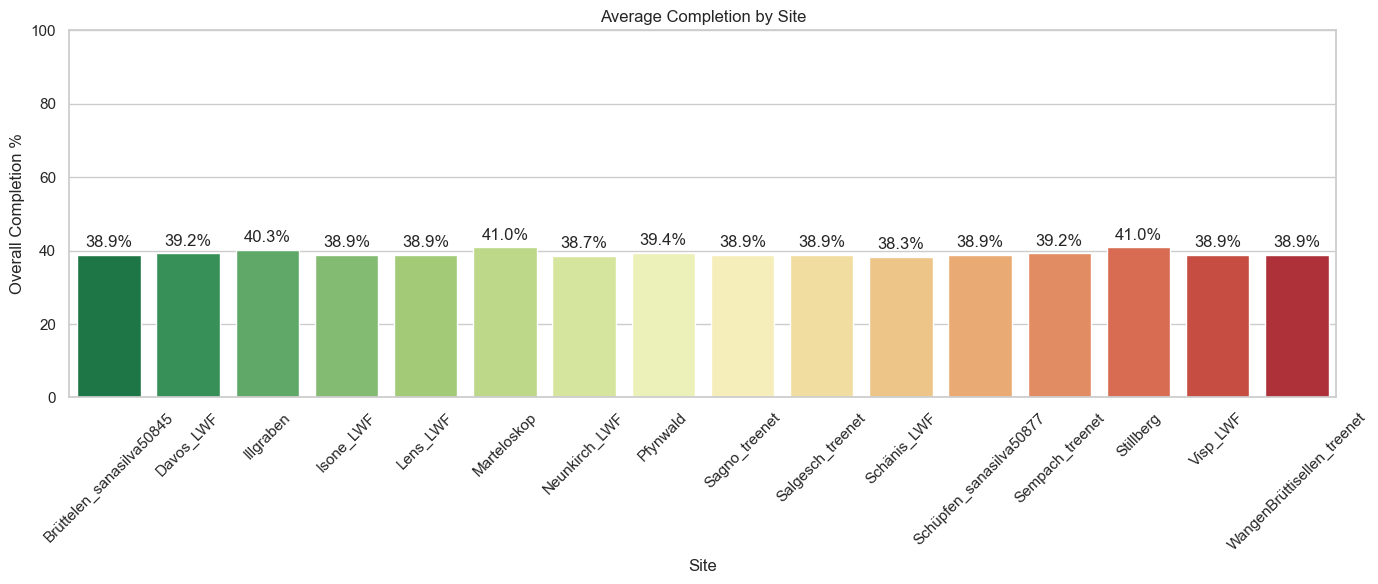


Sample File Details:


ValueError: NaTType does not support strftime

In [8]:
# Set up plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style="whitegrid")

# Define a function to format tables with colored status
def create_colored_table(df, title):
    if df is None or df.empty:
        return HTML(f"<h3>{title}</h3><p>No files found</p>")
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    styled_df = df.copy()
    
    # Ensure all columns are present
    for col in ['path', 'status', 'size_mb', 'modified']:
        if col not in styled_df.columns:
            if col == 'size_mb':
                styled_df[col] = 0.0
            elif col == 'modified':
                styled_df[col] = None
            else:
                styled_df[col] = ''
    
    # Format the file paths to be more readable
    styled_df['filename'] = styled_df['path'].apply(lambda x: os.path.basename(x) if x else "")
    
    # Format size in MB with 2 decimal places
    styled_df['size'] = styled_df['size_mb'].apply(lambda x: f"{x:.2f} MB" if x else "N/A")
    
    # Format modified date
    styled_df['modified_date'] = styled_df['modified'].apply(
        lambda x: x.strftime('%Y-%m-%d %H:%M:%S') if x else "N/A"
    )
    
    # Select and order columns for display
    display_df = styled_df[['filename', 'status', 'size', 'modified_date']]
    display_df.columns = ['File Name', 'Status', 'Size', 'Last Modified']
    
    # Apply styling
    styled = display_df.style.set_table_attributes('class="table table-striped table-bordered table-hover"')
    
    # Apply conditional formatting for the Status column
    styled = styled.applymap(
        lambda x: f'color: white; background-color: {CONFIG["status_colors"]["Exists"]}' if x == 'Exists' else 
                 f'color: white; background-color: {CONFIG["status_colors"]["Missing"]}' if x == 'Missing' else '',
        subset=['Status']
    )
    
    # Add header
    header = f'<h3>{title} ({len(display_df)} files)</h3>'
    
    return HTML(header + styled.to_html())

# Create a pie chart function
def create_status_pie(exists_count, missing_count, title):
    if exists_count + missing_count == 0:
        return plt.figure(figsize=(8, 6))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sizes = [exists_count, missing_count]
    labels = ['Exists', 'Missing']
    colors = [CONFIG['status_colors']['Exists'], CONFIG['status_colors']['Missing']]
    explode = (0.1, 0)  # explode the 1st slice (Exists)
    
    ax.pie(
        sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90
    )
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(title)
    
    return fig

# Create function to visualize completion by site/date
def create_completion_heatmap(summary_df, title):
    if summary_df is None or summary_df.empty:
        print(f"No data available for: {title}")
        return None
    
    if 'Date' in summary_df.columns and 'Site' in summary_df.columns:
        # Create pivot table for heatmap
        try:
            pivot_df = summary_df.pivot(index='Site', columns='Date', values='Overall Completion %')
            
            plt.figure(figsize=(14, 8))
            ax = sns.heatmap(pivot_df, annot=True, cmap="RdYlGn", fmt=".1f", 
                            linewidths=.5, vmin=0, vmax=100, cbar_kws={'label': 'Completion %'})
            plt.title(title)
            plt.tight_layout()
            return ax
        except Exception as e:
            print(f"Error creating heatmap: {e}")
            return None
    elif 'Date' in summary_df.columns:
        # Single site, multiple dates
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Date', y='Overall Completion %', data=summary_df, palette="RdYlGn_r")
        plt.title(title)
        plt.xticks(rotation=45)
        plt.ylim(0, 100)
        
        # Add value annotations
        for i, v in enumerate(summary_df['Overall Completion %']):
            ax.text(i, v + 2, f"{v:.1f}%", ha='center')
            
        plt.tight_layout()
        return ax
    elif 'Site' in summary_df.columns:
        # Multiple sites summary
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Site', y='Overall Completion %', data=summary_df, palette="RdYlGn_r")
        plt.title(title)
        plt.xticks(rotation=45)
        plt.ylim(0, 100)
        
        # Add value annotations
        for i, v in enumerate(summary_df['Overall Completion %']):
            ax.text(i, v + 2, f"{v:.1f}%", ha='center')
            
        plt.tight_layout()
        return ax
    else:
        return None

# Check if we have any results to visualize
if not all_results:
    print("\nNo results to visualize. Please check your site and date selections.")
# Visualize based on the selected mode
elif 'summary_df' in locals() and not summary_df.empty:
    # If we have a summary DataFrame (all sites or all dates mode)
    if selected_site == "all" and selected_date == "all":
        # All sites and dates - create heatmap
        print("\nCompletion Status Heatmap:")
        ax = create_completion_heatmap(summary_df, "Processing Completion by Site and Date (%)")
        if ax is not None:
            plt.show()
        
        # Site summary bar chart
        if 'site_summary' in locals() and not site_summary.empty:
            plt.figure(figsize=(14, 6))
            ax = sns.barplot(x='Site', y='Overall Completion %', data=site_summary, palette="RdYlGn_r")
            plt.title("Average Completion by Site")
            plt.xticks(rotation=45)
            plt.ylim(0, 100)
            
            # Add value annotations
            for i, v in enumerate(site_summary['Overall Completion %']):
                ax.text(i, v + 2, f"{v:.1f}%", ha='center')
                
            plt.tight_layout()
            plt.show()
        
    elif selected_date == "all":
        # Single site, all dates - create bar chart
        print(f"\nCompletion Status for {selected_site}:")
        ax = create_completion_heatmap(summary_df, f"Processing Completion for {selected_site} by Date")
        if ax is not None:
            plt.show()
    
    # Display file tables for the most recent result if available
    if 'export_report' in locals() and 'reference_report' in locals() and 'export_check' in locals() and 'reference_check' in locals():
        # Sample visualization of a processed site/date
        print("\nSample File Details:")
        display(create_colored_table(export_report, "Export Files (Sample)"))
        display(create_colored_table(reference_report, "Reference Files (Sample)"))
        
        # Create pie charts
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        create_status_pie(
            len(export_check['exists']), 
            len(export_check['missing']), 
            f"Export Files Status (Sample)"
        )
        
        plt.subplot(1, 2, 2)
        create_status_pie(
            len(reference_check['exists']), 
            len(reference_check['missing']), 
            f"Reference Files Status (Sample)"
        )
        
        plt.tight_layout()
        plt.show()
else:
    # Check if we have the required variables for single site and date visualization
    if all('export_report' in locals(), 'reference_report' in locals(), 
           'export_check' in locals(), 'reference_check' in locals()):
        # Single site and date - visualize details
        print("\nExport Files:")
        display(create_colored_table(export_report, "Export Files"))
        
        print("\nReference Files:")
        display(create_colored_table(reference_report, "Reference Files"))
        
        # Create pie charts
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 2, 1)
        create_status_pie(
            len(export_check['exists']), 
            len(export_check['missing']), 
            f"Export Files Status - {selected_site}, {selected_date}"
        )
        
        plt.subplot(1, 2, 2)
        create_status_pie(
            len(reference_check['exists']), 
            len(reference_check['missing']), 
            f"Reference Files Status - {selected_site}, {selected_date}"
        )
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo valid results to visualize. Please check your site and date selections.")

## 7. Custom File Search

If you want to search for specific files or patterns beyond our predefined patterns, you can use the code below.

This is useful for finding other files related to your processing workflow that may not be included in the standard patterns.

In [ ]:
# Custom file search function
def search_for_files(base_dir, pattern, recursive=True):
    """
    Search for files matching a pattern in a directory
    
    Args:
        base_dir (str): Directory to search in
        pattern (str): Glob pattern to match files
        recursive (bool): Whether to search recursively
        
    Returns:
        list: List of matching file paths
    """
    base_dir = Path(base_dir)
    
    if recursive:
        found_files = list(base_dir.glob(f"**/{pattern}"))
    else:
        found_files = list(base_dir.glob(pattern))
    
    return found_files

# Example usage - uncomment and modify these lines as needed

# Search for all TIF files in the exports directory
# tif_files = search_for_files(exports_dir, "*.tif")
# print(f"Found {len(tif_files)} TIF files")
# for file in tif_files[:10]:  # Display first 10 files
#     print(f" - {file.name}")

# Search for CSV files in references directory
# csv_files = search_for_files(references_dir, "*.csv")
# print(f"\nFound {len(csv_files)} CSV files")
# for file in csv_files:
#     print(f" - {file.name}")

# Search for log files in the project directory
# log_files = search_for_files(project_dir, "*.log", recursive=True)
# print(f"\nFound {len(log_files)} log files")
# for file in log_files:
#     print(f" - {file}")

# Interactive search
print("\nCustom file search:")
search_dir = input("Directory to search in (press Enter for exports dir): ") or str(exports_dir)
search_pattern = input("File pattern to search for (e.g., *.tif, *ortho*.tif): ")
search_recursive = input("Search recursively? (y/n, default: y): ").lower() != 'n'

search_results = search_for_files(search_dir, search_pattern, search_recursive)

print(f"\nFound {len(search_results)} files matching '{search_pattern}':")
for i, file in enumerate(search_results[:20]):  # Show first 20 results
    print(f" {i+1}. {file}")

if len(search_results) > 20:
    print(f"...and {len(search_results) - 20} more files")

# Get file details for found files
if search_results:
    search_details = []
    for file_path in search_results:
        info = get_file_info(file_path)
        search_details.append(info)
    
    search_df = pd.DataFrame(search_details)
    if not search_df.empty:
        search_df['status'] = 'Exists'  # All found files exist
        display(create_colored_table(search_df, f"Custom Search: {search_pattern}"))

## 8. Export Results

Generate reports and export the results to files for documentation or further analysis.

In [ ]:
# Prepare export data
def export_results_to_csv(export_df, reference_df, summary_df=None, site_summary_df=None, output_dir=None, file_prefix="results"):
    """
    Export results to CSV files
    
    Args:
        export_df (DataFrame): Export files DataFrame
        reference_df (DataFrame): Reference files DataFrame
        summary_df (DataFrame): Optional summary DataFrame for multi-site or multi-date checks
        site_summary_df (DataFrame): Optional site summary DataFrame for all sites check
        output_dir (str): Output directory (defaults to current working directory)
        file_prefix (str): Prefix for output files
        
    Returns:
        dict: Dictionary with paths to the created files
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if output_dir is None:
        output_dir = os.getcwd()
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    result_files = {}
    
    # Generate filenames for basic exports
    if export_df is not None and not export_df.empty:
        export_file = output_dir / f"file_check_exports_{file_prefix}_{timestamp}.csv"
        export_df.to_csv(export_file, index=False)
        result_files['export_csv'] = export_file
    
    if reference_df is not None and not reference_df.empty:
        reference_file = output_dir / f"file_check_references_{file_prefix}_{timestamp}.csv"
        reference_df.to_csv(reference_file, index=False)
        result_files['reference_csv'] = reference_file
    
    # Export summary DataFrames if available
    if summary_df is not None and not summary_df.empty:
        summary_file = output_dir / f"file_check_summary_{file_prefix}_{timestamp}.csv"
        summary_df.to_csv(summary_file, index=False)
        result_files['summary_csv'] = summary_file
    
    if site_summary_df is not None and not site_summary_df.empty:
        site_summary_file = output_dir / f"file_check_site_summary_{file_prefix}_{timestamp}.csv"
        site_summary_df.to_csv(site_summary_file, index=False)
        result_files['site_summary_csv'] = site_summary_file
    
    # Create text summary report
    summary_txt_file = output_dir / f"file_check_report_{file_prefix}_{timestamp}.txt"
    
    with open(summary_txt_file, 'w') as f:
        f.write(f"File Check Summary Report\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        if selected_site == "all" and selected_date == "all":
            f.write("MODE: All Sites and All Dates\n\n")
            
            # Write site-level summary
            if site_summary_df is not None and not site_summary_df.empty:
                f.write("SITE LEVEL SUMMARY:\n")
                f.write("-" * 80 + "\n")
                for _, row in site_summary_df.iterrows():
                    f.write(f"Site: {row['Site']}\n")
                    f.write(f"  Export Files: {int(row['Export Files Found'])} found, {int(row['Export Files Missing'])} missing, {row['Export Completion %']:.1f}% complete\n")
                    f.write(f"  Reference Files: {int(row['Reference Files Found'])} found, {int(row['Reference Files Missing'])} missing, {row['Reference Completion %']:.1f}% complete\n")
                    f.write(f"  Overall Completion: {row['Overall Completion %']:.1f}%\n")
                    f.write(f"  Status: {row['Status']}\n\n")
            
            # Write detailed summary for each site/date
            if summary_df is not None and not summary_df.empty:
                f.write("\nDETAILED RESULTS BY SITE AND DATE:\n")
                f.write("-" * 80 + "\n")
                current_site = None
                for _, row in summary_df.iterrows():
                    if current_site != row['Site']:
                        current_site = row['Site']
                        f.write(f"\nSite: {current_site}\n")
                    
                    f.write(f"  Date: {row['Date']}\n")
                    f.write(f"    Export Files: {int(row['Export Files Found'])} found, {int(row['Export Files Missing'])} missing, {row['Export Completion %']:.1f}% complete\n")
                    f.write(f"    Reference Files: {int(row['Reference Files Found'])} found, {int(row['Reference Files Missing'])} missing, {row['Reference Completion %']:.1f}% complete\n")
                    f.write(f"    Overall Completion: {row['Overall Completion %']:.1f}%\n")
                    f.write(f"    Status: {row['Status']}\n")
        
        elif selected_date == "all":
            f.write(f"MODE: All Dates for Site '{selected_site}'\n\n")
            
            # Write detailed summary for each date
            if summary_df is not None and not summary_df.empty:
                f.write("RESULTS BY DATE:\n")
                f.write("-" * 80 + "\n")
                for _, row in summary_df.iterrows():
                    f.write(f"Date: {row['Date']}\n")
                    f.write(f"  Export Files: {int(row['Export Files Found'])} found, {int(row['Export Files Missing'])} missing, {row['Export Completion %']:.1f}% complete\n")
                    f.write(f"  Reference Files: {int(row['Reference Files Found'])} found, {int(row['Reference Files Missing'])} missing, {row['Reference Completion %']:.1f}% complete\n")
                    f.write(f"  Overall Completion: {row['Overall Completion %']:.1f}%\n")
                    f.write(f"  Status: {row['Status']}\n\n")
                
                # Calculate and write overall stats
                avg_completion = summary_df['Overall Completion %'].mean()
                total_exports_found = summary_df['Export Files Found'].sum()
                total_exports_missing = summary_df['Export Files Missing'].sum()
                total_refs_found = summary_df['Reference Files Found'].sum()
                total_refs_missing = summary_df['Reference Files Missing'].sum()
                
                f.write("\nOVERALL SUMMARY FOR SITE:\n")
                f.write("-" * 80 + "\n")
                f.write(f"Site: {selected_site}\n")
                f.write(f"  Total Export Files: {total_exports_found} found, {total_exports_missing} missing\n")
                f.write(f"  Total Reference Files: {total_refs_found} found, {total_refs_missing} missing\n")
                f.write(f"  Average Overall Completion: {avg_completion:.1f}%\n")
        
        else:
            # Single site, single date
            f.write(f"MODE: Single Site and Date\n\n")
            f.write(f"Site: {selected_site}\n")
            f.write(f"Date: {selected_date}\n\n")
            
            f.write("RESULTS:\n")
            f.write("-" * 80 + "\n")
            f.write("Export Files:\n")
            f.write(f"- Total: {len(export_df)}\n")
            f.write(f"- Exist: {len(export_df[export_df['status'] == 'Exists'])}\n")
            f.write(f"- Missing: {len(export_df[export_df['status'] == 'Missing'])}\n")
            f.write(f"- Completion: {export_completion:.1f}%\n\n")
            
            f.write("Reference Files:\n")
            f.write(f"- Total: {len(reference_df)}\n")
            f.write(f"- Exist: {len(reference_df[reference_df['status'] == 'Exists'])}\n")
            f.write(f"- Missing: {len(reference_df[reference_df['status'] == 'Missing'])}\n")
            f.write(f"- Completion: {reference_completion:.1f}%\n\n")
            
            f.write("Project Information:\n")
            if 'project_dir' in locals():
                f.write(f"- Project Directory: {project_dir}\n")
                f.write(f"- Exports Directory: {exports_dir}\n")
                f.write(f"- References Directory: {references_dir}\n\n")
            
            f.write(f"Overall Completion: {overall_completion:.1f}%\n")
        
        f.write("\n" + "-" * 80 + "\n")
        f.write("End of Report\n")
    
    result_files['summary_txt'] = summary_txt_file
    return result_files

# Ask if user wants to export results
export_results_choice = input("\nDo you want to export the results to CSV files? (y/n): ").lower() == 'y'

if export_results_choice:
    # Ask for output directory or use current directory
    output_dir = input("Output directory (press Enter for current directory): ") or os.getcwd()
    
    # Set appropriate file prefix based on selection
    if selected_site == "all" and selected_date == "all":
        export_file_prefix = "all_sites_all_dates"
        
        # Export results including summary DataFrames
        result_files = export_results_to_csv(
            export_df=export_report if 'export_report' in locals() else pd.DataFrame(),
            reference_df=reference_report if 'reference_report' in locals() else pd.DataFrame(),
            summary_df=summary_df if 'summary_df' in locals() else None,
            site_summary_df=site_summary if 'site_summary' in locals() else None,
            output_dir=output_dir,
            file_prefix=export_file_prefix
        )
    elif selected_date == "all":
        export_file_prefix = f"{selected_site}_all_dates"
        
        # Export results including summary DataFrame
        result_files = export_results_to_csv(
            export_df=export_report if 'export_report' in locals() else pd.DataFrame(),
            reference_df=reference_report if 'reference_report' in locals() else pd.DataFrame(),
            summary_df=summary_df if 'summary_df' in locals() else None,
            output_dir=output_dir,
            file_prefix=export_file_prefix
        )
    else:
        export_file_prefix = file_prefix
        
        # Export results for single site/date
        result_files = export_results_to_csv(
            export_df=export_report,
            reference_df=reference_report,
            output_dir=output_dir,
            file_prefix=export_file_prefix
        )
    
    print("\nExported results to:")
    for name, path in result_files.items():
        print(f"- {name}: {path}")
else:
    print("Results not exported.")

# Generate overall summary based on the mode
if selected_site == "all" and selected_date == "all":
    print("\nAll Sites and Dates Processing Status Complete!")
    if 'site_summary' in locals() and not site_summary.empty:
        # Calculate overall stats across all sites
        overall_avg_completion = site_summary['Overall Completion %'].mean()
        complete_sites = site_summary[site_summary['Overall Completion %'] >= 95].shape[0]
        mostly_complete_sites = site_summary[(site_summary['Overall Completion %'] < 95) & 
                                            (site_summary['Overall Completion %'] >= 75)].shape[0]
        partial_sites = site_summary[(site_summary['Overall Completion %'] < 75) & 
                                    (site_summary['Overall Completion %'] >= 25)].shape[0]
        minimal_sites = site_summary[site_summary['Overall Completion %'] < 25].shape[0]
        
        print(f"\nOverall Status Across All Sites:")
        print(f"- Average Completion: {overall_avg_completion:.1f}%")
        print(f"- Complete Sites: {complete_sites}")
        print(f"- Mostly Complete Sites: {mostly_complete_sites}")
        print(f"- Partially Complete Sites: {partial_sites}")
        print(f"- Minimal Progress Sites: {minimal_sites}")
        
        # Determine overall project status
        if overall_avg_completion >= 95:
            print("\nOverall Project Status: COMPLETE ✓")
        elif overall_avg_completion >= 75:
            print("\nOverall Project Status: MOSTLY COMPLETE")
        elif overall_avg_completion >= 50:
            print("\nOverall Project Status: PARTIALLY COMPLETE")
        elif overall_avg_completion >= 25:
            print("\nOverall Project Status: INITIAL PROGRESS")
        else:
            print("\nOverall Project Status: MINIMAL PROGRESS")

elif selected_date == "all":
    print(f"\nAll Dates for Site {selected_site} Processing Status Complete!")
    if 'summary_df' in locals() and not summary_df.empty:
        # Calculate overall stats for the site
        overall_avg_completion = summary_df['Overall Completion %'].mean()
        complete_dates = summary_df[summary_df['Overall Completion %'] >= 95].shape[0]
        mostly_complete_dates = summary_df[(summary_df['Overall Completion %'] < 95) & 
                                          (summary_df['Overall Completion %'] >= 75)].shape[0]
        partial_dates = summary_df[(summary_df['Overall Completion %'] < 75) & 
                                  (summary_df['Overall Completion %'] >= 25)].shape[0]
        minimal_dates = summary_df[summary_df['Overall Completion %'] < 25].shape[0]
        
        print(f"\nOverall Status For Site {selected_site}:")
        print(f"- Average Completion: {overall_avg_completion:.1f}%")
        print(f"- Complete Dates: {complete_dates}")
        print(f"- Mostly Complete Dates: {mostly_complete_dates}")
        print(f"- Partially Complete Dates: {partial_dates}")
        print(f"- Minimal Progress Dates: {minimal_dates}")
        
        # Determine overall site status
        if overall_avg_completion >= 95:
            print(f"\nOverall Site Status: COMPLETE ✓")
        elif overall_avg_completion >= 75:
            print(f"\nOverall Site Status: MOSTLY COMPLETE")
        elif overall_avg_completion >= 50:
            print(f"\nOverall Site Status: PARTIALLY COMPLETE")
        elif overall_avg_completion >= 25:
            print(f"\nOverall Site Status: INITIAL PROGRESS")
        else:
            print(f"\nOverall Site Status: MINIMAL PROGRESS")

else:
    # Single site and date summary already displayed
    print("\nOverall Processing Completeness Summary:")
    print(f"Site: {selected_site}, Date: {selected_date}")
    print(f"Export Files: {export_completion:.1f}% complete")
    print(f"Reference Files: {reference_completion:.1f}% complete")
    print(f"Overall Completion: {overall_completion:.1f}%")

    # Print completion status based on percentage
    if overall_completion >= 95:
        print("Status: COMPLETE ✓")
    elif overall_completion >= 75:
        print("Status: MOSTLY COMPLETE")
    elif overall_completion >= 50:
        print("Status: PARTIALLY COMPLETE")
    elif overall_completion >= 25:
        print("Status: INITIAL PROGRESS")
    else:
        print("Status: MINIMAL PROGRESS")

## 9. Conclusion and Next Steps

This notebook has checked for the presence of expected files from the DEMtests.py processing workflow. Based on the results, you can:

1. Identify which processing steps may have failed (based on missing output files)
2. Verify that all expected outputs were generated
3. Locate specific files that need attention
4. Track completion status across multiple projects

To adapt this notebook for other file patterns or projects:

1. Modify the `CONFIG["file_patterns"]` dictionary to include different file types or patterns
2. Change the project folder path to point to a different base directory
3. Export the configuration to a JSON file for reuse

In [ ]:
# Save current configuration for future use
def save_config(config, filename="file_checker_config.json"):
    """
    Save configuration to a JSON file
    
    Args:
        config (dict): Configuration dictionary
        filename (str): Output filename
    """
    with open(filename, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Configuration saved to {filename}")

# Uncomment to save the current configuration
# save_config(CONFIG)

print("File checking complete!")